In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from scipy.ndimage import zoom
from skimage import transform

In [2]:
ss = 16

In [9]:
tpf = np.zeros((1000,11*ss,11*ss))

fwhm = 2.3*ss
x0 = 5.4*ss
y0 = 5.8*ss

rshift_x = np.zeros(1000)#np.random.normal(0, 0.05, 1000)
rshift_y = np.zeros(1000)#np.random.normal(0, 0.05, 1000)

for x in range(11*ss):
    for y in range(11*ss):
        tpf[:,x,y] += 200*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

x0 = -0.6*ss + np.array([0.7*i/len(tpf)*ss for i in range(1000)])# + np.random.normal(0, 0.05, 1000)
y0 =  -1.8*ss + np.array([1.8*i/len(tpf)*ss for i in range(1000)])# + np.random.normal(0, 0.05, 1000)

for i in range(1000):
    tpf[i] = shift(tpf[i], [x0[i], y0[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    #print(0.7*i/len(tpf)*ss)
    
    
#for i in range(1000):
#    val = 200.0*i/len(tpf)
#    tpf[i,4,4:7] -= val
#    tpf[i,7,4:7] += val

norm_super_tpf = tpf[400]

tpf_out = np.zeros((1000,11,11))
for i in range(1000):
    tpf_out[i] = np.sum(tpf[i].reshape(11, ss, 11, ss), axis=(1,3))
    
tpf = tpf_out + 0.0

#x0 = np.array([0.7*i/len(tpf)*ss for i in range(1000)])
#y0 = np.array([1.8*i/len(tpf)*ss for i in range(1000)])

print(y0)

[-28.8    -28.7712 -28.7424 -28.7136 -28.6848 -28.656  -28.6272 -28.5984
 -28.5696 -28.5408 -28.512  -28.4832 -28.4544 -28.4256 -28.3968 -28.368
 -28.3392 -28.3104 -28.2816 -28.2528 -28.224  -28.1952 -28.1664 -28.1376
 -28.1088 -28.08   -28.0512 -28.0224 -27.9936 -27.9648 -27.936  -27.9072
 -27.8784 -27.8496 -27.8208 -27.792  -27.7632 -27.7344 -27.7056 -27.6768
 -27.648  -27.6192 -27.5904 -27.5616 -27.5328 -27.504  -27.4752 -27.4464
 -27.4176 -27.3888 -27.36   -27.3312 -27.3024 -27.2736 -27.2448 -27.216
 -27.1872 -27.1584 -27.1296 -27.1008 -27.072  -27.0432 -27.0144 -26.9856
 -26.9568 -26.928  -26.8992 -26.8704 -26.8416 -26.8128 -26.784  -26.7552
 -26.7264 -26.6976 -26.6688 -26.64   -26.6112 -26.5824 -26.5536 -26.5248
 -26.496  -26.4672 -26.4384 -26.4096 -26.3808 -26.352  -26.3232 -26.2944
 -26.2656 -26.2368 -26.208  -26.1792 -26.1504 -26.1216 -26.0928 -26.064
 -26.0352 -26.0064 -25.9776 -25.9488 -25.92   -25.8912 -25.8624 -25.8336
 -25.8048 -25.776  -25.7472 -25.7184 -25.6896 -25.6608

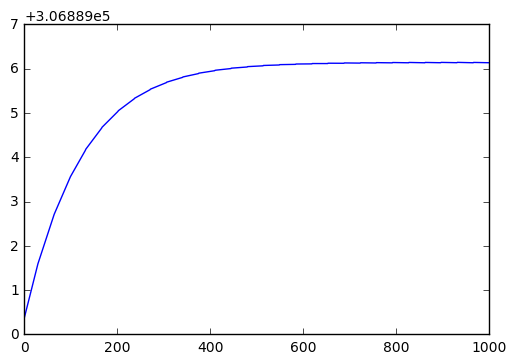

In [10]:
plt.plot(np.sum(tpf, axis=(1,2)))

In [11]:
lc = np.sum(tpf, axis=(1,2))
yc = np.linspace(0, 1, 1000)
xc = np.linspace(-0.5, 2.2, 1000)

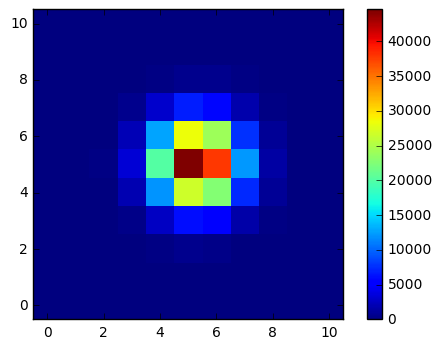

In [12]:
plt.imshow(tpf[-1], origin='lower', interpolation='nearest')
plt.colorbar()

In [13]:
from scipy.interpolate import RectBivariateSpline

In [14]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

xp = np.linspace(0, 10, 11*ss)
yp = np.linspace(0, 10, 11*ss)

In [15]:
#tpf = np.log(tpf)

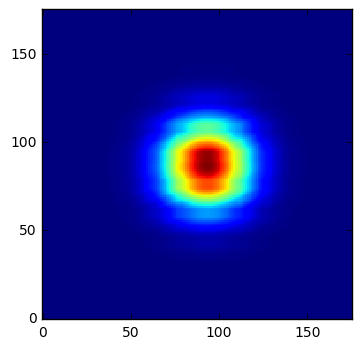

In [16]:
super_tpf = [transform.resize(tpf[i], np.asarray(tpf[i].shape)*ss, order=0) for i in range(1000)]
super_tpf = [shift(super_tpf[i], [-x0[i], -y0[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]


mean_super_tpf = np.mean(super_tpf, axis=0)
mean_super_tpf[mean_super_tpf < 0] = 0.0
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

plt.imshow(norm_super_tpf, origin='lower', interpolation='nearest')

In [17]:
detector = np.ones((11*ss,11*ss))

In [18]:
def model_prime(f, dy, dx, template):
    #interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    #return f * interp_again(yp - dy*ss, xp - dx*ss)
    interp_again = shift(template, [dy, dx], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    return f * interp_again

In [19]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, ss, 11, ss)
    return np.sum(tmp, axis=(1, 3))


In [20]:
data = tpf[0]

In [21]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s)*model(1, 0, 0, template_d) - self.data
        return np.sum(r * r)

In [22]:
from scipy.optimize import minimize
from tqdm import tqdm

print(np.shape(norm_super_tpf))

(176, 176)


In [23]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(195, 0.001*i, 0.002*i), args=(norm_super_tpf, detector), method='Powell')
    #print(sol.fun)
    results.append(sol.x)
    lnlike.append(sol.fun)
    #print(lnlike)

100%|██████████| 1000/1000 [02:44<00:00,  6.36it/s]


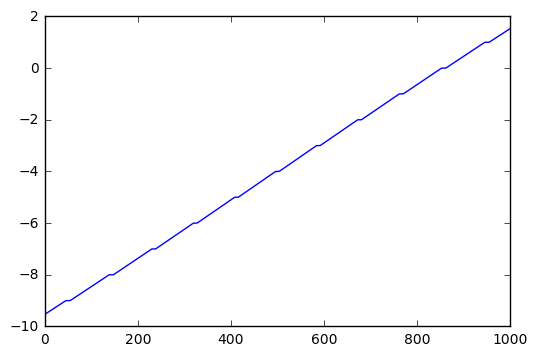

In [24]:
results = np.array(results)
plt.plot(results[:,1])

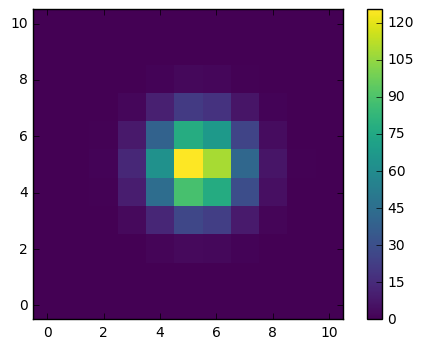

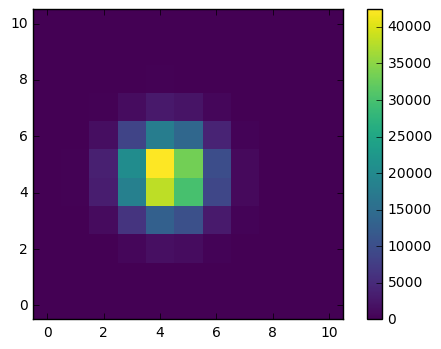

[  3.21862201e+00   2.00535544e+28              inf              inf
              inf              inf              inf              inf
   2.62152339e+60   2.26042146e+01   1.02516043e+00]
[  2.62439862e-03   1.41402620e-01   2.85571895e+00   2.31370791e+01
   7.70662890e+01   1.08896815e+02   6.73855812e+01   1.85907320e+01
   2.26152555e+00   1.16704291e-01   2.43193256e-03]
[  0.00000000e+00   9.31869414e-15   2.38155783e-14   4.59226411e-14
   7.81371921e-14   1.27733014e-13   2.02238428e-13   3.10321879e-13
   4.17791419e-13   4.88553737e-13   4.97549183e-13   5.05193838e-13
   5.16820635e-13   5.34176105e-13   5.59880247e-13   5.96303299e-13
   1.13190943e-12   2.46767048e-12   4.37237848e-12   7.07393001e-12
   1.08837347e-11   1.62558064e-11   2.37301360e-11   3.26369937e-11
   4.00609878e-11   4.37590834e-11   4.60347865e-11   4.92443387e-11
   5.36933574e-11   5.87145027e-11   6.01529190e-11   6.21345208e-11
   8.43090602e-11   1.36664423e-10   2.06725333e-10   3.00133622e-

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp


In [25]:
model_ = model(1000, 0.0, 0.0, norm_super_tpf)
#model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(model_, origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()
#plt.imshow(mode, origin='lower', interpolation='nearest', cmap='viridis')
#plt.show()
plt.imshow(tpf[400], origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()

print(np.exp(tpf[400,:,5]))
print(model_[:,6])
print(norm_super_tpf[17])


In [26]:
logL = lnlikelihood(data=tpf[400])
print(logL.evaluate((45.67, 1.6, 0.0), norm_super_tpf, detector))

6848747347.41


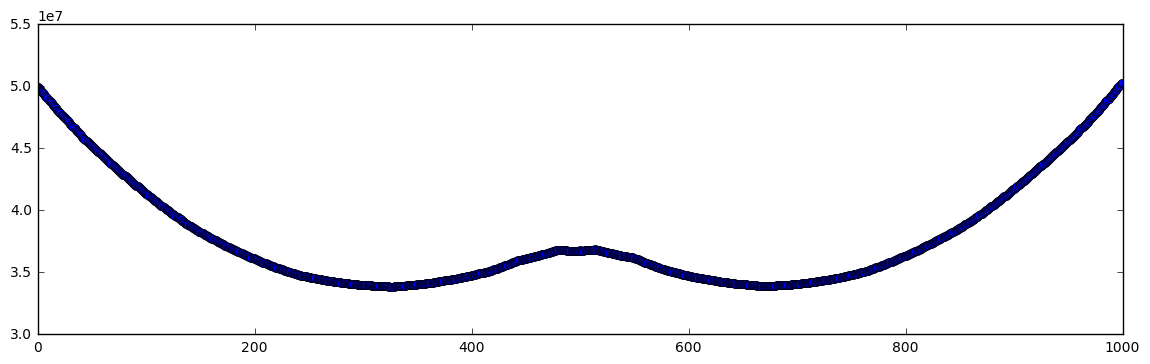

In [27]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [29]:
gds = norm_super_tpf
'''
i = -1
plt.imshow(models[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
plt.imshow(tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
print(np.sum(models[i]))
print(np.sum(tpf[i]))
print(results[500])
'''

"\ni = -1\nplt.imshow(models[i], interpolation='nearest', origin='lower')\nplt.colorbar()\nplt.show()\nplt.imshow(tpf[i], interpolation='nearest', origin='lower')\nplt.colorbar()\nplt.show()\nprint(np.sum(models[i]))\nprint(np.sum(tpf[i]))\nprint(results[500])\n"

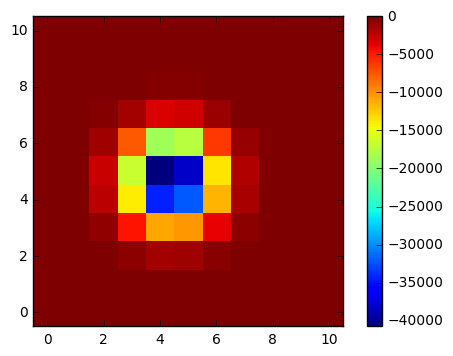

In [30]:
models = [model(*results[i], norm_super_tpf) for i in range(1000)]

i = 500
plt.imshow(models[i] - tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
#interps = [RectBivariateSpline(x, y, models[i]*16 - tpf[i], kx=1, ky=1) for i in range(1000)]

resids = models - tpf

interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
interps = [shift(interps[i], [-results[i,1], -results[i][2]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]


In [31]:
detector = np.ones((11*ss,11*ss))

In [32]:
dlnlike_ds = 2 * interps

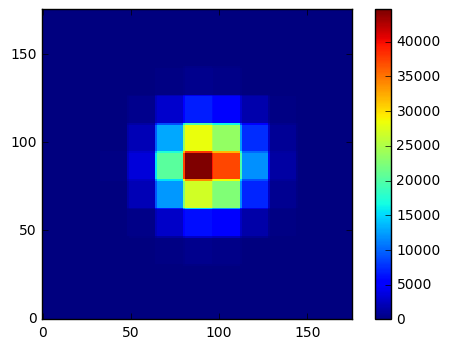

In [33]:
plt.imshow(-dlnlike_ds[-10], origin='lower', interpolation='nearest')
plt.colorbar()

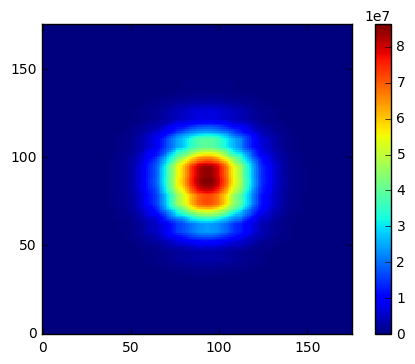

In [34]:
plt.imshow(-np.sum(dlnlike_ds, axis=(0)), origin='lower', interpolation='nearest')
plt.colorbar()

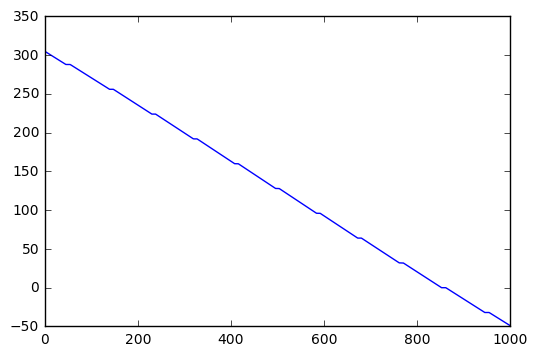

In [35]:
plt.plot(-2.0*ss*results[:,1])

In [36]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

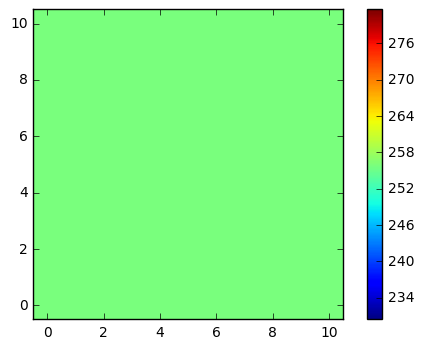

In [37]:
plt.imshow(model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [38]:
#gds = np.copy(norm_super_tpf)

In [39]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10/ss
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
    
    
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
    interps = [shift(interps[i], [-1.0*yc_n[i], -1.0*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]
    

    dlnlike_ds = 2 * interps
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    plt.imshow(-dlnlike_ds, interpolation='nearest', origin='lower')
    plt.colorbar()
    plt.show()
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 100:
        tmp_o = np.copy(tmp_s)
        tmp_s = tmp_s - c * dlnlike_ds
        tmp_s[tmp_s < 0] = 0.0
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after, c, j)
        if np.abs(c) < 1e-16:
            break
        if np.abs(logL_after - logL_before)/ logL_after < 1e-6:
            break
        if logL_after < logL_before:
            c *= 1.6
            models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
            interps = [shift(interps[i], [-1.0*yc_n[i], -1.0*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]
            dlnlike_ds = 2 * interps
            dlnlike_ds = np.sum(dlnlike_ds, axis=0)
            logL_before = logL_after
            
        else:
            tmp_s = np.copy(tmp_o)
            c *= -0.2

        
        j += 1
    return tmp_s

In [40]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
    
    dlnlike_dd = 2 * interps
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]

            dlnlike_dd = 2 * interps
            dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

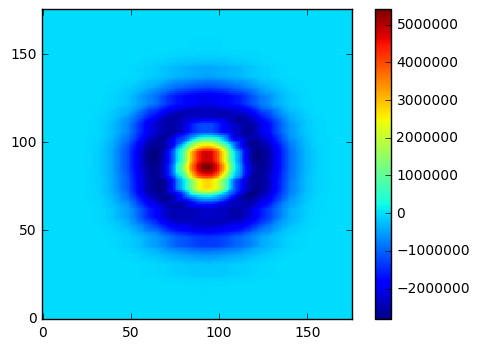

37828840253.9
2104720609.97 6.25e-12 0
2104720609.97
564390691.488 1.0000000000000001e-11 1
564390691.488
390981306.853 1.6000000000000003e-11 2
390981306.853
645203179.205 2.5600000000000007e-11 3
390981306.853
553503220.514 -5.120000000000002e-12 4
390981306.853
366092715.423 1.0240000000000003e-12 5
366092715.423
335430581.087 1.6384000000000006e-12 6
335430581.087
302203007.959 2.621440000000001e-12 7
302203007.959
270418206.285 4.194304000000002e-12 8
270418206.285
239448452.588 6.710886400000003e-12 9
239448452.588
204219725.713 1.0737418240000006e-11 10
204219725.713
165512745.551 1.717986918400001e-11 11
165512745.551
129182403.237 2.748779069440002e-11 12
129182403.237
102479224.226 4.398046511104004e-11 13
102479224.226
251858770.33 7.036874417766406e-11 14
102479224.226
129094395.489 -1.4073748835532812e-11 15
102479224.226
100223963.181 2.8147497671065625e-12 16
100223963.181
98134655.0878 4.5035996273705e-12 17
98134655.0878
95782471.4422 7.205759403792801e-12 18
95782471.

In [41]:
results = np.array(results)
gds = gradient_descent_ds(norm_super_tpf, detector, (results[:, 0], results[:,1], results[:, 2]))


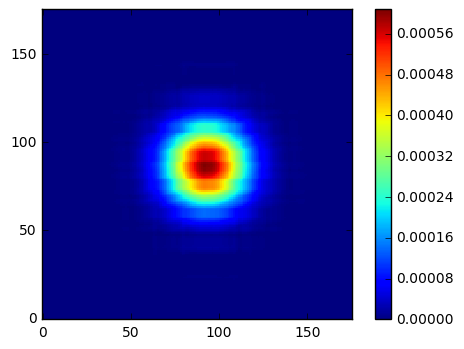

In [42]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

In [43]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

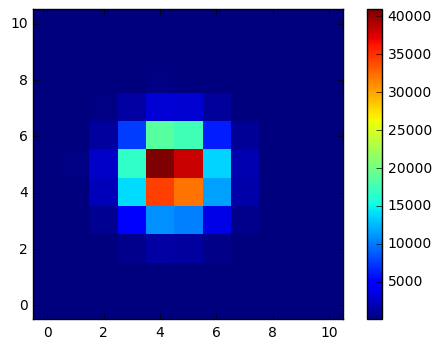

In [44]:
n=500
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) * model(1, 0, 0, detector) + 1, origin='lower', interpolation='nearest')
plt.colorbar()

In [45]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [02:40<00:00,  4.52it/s]


In [46]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

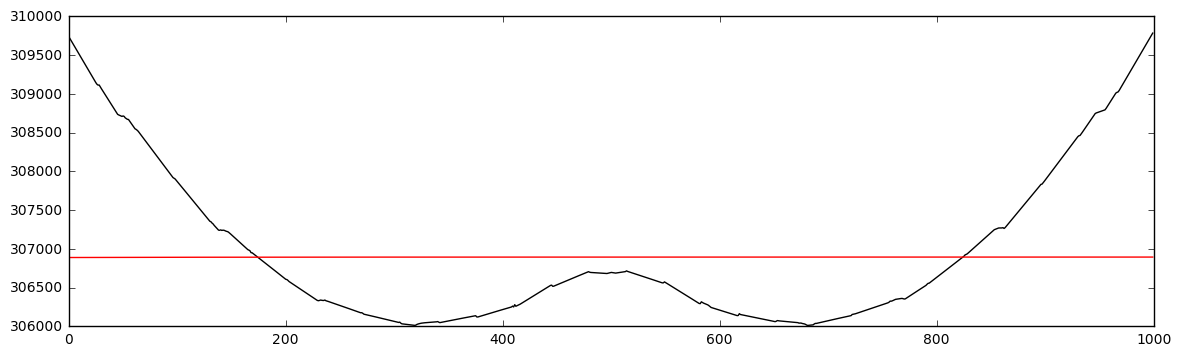

In [47]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1500, 2500)

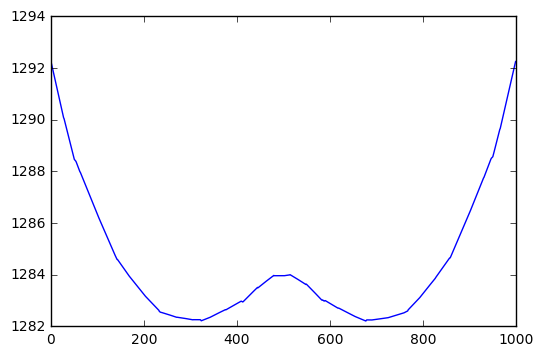

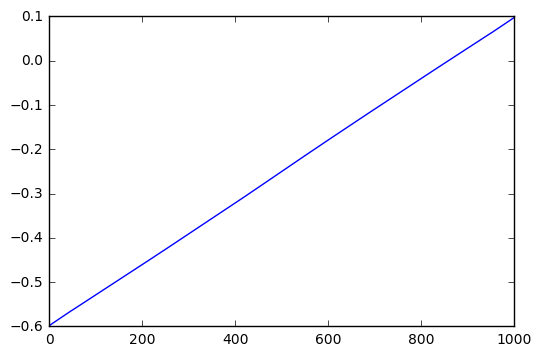

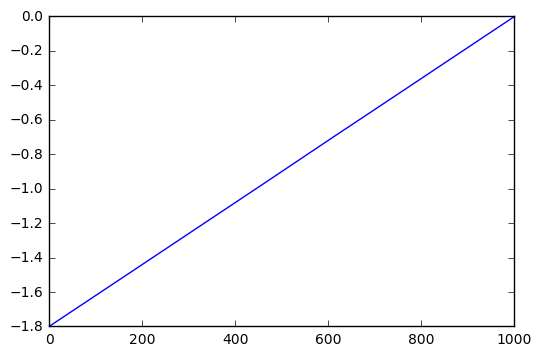

In [48]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,0])
plt.show()
plt.plot(np.arange(1000), results[:,1]/ss)
plt.show()
plt.plot(np.arange(1000), results[:,2]/ss)
plt.show()

What have we learned? This works *perfectly* when the star is not moving. This is a good thing!
When the star is moving, this is not working perfectly. Need to trace down why and figure out how to stop it.

0


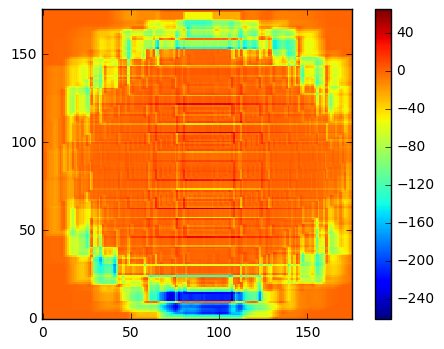

25915.4110621
25913.2127619 6.25e-12 0
25913.2127619
25909.718585 1.0000000000000001e-11 1
25909.718585
25904.1453434 1.6000000000000003e-11 2
25904.1453434
25895.2601652 2.5600000000000007e-11 3
25895.2601652
25881.1005065 4.096000000000001e-11 4
25881.1005065
25858.6827394 6.553600000000002e-11 5
25858.6827394
25850.9651438 1.0485760000000004e-10 6
25850.9651438
41297.7508926 1.6777216000000006e-10 7
25850.9651438
28617.8478795 -3.3554432000000015e-11 8
25850.9651438
25820.5389135 6.710886400000003e-12 9
25820.5389135
25816.7177273 1.0737418240000006e-11 10
25816.7177273
25810.9037148 1.717986918400001e-11 11
25810.9037148
25802.161328 2.748779069440002e-11 12
25802.161328
25807.3224186 4.398046511104004e-11 13
25802.161328
26059.6439381 -8.796093022208007e-12 14
25802.161328
25801.2550481 1.7592186044416015e-12 15
25801.2550481
25800.053518 2.8147497671065625e-12 16
25800.053518
25798.4101092 4.5035996273705e-12 17
25798.4101092
25795.9469995 7.205759403792801e-12 18
25795.9469995
2

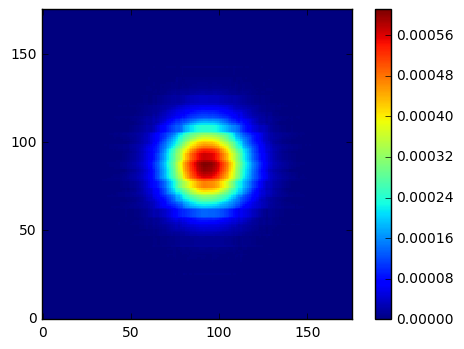

100%|██████████| 1000/1000 [01:36<00:00,  7.84it/s]


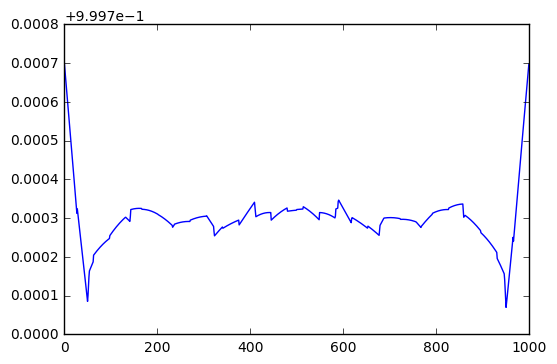

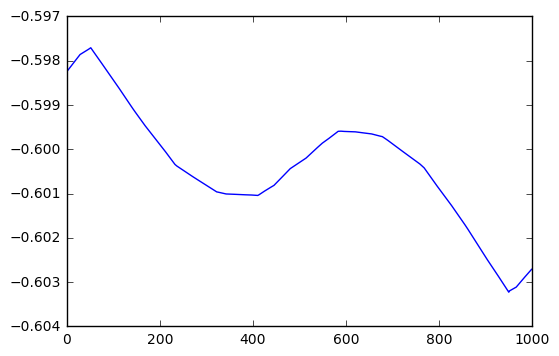

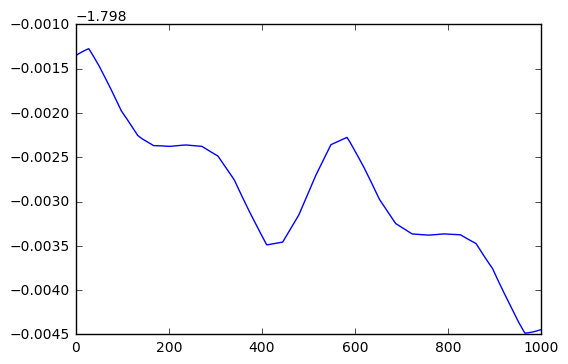

1


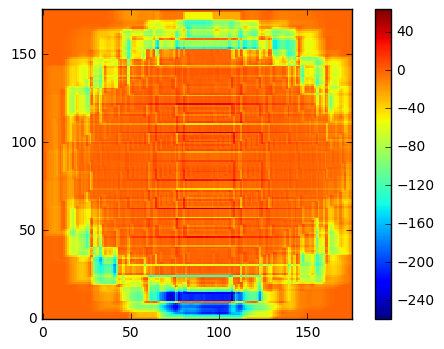

25399.5835726
25397.4477803 6.25e-12 0
25397.4477803
25394.0527299 1.0000000000000001e-11 1
25394.0527299
25388.6374112 1.6000000000000003e-11 2
25388.6374112
25380.0036868 2.5600000000000007e-11 3
25380.0036868
25366.2441736 4.096000000000001e-11 4
25366.2441736
25344.4565245 6.553600000000002e-11 5
25344.4565245
25336.3591845 1.0485760000000004e-10 6
25336.3591845
39983.4562668 1.6777216000000006e-10 7
25336.3591845
28024.8963167 -3.3554432000000015e-11 8
25336.3591845
25307.3913067 6.710886400000003e-12 9
25307.3913067
25303.6780983 1.0737418240000006e-11 10
25303.6780983
25298.027737 1.717986918400001e-11 11
25298.027737
25289.5343313 2.748779069440002e-11 12
25289.5343313
25294.6655031 4.398046511104004e-11 13
25289.5343313
25542.5763547 -8.796093022208007e-12 14
25289.5343313
25288.6520241 1.7592186044416015e-12 15
25288.6520241
25287.4831018 2.8147497671065625e-12 16
25287.4831018
25285.8853849 4.5035996273705e-12 17
25285.8853849
25283.4914936 7.205759403792801e-12 18
25283.491

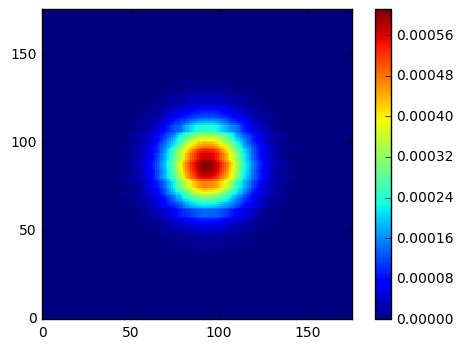

100%|██████████| 1000/1000 [01:35<00:00,  8.31it/s]


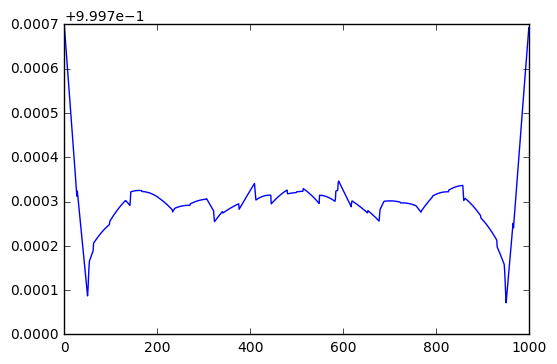

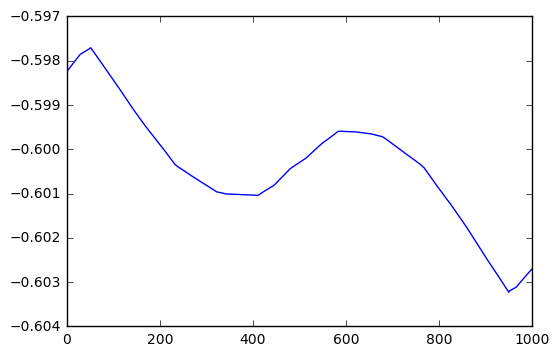

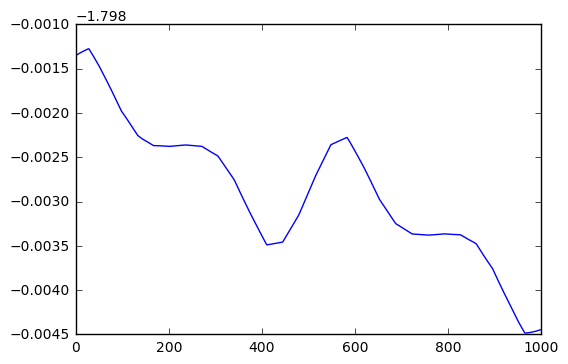

2


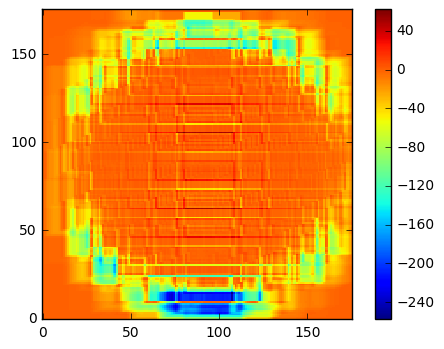

24898.2476416
24896.1718612 6.25e-12 0
24896.1718612
24892.8720364 1.0000000000000001e-11 1
24892.8720364
24887.6084111 1.6000000000000003e-11 2
24887.6084111
24879.2161895 2.5600000000000007e-11 3
24879.2161895
24865.8410223 4.096000000000001e-11 4
24865.8410223
24844.6609189 6.553600000000002e-11 5
24844.6609189
24836.679946 1.0485760000000004e-10 6
24836.679946
38988.3021281 1.6777216000000006e-10 7
24836.679946
27464.1856721 -3.3554432000000015e-11 8
24836.679946
24808.6283365 6.710886400000003e-12 9
24808.6283365
24805.0184766 1.0737418240000006e-11 10
24805.0184766
24799.5244183 1.717986918400001e-11 11
24799.5244183
24791.2580163 2.748779069440002e-11 12
24791.2580163
24795.8906237 4.398046511104004e-11 13
24791.2580163
25039.8756515 -8.796093022208007e-12 14
24791.2580163
24790.4050287 1.7592186044416015e-12 15
24790.4050287
24789.2721975 2.8147497671065625e-12 16
24789.2721975
24787.7202959 4.5035996273705e-12 17
24787.7202959
24785.3930105 7.205759403792801e-12 18
24785.39301

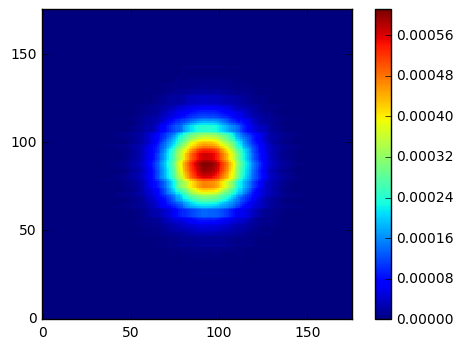

100%|██████████| 1000/1000 [01:34<00:00,  8.38it/s]


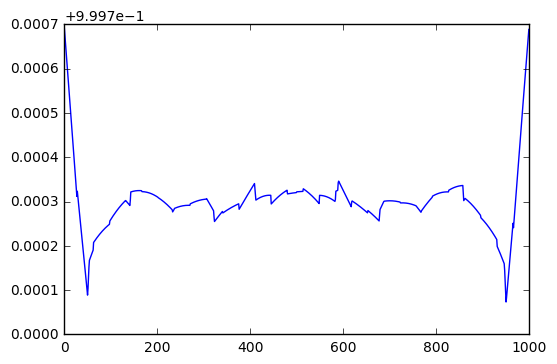

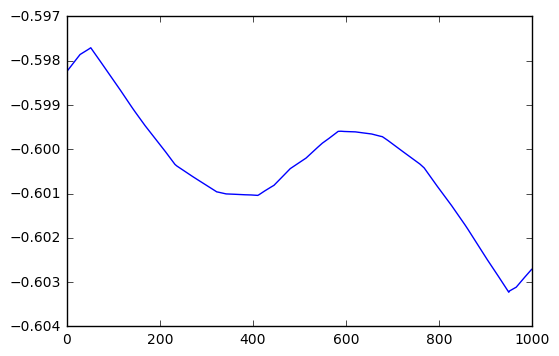

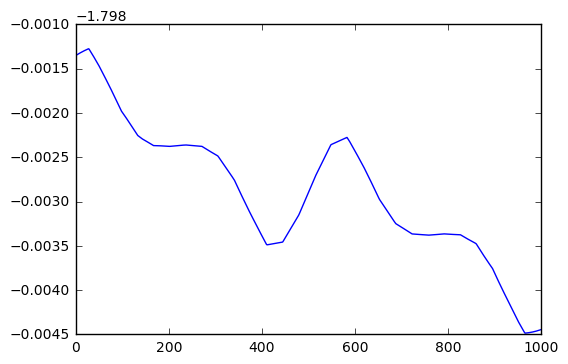

3


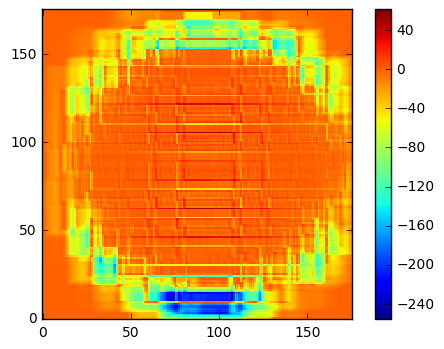

24410.8273449
24408.8092499 6.25e-12 0
24408.8092499
24405.6009273 1.0000000000000001e-11 1
24405.6009273
24400.4830718 1.6000000000000003e-11 2
24400.4830718
24392.3229337 2.5600000000000007e-11 3
24392.3229337
24379.3171438 4.096000000000001e-11 4
24379.3171438
24358.7194843 6.553600000000002e-11 5
24358.7194843
24350.6500832 1.0485760000000004e-10 6
24350.6500832
37956.6562364 1.6777216000000006e-10 7
24350.6500832
26914.5133129 -3.3554432000000015e-11 8
24350.6500832
24323.6775295 6.710886400000003e-12 9
24323.6775295
24320.1698061 1.0737418240000006e-11 10
24320.1698061
24314.8269707 1.717986918400001e-11 11
24314.8269707
24306.7870399 2.748779069440002e-11 12
24306.7870399
24311.2813077 4.398046511104004e-11 13
24306.7870399
24551.0538303 -8.796093022208007e-12 14
24306.7870399
24305.9579539 1.7592186044416015e-12 15
24305.9579539
24304.8567938 2.8147497671065625e-12 16
24304.8567938
24303.3479438 4.5035996273705e-12 17
24303.3479438
24301.0847633 7.205759403792801e-12 18
24301.0

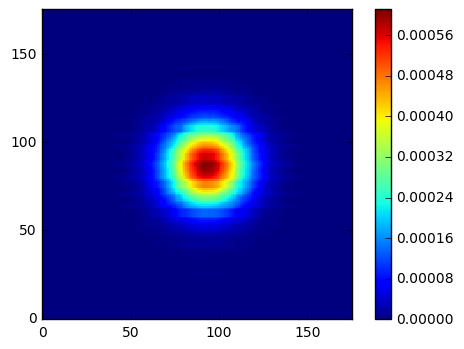

100%|██████████| 1000/1000 [01:27<00:00,  8.33it/s]


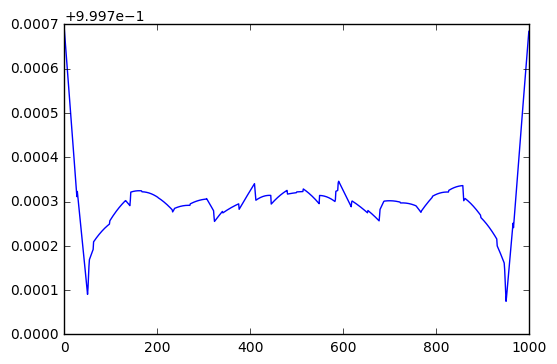

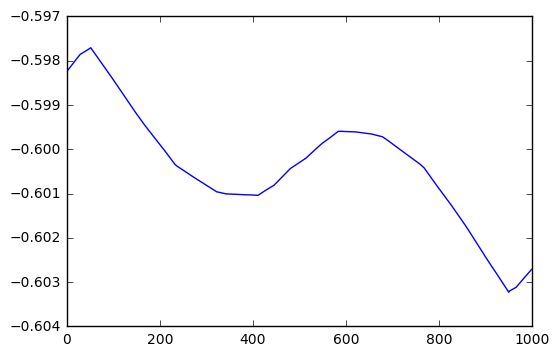

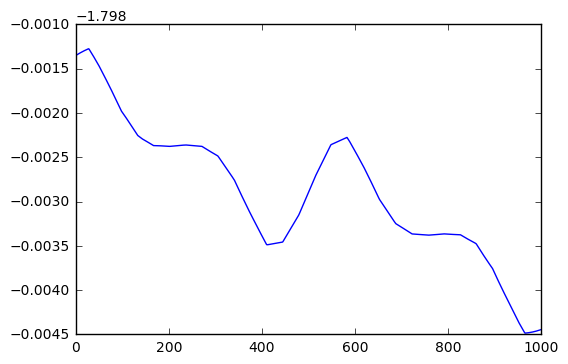

4


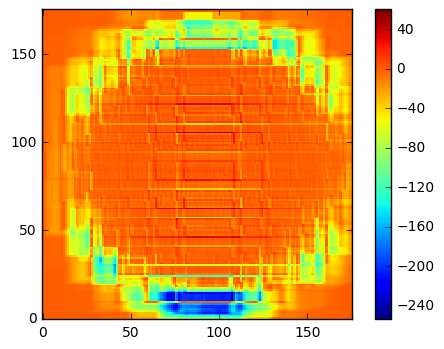

23936.7595009
23934.796929 6.25e-12 0
23934.796929
23931.6766726 1.0000000000000001e-11 1
23931.6766726
23926.699119 1.6000000000000003e-11 2
23926.699119
23918.7623813 2.5600000000000007e-11 3
23918.7623813
23906.1121175 4.096000000000001e-11 4
23906.1121175
23886.0760062 6.553600000000002e-11 5
23886.0760062
23878.073133 1.0485760000000004e-10 6
23878.073133
37030.0195945 1.6777216000000006e-10 7
23878.073133
26383.5774321 -3.3554432000000015e-11 8
23878.073133
23851.9895564 6.710886400000003e-12 9
23851.9895564
23848.5781371 1.0737418240000006e-11 10
23848.5781371
23843.3807091 1.717986918400001e-11 11
23843.3807091
23835.5603092 2.748779069440002e-11 12
23835.5603092
23839.9941737 4.398046511104004e-11 13
23835.5603092
24075.4962021 -8.796093022208007e-12 14
23835.5603092
23834.7532735 1.7592186044416015e-12 15
23834.7532735
23833.6818097 2.8147497671065625e-12 16
23833.6818097
23832.2141071 4.5035996273705e-12 17
23832.2141071
23830.0125852 7.205759403792801e-12 18
23830.0125852
2

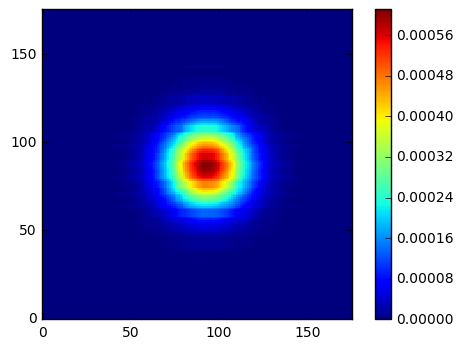

100%|██████████| 1000/1000 [01:28<00:00,  8.95it/s]


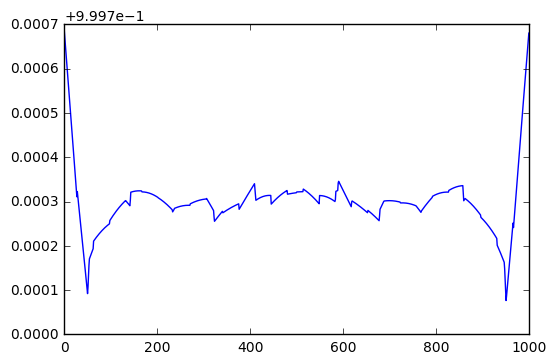

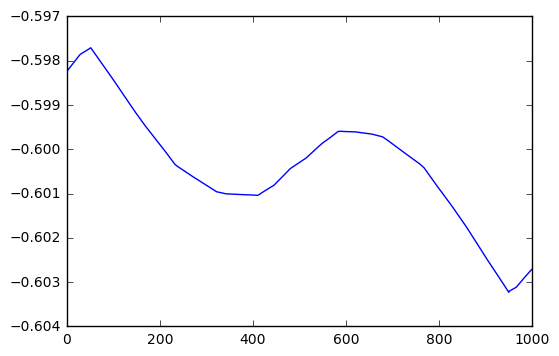

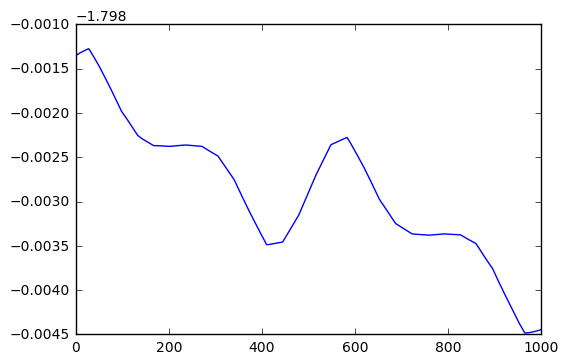

5


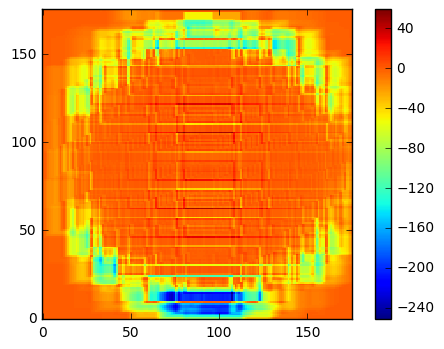

23475.6207796
23473.7125245 6.25e-12 0
23473.7125245
23470.6784345 1.0000000000000001e-11 1
23470.6784345
23465.8381173 1.6000000000000003e-11 2
23465.8381173
23458.1198337 2.5600000000000007e-11 3
23458.1198337
23445.8172717 4.096000000000001e-11 4
23445.8172717
23426.3305731 6.553600000000002e-11 5
23426.3305731
23418.4015694 1.0485760000000004e-10 6
23418.4015694
36121.9918058 1.6777216000000006e-10 7
23418.4015694
25866.0424094 -3.3554432000000015e-11 8
23418.4015694
23393.1780597 6.710886400000003e-12 9
23393.1780597
23389.861255 1.0737418240000006e-11 10
23389.861255
23384.8055083 1.717986918400001e-11 11
23384.8055083
23377.1911854 2.748779069440002e-11 12
23377.1911854
23381.2045939 4.398046511104004e-11 13
23377.1911854
23612.7977734 -8.796093022208007e-12 14
23377.1911854
23376.4104065 1.7592186044416015e-12 15
23376.4104065
23375.3714939 2.8147497671065625e-12 16
23375.3714939
23373.9453324 4.5035996273705e-12 17
23373.9453324
23371.80422 7.205759403792801e-12 18
23371.80422

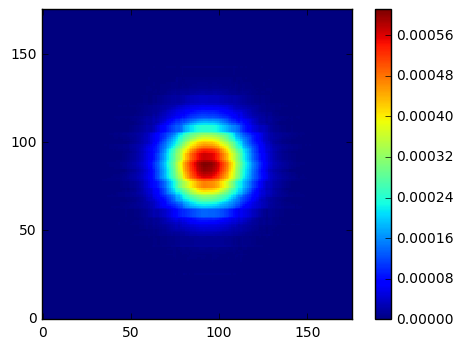

100%|██████████| 1000/1000 [01:28<00:00,  8.35it/s]


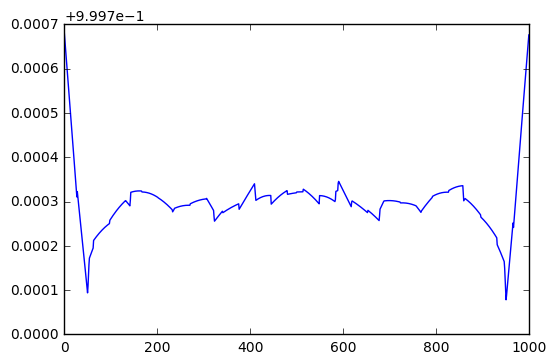

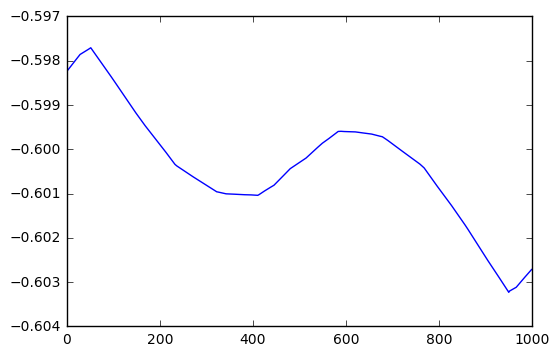

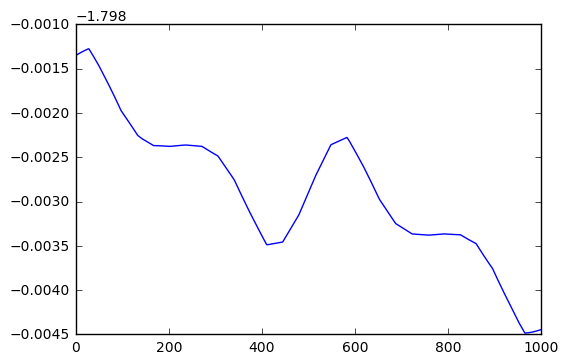

6


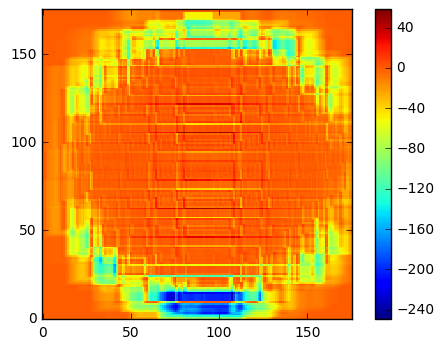

23027.0174952
23025.1611413 6.25e-12 0
23025.1611413
23022.2093371 1.0000000000000001e-11 1
23022.2093371
23017.5000894 1.6000000000000003e-11 2
23017.5000894
23009.9904713 2.5600000000000007e-11 3
23009.9904713
22998.0200252 4.096000000000001e-11 4
22998.0200252
22979.0572154 6.553600000000002e-11 5
22979.0572154
22971.0410165 1.0485760000000004e-10 6
22971.0410165
35170.0615184 1.6777216000000006e-10 7
22971.0410165
25359.2184869 -3.3554432000000015e-11 8
22971.0410165
22946.7974484 6.710886400000003e-12 9
22946.7974484
22943.5715561 1.0737418240000006e-11 10
22943.5715561
22938.6518292 1.717986918400001e-11 11
22938.6518292
22931.2415345 2.748779069440002e-11 12
22931.2415345
22935.1471123 4.398046511104004e-11 13
22931.2415345
23162.6830114 -8.796093022208007e-12 14
22931.2415345
22930.4820368 1.7592186044416015e-12 15
22930.4820368
22929.4714304 2.8147497671065625e-12 16
22929.4714304
22928.0839 4.5035996273705e-12 17
22928.0839
22926.0004752 7.205759403792801e-12 18
22926.0004752

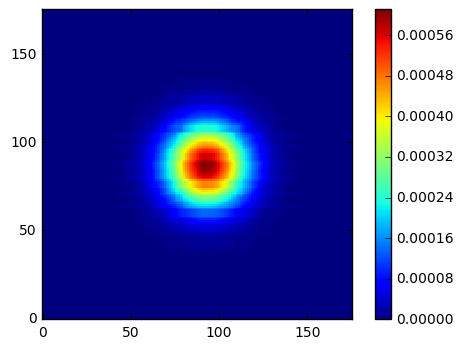

100%|██████████| 1000/1000 [01:27<00:00,  7.84it/s]


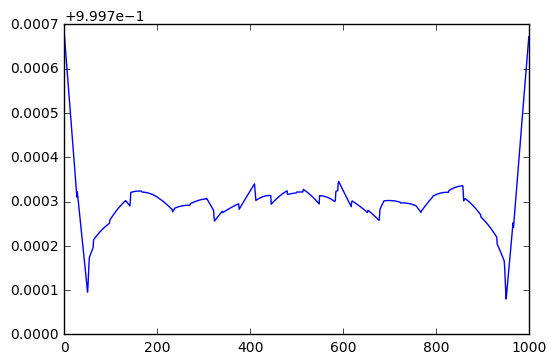

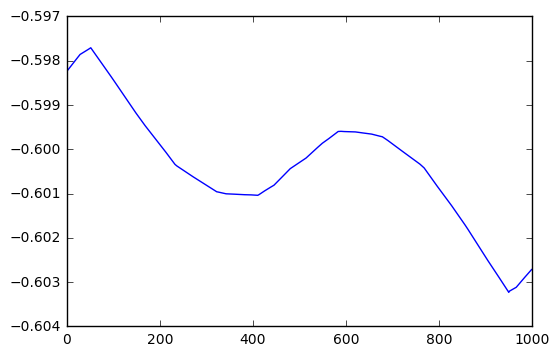

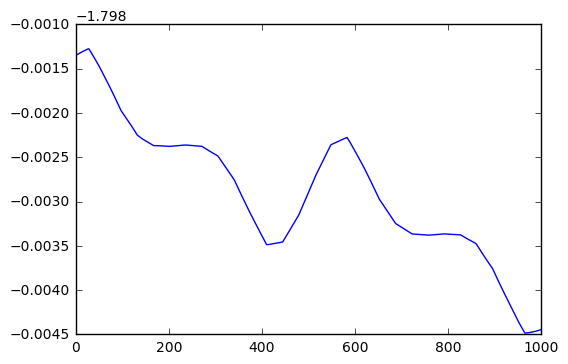

7


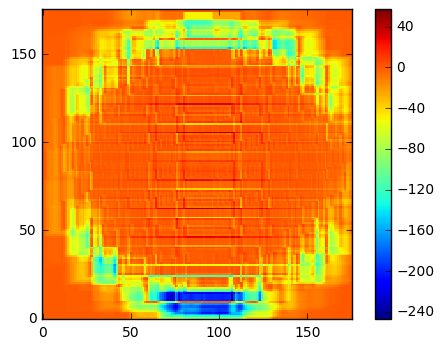

22590.4903857
22588.6840406 6.25e-12 0
22588.6840406
22585.8115538 1.0000000000000001e-11 1
22585.8115538
22581.2289743 1.6000000000000003e-11 2
22581.2289743
22573.9210607 2.5600000000000007e-11 3
22573.9210607
22562.2716562 4.096000000000001e-11 4
22562.2716562
22543.8154725 6.553600000000002e-11 5
22543.8154725
22535.7164491 1.0485760000000004e-10 6
22535.7164491
34223.8965757 1.6777216000000006e-10 7
22535.7164491
24863.5121805 -3.3554432000000015e-11 8
22535.7164491
22512.4185756 6.710886400000003e-12 9
22512.4185756
22509.2797517 1.0737418240000006e-11 10
22509.2797517
22504.4907467 1.717986918400001e-11 11
22504.4907467
22497.2666766 2.748779069440002e-11 12
22497.2666766
22500.6145289 4.398046511104004e-11 13
22497.2666766
22724.4339508 -8.796093022208007e-12 14
22497.2666766
22496.5336679 1.7592186044416015e-12 15
22496.5336679
22495.5547033 2.8147497671065625e-12 16
22495.5547033
22494.2061363 4.5035996273705e-12 17
22494.2061363
22492.1785068 7.205759403792801e-12 18
22492.1

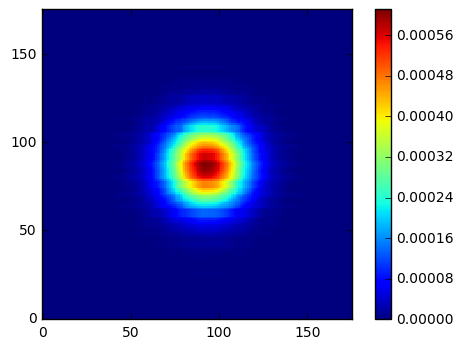

100%|██████████| 1000/1000 [01:27<00:00,  8.04it/s]


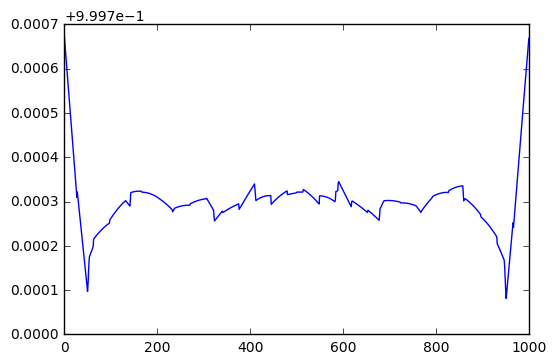

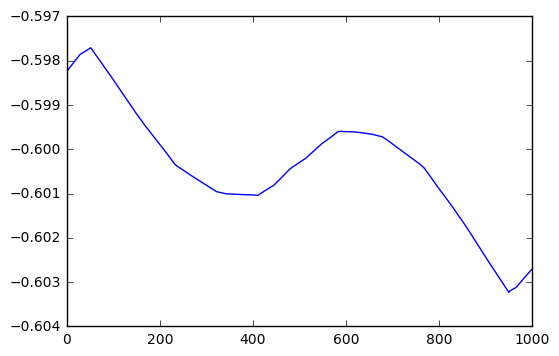

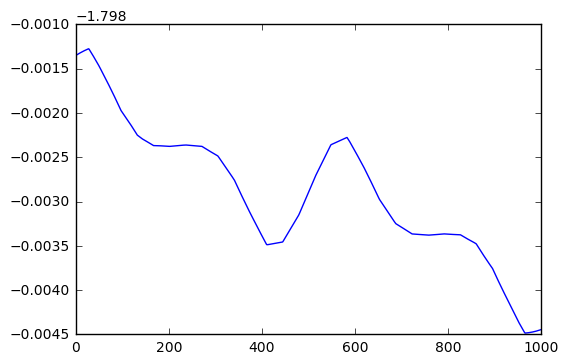

8


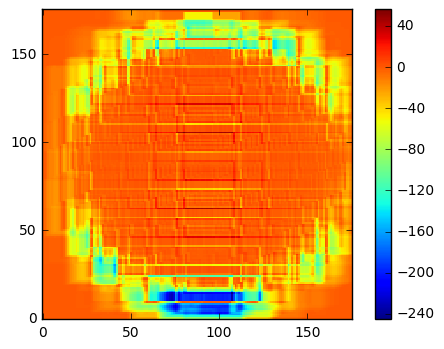

22165.5937434
22163.8361244 6.25e-12 0
22163.8361244
22161.0409262 1.0000000000000001e-11 1
22161.0409262
22156.5811862 1.6000000000000003e-11 2
22156.5811862
22149.468878 2.5600000000000007e-11 3
22149.468878
22138.1308994 4.096000000000001e-11 4
22138.1308994
22120.1679808 6.553600000000002e-11 5
22120.1679808
22112.1566301 1.0485760000000004e-10 6
22112.1566301
33451.3931241 1.6777216000000006e-10 7
22112.1566301
24388.9804377 -3.3554432000000015e-11 8
22112.1566301
22089.6105125 6.710886400000003e-12 9
22089.6105125
22086.5581559 1.0737418240000006e-11 10
22086.5581559
22081.8981709 1.717986918400001e-11 11
22081.8981709
22074.8786587 2.748779069440002e-11 12
22074.8786587
22078.6310898 4.398046511104004e-11 13
22074.8786587
22297.9829107 -8.796093022208007e-12 14
22074.8786587
22074.1590404 1.7592186044416015e-12 15
22074.1590404
22073.2018835 2.8147497671065625e-12 16
22073.2018835
22071.8879218 4.5035996273705e-12 17
22071.8879218
22069.9145531 7.205759403792801e-12 18
22069.914

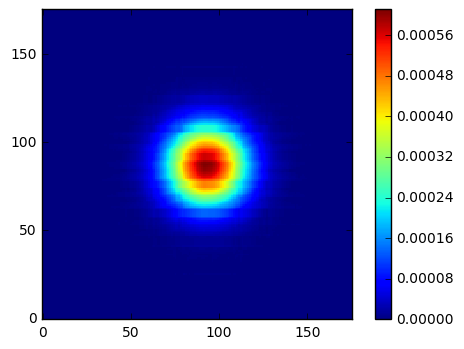

100%|██████████| 1000/1000 [01:26<00:00,  8.82it/s]


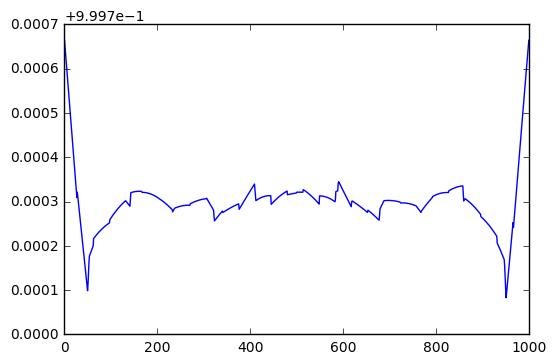

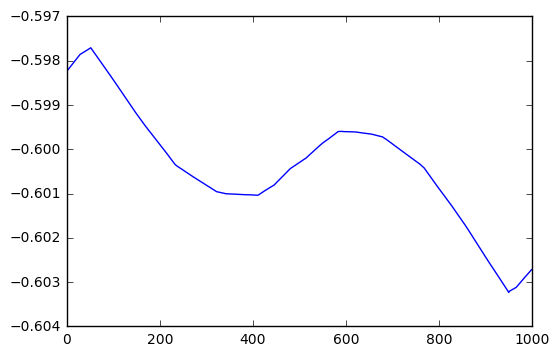

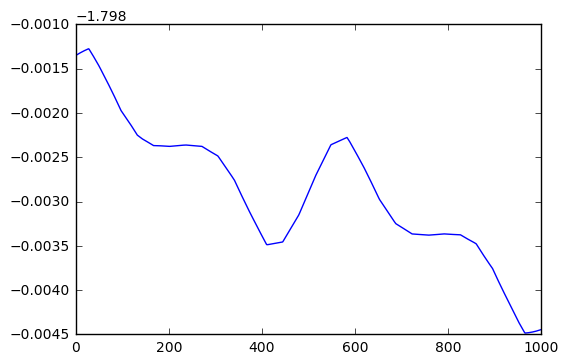

9


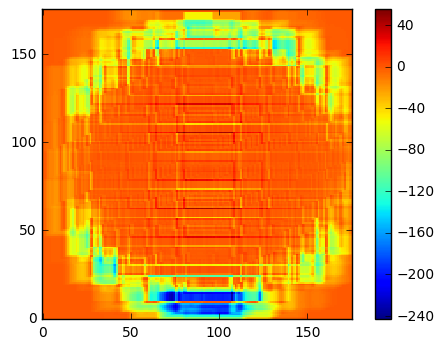

21752.0103442
21750.2989878 6.25e-12 0
21750.2989878
21747.5772023 1.0000000000000001e-11 1
21747.5772023
21743.234433 1.6000000000000003e-11 2
21743.234433
21736.3084025 2.5600000000000007e-11 3
21736.3084025
21725.266997 4.096000000000001e-11 4
21725.266997
21707.7733201 6.553600000000002e-11 5
21707.7733201
21699.9332655 1.0485760000000004e-10 6
21699.9332655
32698.3398531 1.6777216000000006e-10 7
21699.9332655
23926.8912742 -3.3554432000000015e-11 8
21699.9332655
21678.0125022 6.710886400000003e-12 9
21678.0125022
21675.0392761 1.0737418240000006e-11 10
21675.0392761
21670.4995536 1.717986918400001e-11 11
21670.4995536
21663.6518202 2.748779069440002e-11 12
21663.6518202
21666.8840938 4.398046511104004e-11 13
21663.6518202
21882.7045679 -8.796093022208007e-12 14
21663.6518202
21662.9567227 1.7592186044416015e-12 15
21662.9567227
21662.028725 2.8147497671065625e-12 16
21662.028725
21660.7506388 4.5035996273705e-12 17
21660.7506388
21658.8287062 7.205759403792801e-12 18
21658.8287062

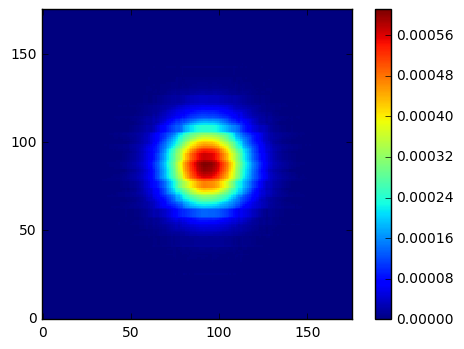

100%|██████████| 1000/1000 [01:26<00:00,  8.06it/s]


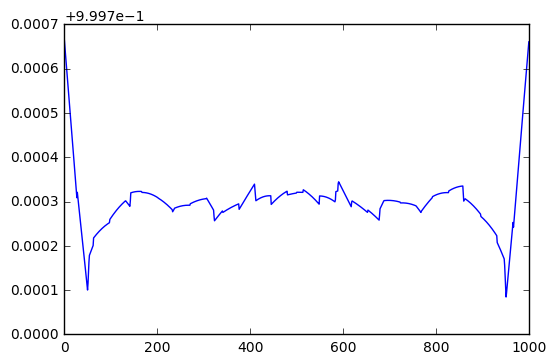

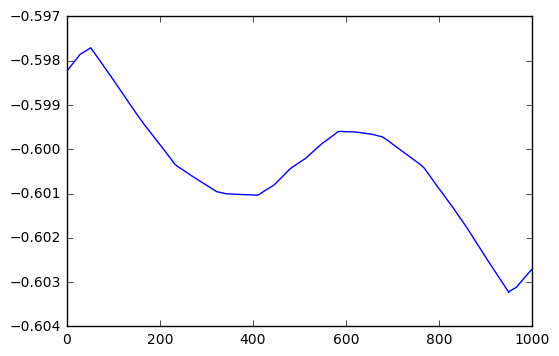

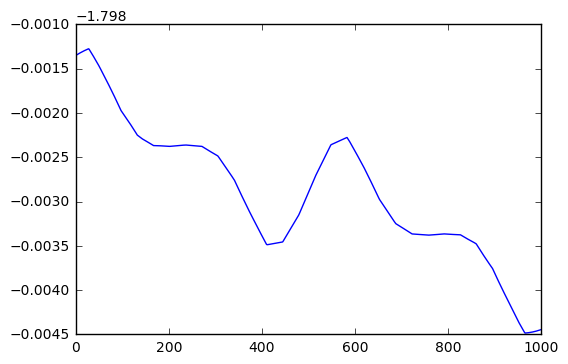

10


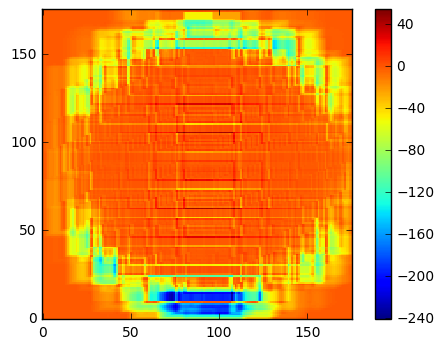

21349.1888844
21347.522794 6.25e-12 0
21347.522794
21344.8728259 1.0000000000000001e-11 1
21344.8728259
21340.6445019 1.6000000000000003e-11 2
21340.6445019
21333.9007511 2.5600000000000007e-11 3
21333.9007511
21323.1495449 4.096000000000001e-11 4
21323.1495449
21306.113992 6.553600000000002e-11 5
21306.113992
21298.2925376 1.0485760000000004e-10 6
21298.2925376
31911.7567244 1.6777216000000006e-10 7
21298.2925376
23474.3535514 -3.3554432000000015e-11 8
21298.2925376
21277.1396855 6.710886400000003e-12 9
21277.1396855
21274.2463903 1.0737418240000006e-11 10
21274.2463903
21269.8270718 1.717986918400001e-11 11
21269.8270718
21263.164013 2.748779069440002e-11 12
21263.164013
21266.4884905 4.398046511104004e-11 13
21263.164013
21478.3246428 -8.796093022208007e-12 14
21263.164013
21262.4852125 1.7592186044416015e-12 15
21262.4852125
21261.580367 2.8147497671065625e-12 16
21261.580367
21260.335674 4.5035996273705e-12 17
21260.335674
21258.4645725 7.205759403792801e-12 18
21258.4645725
21255

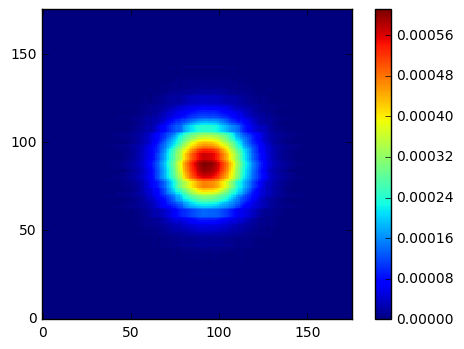

100%|██████████| 1000/1000 [01:26<00:00,  8.78it/s]


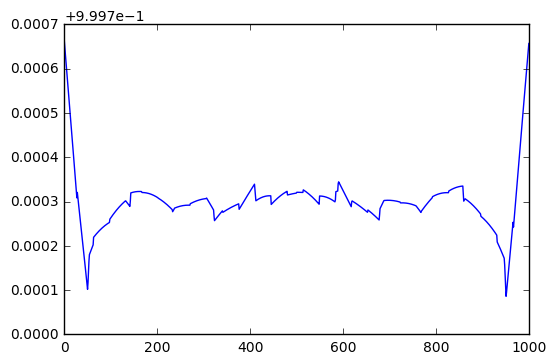

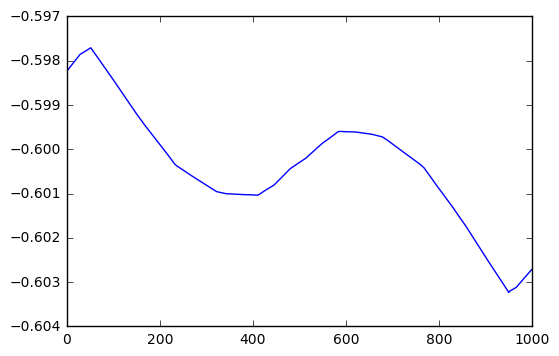

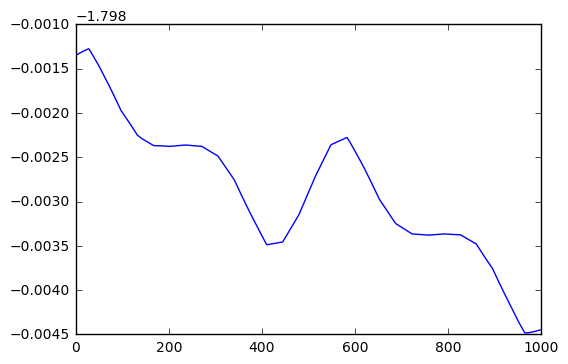

11


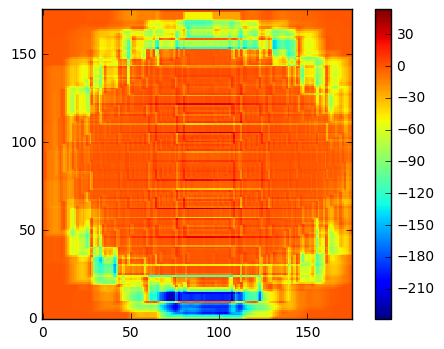

20956.9734154
20955.3509093 6.25e-12 0
20955.3509093
20952.7700827 1.0000000000000001e-11 1
20952.7700827
20948.6519398 1.6000000000000003e-11 2
20948.6519398
20942.0836885 2.5600000000000007e-11 3
20942.0836885
20931.6119181 4.096000000000001e-11 4
20931.6119181
20915.016849 6.553600000000002e-11 5
20915.016849
20907.2143182 1.0485760000000004e-10 6
20907.2143182
31139.4548438 1.6777216000000006e-10 7
20907.2143182
23032.8015769 -3.3554432000000015e-11 8
20907.2143182
20886.7857851 6.710886400000003e-12 9
20886.7857851
20883.9675869 1.0737418240000006e-11 10
20883.9675869
20879.6610224 1.717986918400001e-11 11
20879.6610224
20873.1612566 2.748779069440002e-11 12
20873.1612566
20876.1326205 4.398046511104004e-11 13
20873.1612566
21084.4501849 -8.796093022208007e-12 14
20873.1612566
20872.503609 1.7592186044416015e-12 15
20872.503609
20871.624863 2.8147497671065625e-12 16
20871.624863
20870.4133078 4.5035996273705e-12 17
20870.4133078
20868.5903126 7.205759403792801e-12 18
20868.5903126

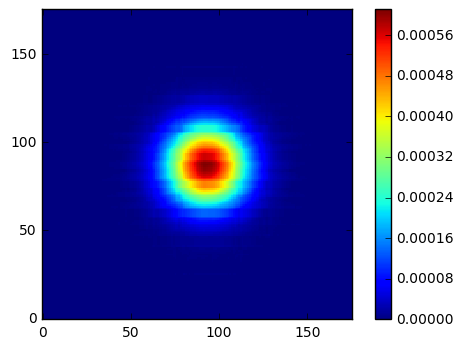

100%|██████████| 1000/1000 [01:25<00:00,  7.73it/s]


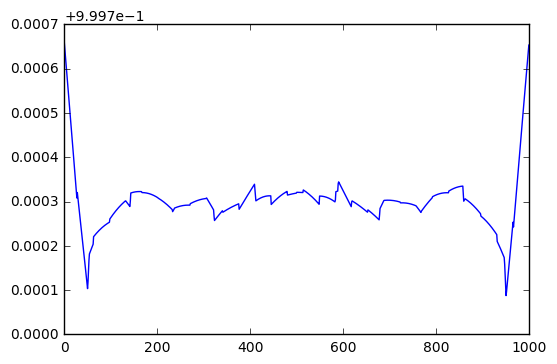

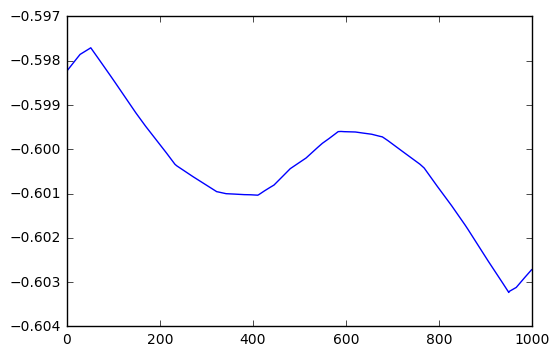

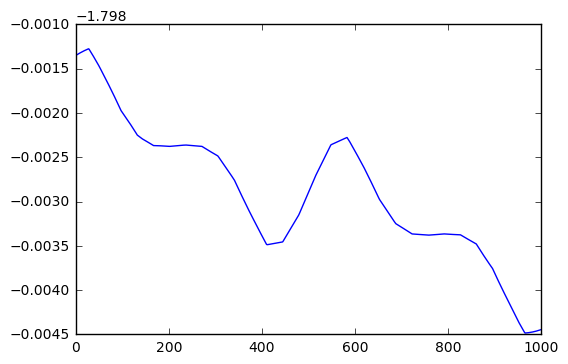

12


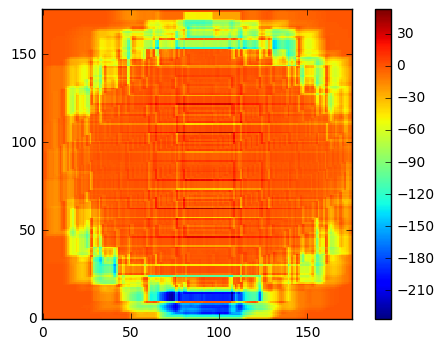

20574.833823
20573.2533712 6.25e-12 0
20573.2533712
20570.7392513 1.0000000000000001e-11 1
20570.7392513
20566.7274039 1.6000000000000003e-11 2
20566.7274039
20560.32844 2.5600000000000007e-11 3
20560.32844
20550.1261832 4.096000000000001e-11 4
20550.1261832
20533.9562595 6.553600000000002e-11 5
20533.9562595
20526.0650282 1.0485760000000004e-10 6
20526.0650282
30336.1359713 1.6777216000000006e-10 7
20526.0650282
22599.0752194 -3.3554432000000015e-11 8
20526.0650282
20506.4491646 6.710886400000003e-12 9
20506.4491646
20503.7050493 1.0737418240000006e-11 10
20503.7050493
20499.5087653 1.717986918400001e-11 11
20499.5087653
20493.1709075 2.748779069440002e-11 12
20493.1709075
20495.9037839 4.398046511104004e-11 13
20493.1709075
20700.6389001 -8.796093022208007e-12 14
20493.1709075
20492.5325499 1.7592186044416015e-12 15
20492.5325499
20491.6782481 2.8147497671065625e-12 16
20491.6782481
20490.4986289 4.5035996273705e-12 17
20490.4986289
20488.7224848 7.205759403792801e-12 18
20488.722484

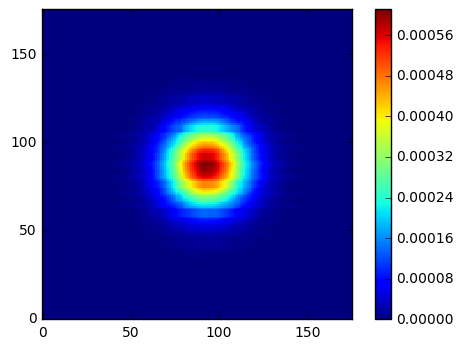

100%|██████████| 1000/1000 [01:25<00:00,  8.01it/s]


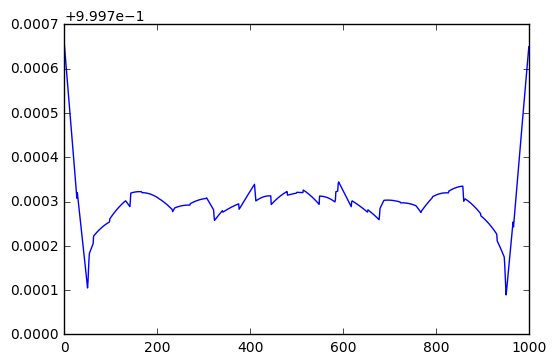

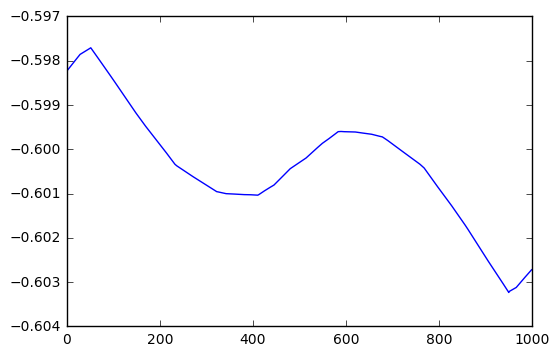

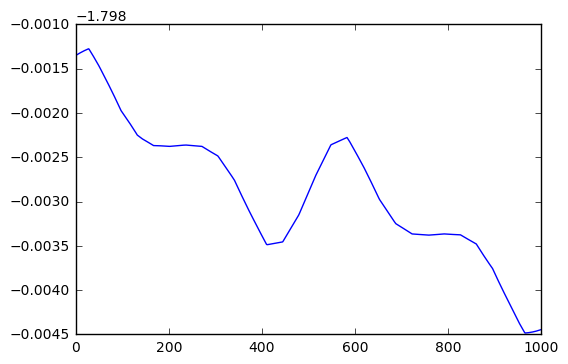

13


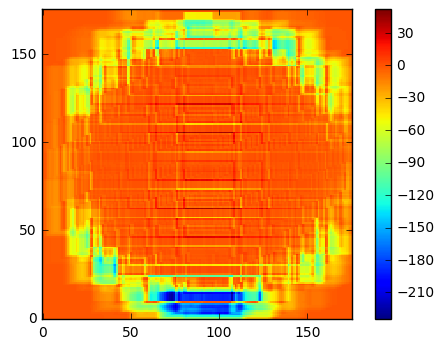

20202.4673087
20200.9273847 6.25e-12 0
20200.9273847
20198.4775584 1.0000000000000001e-11 1
20198.4775584
20194.568176 1.6000000000000003e-11 2
20194.568176
20188.3324262 2.5600000000000007e-11 3
20188.3324262
20178.3900649 4.096000000000001e-11 4
20178.3900649
20162.6305129 6.553600000000002e-11 5
20162.6305129
20154.7153709 1.0485760000000004e-10 6
20154.7153709
29590.2070092 1.6777216000000006e-10 7
20154.7153709
22179.572842 -3.3554432000000015e-11 8
20154.7153709
20135.8223583 6.710886400000003e-12 9
20135.8223583
20133.1492063 1.0737418240000006e-11 10
20133.1492063
20129.0594653 1.717986918400001e-11 11
20129.0594653
20122.8812649 2.748779069440002e-11 12
20122.8812649
20125.5085414 4.398046511104004e-11 13
20122.8812649
20326.7168818 -8.796093022208007e-12 14
20122.8812649
20122.2597774 1.7592186044416015e-12 15
20122.2597774
20121.4276637 2.8147497671065625e-12 16
20121.4276637
20120.2782348 4.5035996273705e-12 17
20120.2782348
20118.5472292 7.205759403792801e-12 18
20118.5472

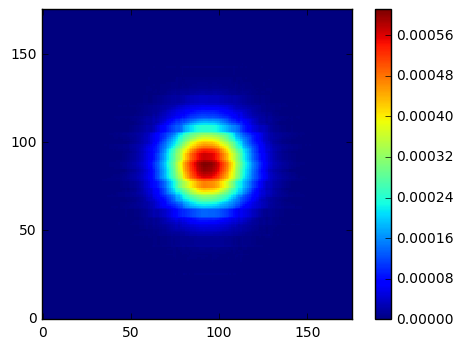

100%|██████████| 1000/1000 [01:24<00:00,  8.13it/s]


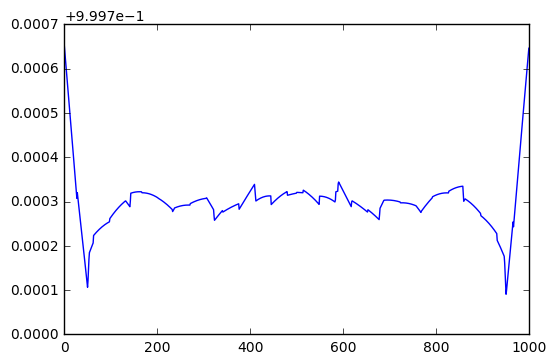

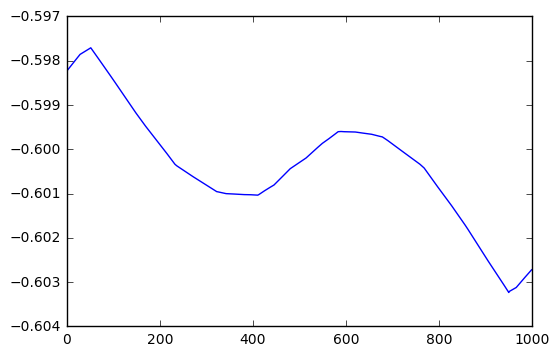

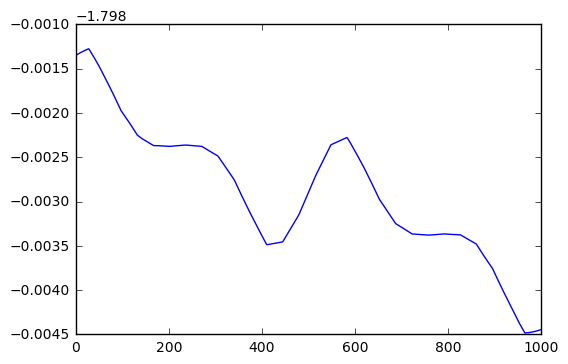

14


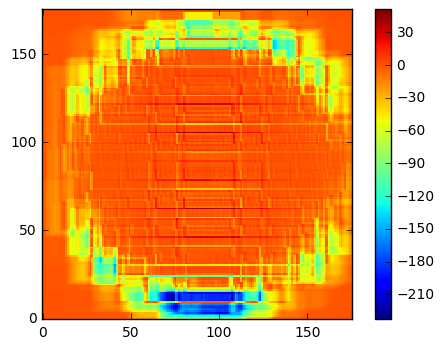

19839.5344749
19838.0337345 6.25e-12 0
19838.0337345
19835.6460824 1.0000000000000001e-11 1
19835.6460824
19831.8357873 1.6000000000000003e-11 2
19831.8357873
19825.7578777 2.5600000000000007e-11 3
19825.7578777
19816.0668587 4.096000000000001e-11 4
19816.0668587
19800.7044922 6.553600000000002e-11 5
19800.7044922
19792.837441 1.0485760000000004e-10 6
19792.837441
28908.0028927 1.6777216000000006e-10 7
19792.837441
21773.1187357 -3.3554432000000015e-11 8
19792.837441
19774.5721337 6.710886400000003e-12 9
19774.5721337
19771.9675117 1.0737418240000006e-11 10
19771.9675117
19767.9806927 1.717986918400001e-11 11
19767.9806927
19761.9564387 2.748779069440002e-11 12
19761.9564387
19764.4735971 4.398046511104004e-11 13
19761.9564387
19962.2846641 -8.796093022208007e-12 14
19761.9564387
19761.3514788 1.7592186044416015e-12 15
19761.3514788
19760.5410735 2.8147497671065625e-12 16
19760.5410735
19759.4209778 4.5035996273705e-12 17
19759.4209778
19757.7336399 7.205759403792801e-12 18
19757.73363

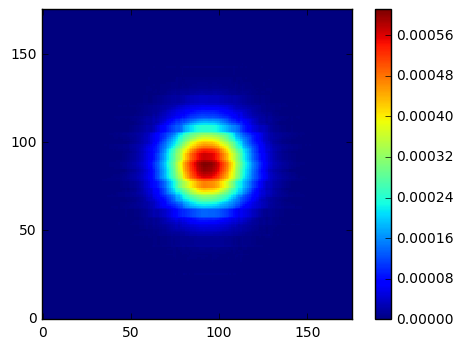

100%|██████████| 1000/1000 [01:24<00:00,  8.61it/s]


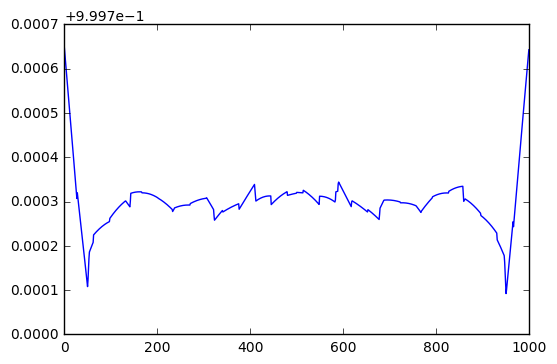

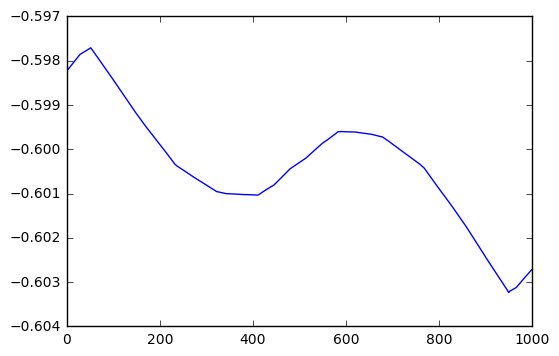

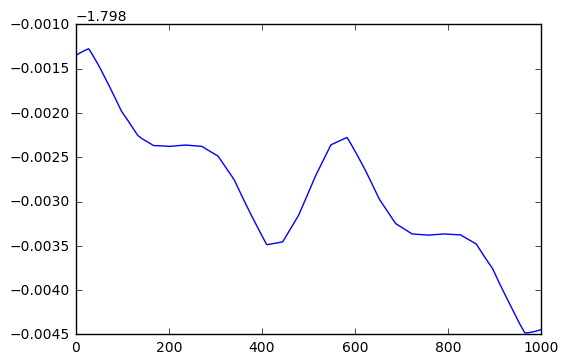

15


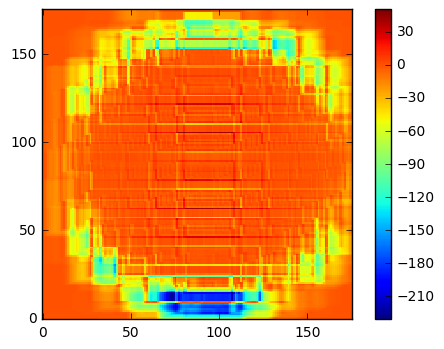

19485.7166908
19484.2536547 6.25e-12 0
19484.2536547
19481.9258314 1.0000000000000001e-11 1
19481.9258314
19478.2108846 1.6000000000000003e-11 2
19478.2108846
19472.2848618 2.5600000000000007e-11 3
19472.2848618
19462.8357767 4.096000000000001e-11 4
19462.8357767
19447.8558997 6.553600000000002e-11 5
19447.8558997
19440.0540941 1.0485760000000004e-10 6
19440.0540941
28259.8280988 1.6777216000000006e-10 7
19440.0540941
21377.2449539 -3.3554432000000015e-11 8
19440.0540941
19422.3739523 6.710886400000003e-12 9
19422.3739523
19419.8355099 1.0737418240000006e-11 10
19419.8355099
19415.9477329 1.717986918400001e-11 11
19415.9477329
19410.0702633 2.748779069440002e-11 12
19410.0702633
19412.4290778 4.398046511104004e-11 13
19410.0702633
19606.9449949 -8.796093022208007e-12 14
19410.0702633
19409.4819324 1.7592186044416015e-12 15
19409.4819324
19408.6929946 2.8147497671065625e-12 16
19408.6929946
19407.6014112 4.5035996273705e-12 17
19407.6014112
19405.9561693 7.205759403792801e-12 18
19405.9

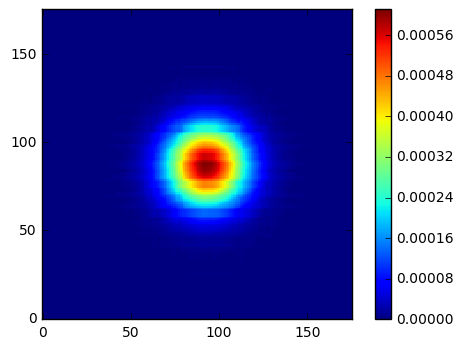

100%|██████████| 1000/1000 [01:24<00:00, 11.89it/s]


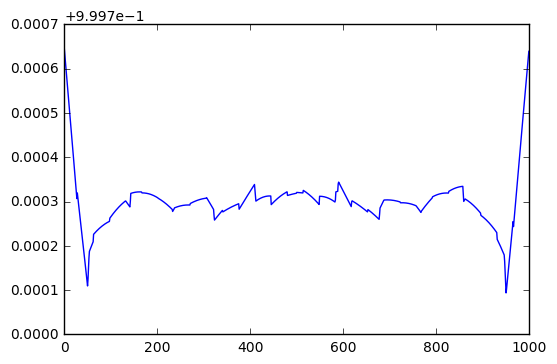

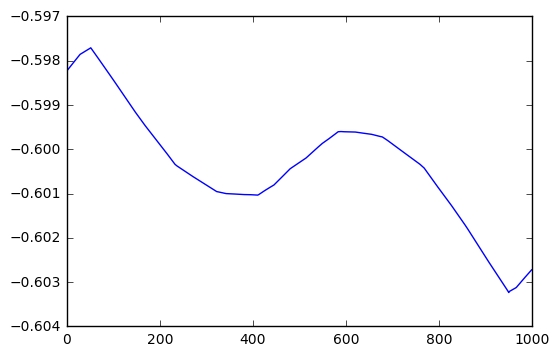

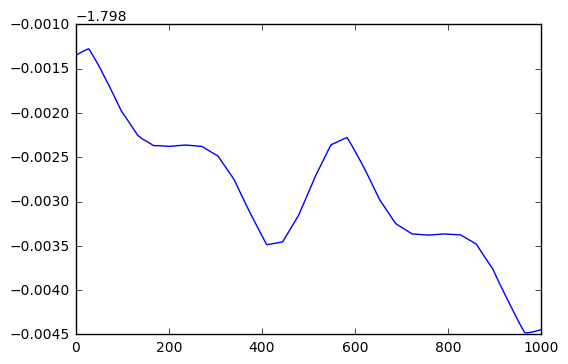

16


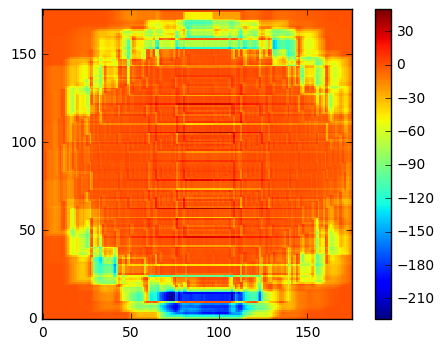

19140.6603711
19139.2336265 6.25e-12 0
19139.2336265
19136.9633959 1.0000000000000001e-11 1
19136.9633959
19133.340246 1.6000000000000003e-11 2
19133.340246
19127.5604648 2.5600000000000007e-11 3
19127.5604648
19118.3442354 4.096000000000001e-11 4
19118.3442354
19103.7322489 6.553600000000002e-11 5
19103.7322489
19095.9151573 1.0485760000000004e-10 6
19095.9151573
27569.7440137 1.6777216000000006e-10 7
19095.9151573
20987.9337173 -3.3554432000000015e-11 8
19095.9151573
19078.8779048 6.710886400000003e-12 9
19078.8779048
19076.4020145 1.0737418240000006e-11 10
19076.4020145
19072.6095985 1.717986918400001e-11 11
19072.6095985
19066.8711546 2.748779069440002e-11 12
19066.8711546
19068.9729865 4.398046511104004e-11 13
19066.8711546
19260.2516354 -8.796093022208007e-12 14
19066.8711546
19066.3001858 1.7592186044416015e-12 15
19066.3001858
19065.5328813 2.8147497671065625e-12 16
19065.5328813
19064.4690832 4.5035996273705e-12 17
19064.4690832
19062.8644048 7.205759403792801e-12 18
19062.864

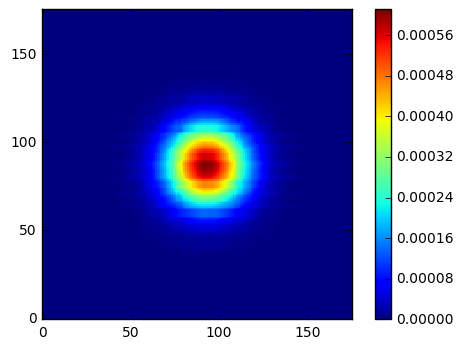

100%|██████████| 1000/1000 [01:24<00:00,  8.34it/s]


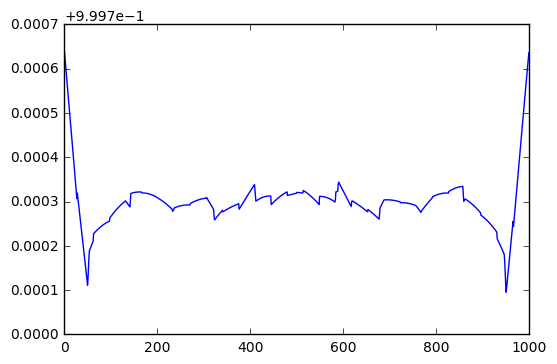

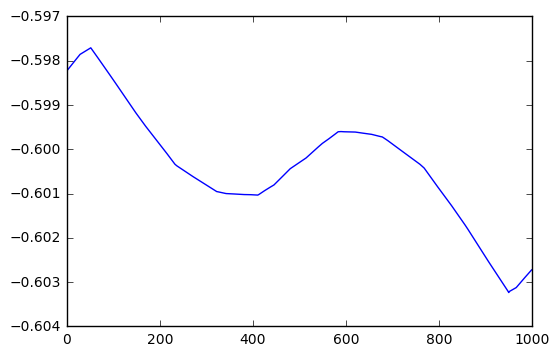

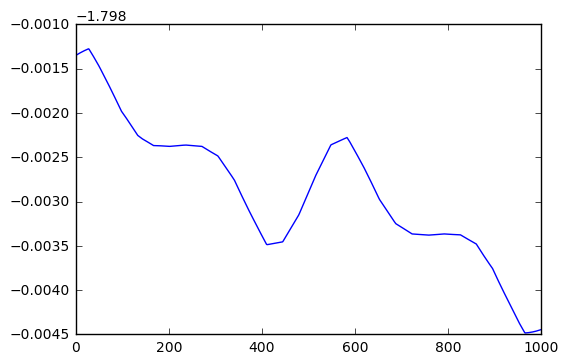

17


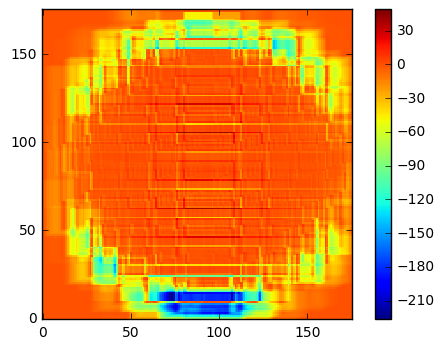

18804.0572776
18802.6656371 6.25e-12 0
18802.6656371
18800.4511108 1.0000000000000001e-11 1
18800.4511108
18796.9167452 1.6000000000000003e-11 2
18796.9167452
18791.2784006 2.5600000000000007e-11 3
18791.2784006
18782.2874192 4.096000000000001e-11 4
18782.2874192
18768.0312062 6.553600000000002e-11 5
18768.0312062
18760.1955579 1.0485760000000004e-10 6
18760.1955579
26908.4295973 1.6777216000000006e-10 7
18760.1955579
20607.955094 -3.3554432000000015e-11 8
18760.1955579
18743.7829261 6.710886400000003e-12 9
18743.7829261
18741.3686462 1.0737418240000006e-11 10
18741.3686462
18737.668438 1.717986918400001e-11 11
18737.668438
18732.0649216 2.748779069440002e-11 12
18732.0649216
18733.9337343 4.398046511104004e-11 13
18732.0649216
18921.9970104 -8.796093022208007e-12 14
18732.0649216
18731.5105316 1.7592186044416015e-12 15
18731.5105316
18730.763952 2.8147497671065625e-12 16
18730.763952
18729.7269745 4.5035996273705e-12 17
18729.7269745
18728.1615186 7.205759403792801e-12 18
18728.161518

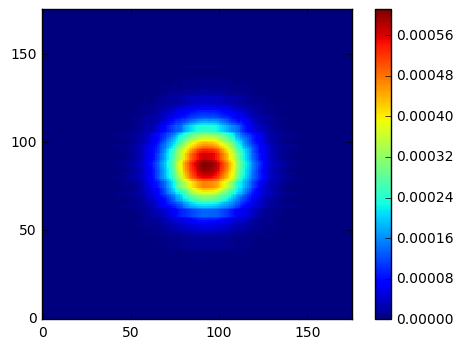

100%|██████████| 1000/1000 [01:23<00:00,  9.32it/s]


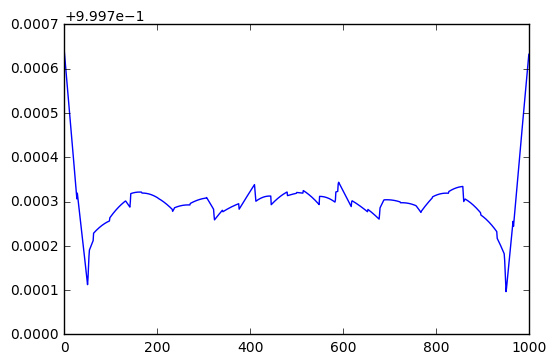

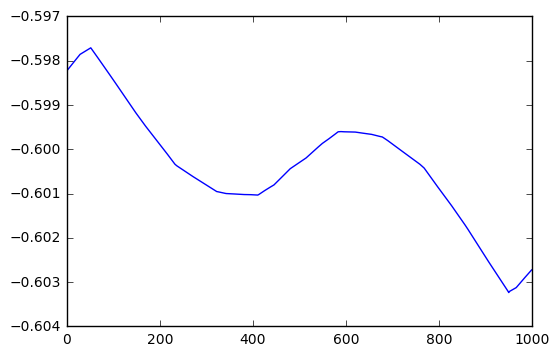

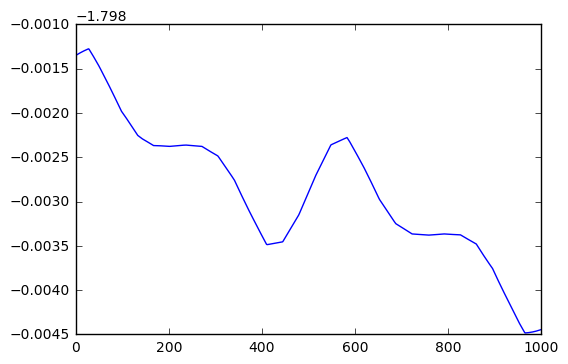

18


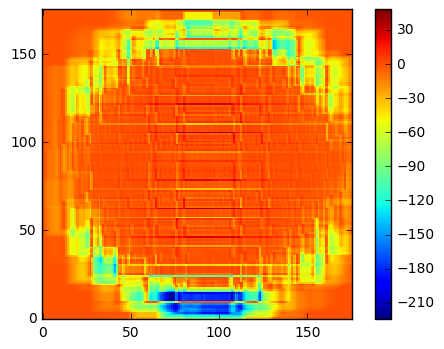

18475.6948753
18474.337521 6.25e-12 0
18474.337521
18472.1774176 1.0000000000000001e-11 1
18472.1774176
18468.7298133 1.6000000000000003e-11 2
18468.7298133
18463.2297304 2.5600000000000007e-11 3
18463.2297304
18454.4590121 4.096000000000001e-11 4
18454.4590121
18440.5510998 6.553600000000002e-11 5
18440.5510998
18432.7696148 1.0485760000000004e-10 6
18432.7696148
26312.052076 1.6777216000000006e-10 7
18432.7696148
20239.1483153 -3.3554432000000015e-11 8
18432.7696148
18416.8954814 6.710886400000003e-12 9
18416.8954814
18414.5414765 1.0737418240000006e-11 10
18414.5414765
18410.9318181 1.717986918400001e-11 11
18410.9318181
18405.4662379 2.748779069440002e-11 12
18405.4662379
18407.3600971 4.398046511104004e-11 13
18405.4662379
18591.9658339 -8.796093022208007e-12 14
18405.4662379
18404.9247109 1.7592186044416015e-12 15
18404.9247109
18404.1959962 2.8147497671065625e-12 16
18404.1959962
18403.1843155 4.5035996273705e-12 17
18403.1843155
18401.6571463 7.205759403792801e-12 18
18401.6571

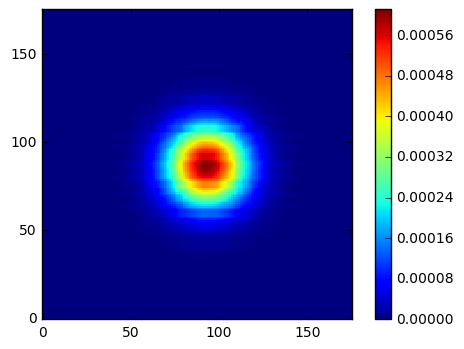

100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


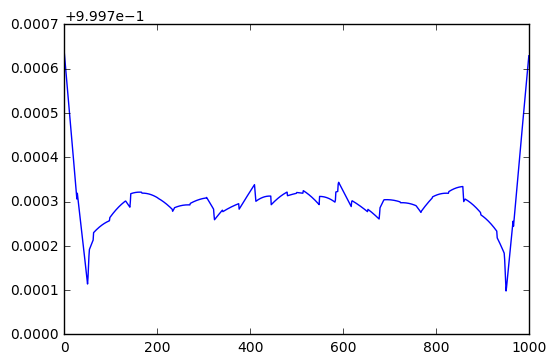

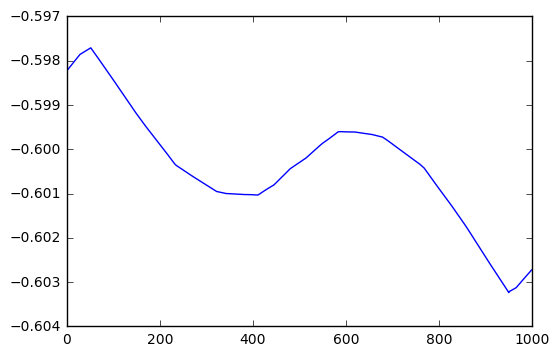

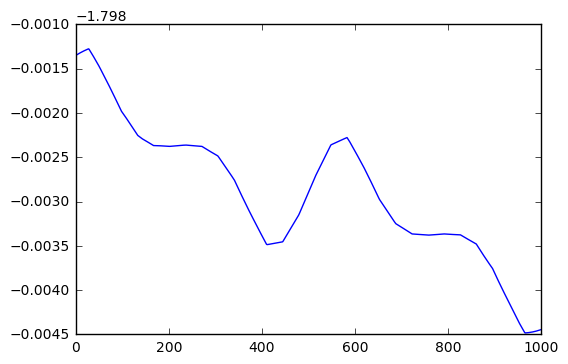

19


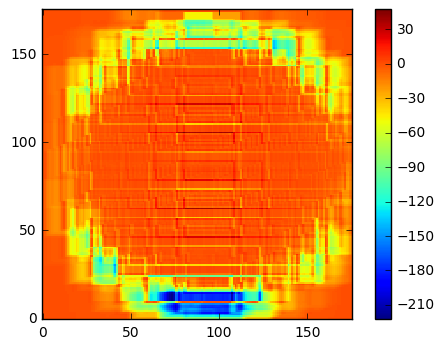

18155.2913147
18153.9667339 6.25e-12 0
18153.9667339
18151.8586535 1.0000000000000001e-11 1
18151.8586535
18148.4939743 1.6000000000000003e-11 2
18148.4939743
18143.1260124 2.5600000000000007e-11 3
18143.1260124
18134.5657411 4.096000000000001e-11 4
18134.5657411
18120.9905243 6.553600000000002e-11 5
18120.9905243
18113.2314755 1.0485760000000004e-10 6
18113.2314755
25701.3027858 1.6777216000000006e-10 7
18113.2314755
19877.9926836 -3.3554432000000015e-11 8
18113.2314755
18097.9011721 6.710886400000003e-12 9
18097.9011721
18095.6044206 1.0737418240000006e-11 10
18095.6044206
18092.0807933 1.717986918400001e-11 11
18092.0807933
18086.7372805 2.748779069440002e-11 12
18086.7372805
18088.2395336 4.398046511104004e-11 13
18086.7372805
18269.829865 -8.796093022208007e-12 14
18086.7372805
18086.2134335 1.7592186044416015e-12 15
18086.2134335
18085.5057124 2.8147497671065625e-12 16
18085.5057124
18084.519676 4.5035996273705e-12 17
18084.519676
18083.0291961 7.205759403792801e-12 18
18083.0291

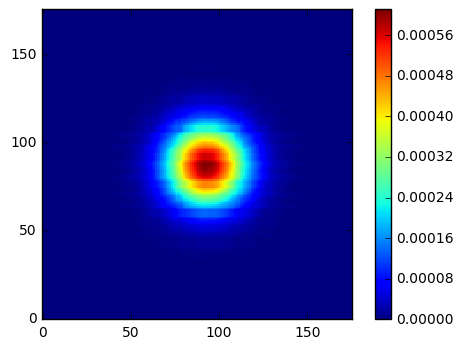

100%|██████████| 1000/1000 [01:21<00:00,  9.55it/s]


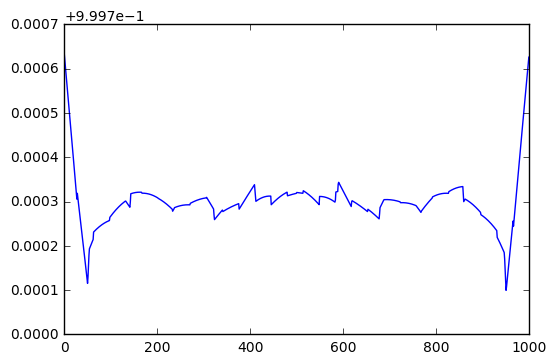

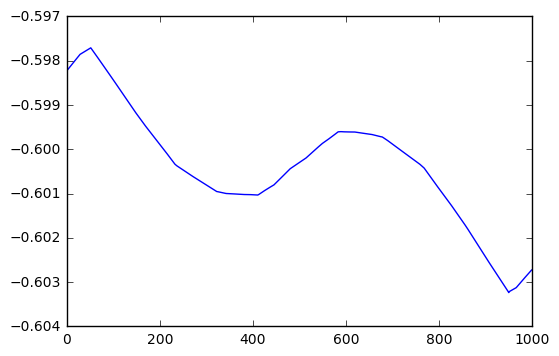

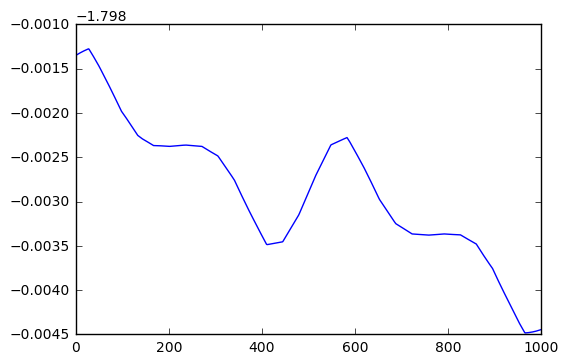

20


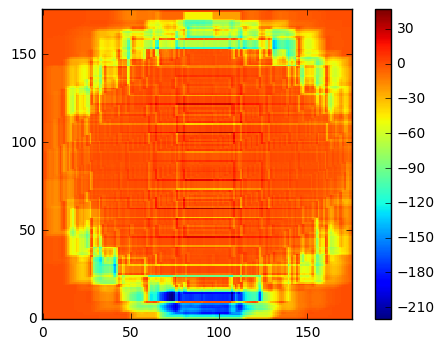

17842.5386225
17841.2457547 6.25e-12 0
17841.2457547
17839.1880064 1.0000000000000001e-11 1
17839.1880064
17835.9035699 1.6000000000000003e-11 2
17835.9035699
17830.6635045 2.5600000000000007e-11 3
17830.6635045
17822.3070477 4.096000000000001e-11 4
17822.3070477
17809.0535789 6.553600000000002e-11 5
17809.0535789
17801.2484103 1.0485760000000004e-10 6
17801.2484103
25084.3765185 1.6777216000000006e-10 7
17801.2484103
19524.1573092 -3.3554432000000015e-11 8
17801.2484103
17786.5156471 6.710886400000003e-12 9
17786.5156471
17784.2750681 1.0737418240000006e-11 10
17784.2750681
17780.8361439 1.717986918400001e-11 11
17780.8361439
17775.6214323 2.748779069440002e-11 12
17775.6214323
17777.1549449 4.398046511104004e-11 13
17775.6214323
17955.461349 -8.796093022208007e-12 14
17775.6214323
17775.1095336 1.7592186044416015e-12 15
17775.1095336
17774.4185011 2.8147497671065625e-12 16
17774.4185011
17773.4561191 4.5035996273705e-12 17
17773.4561191
17772.0013559 7.205759403792801e-12 18
17772.00

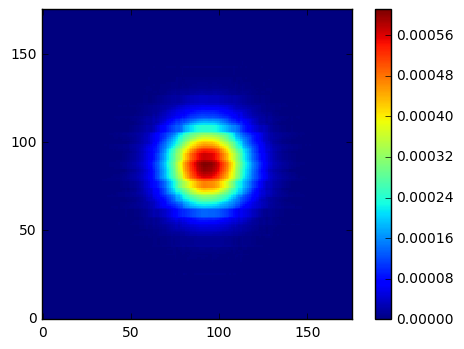

100%|██████████| 1000/1000 [01:22<00:00,  8.93it/s]


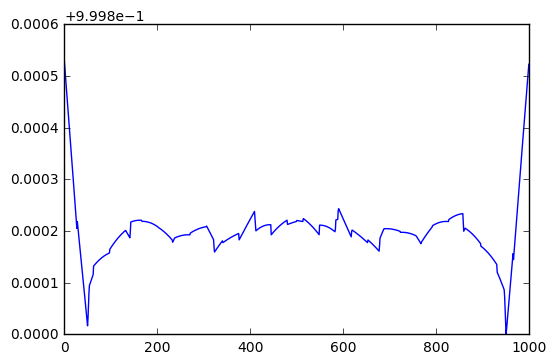

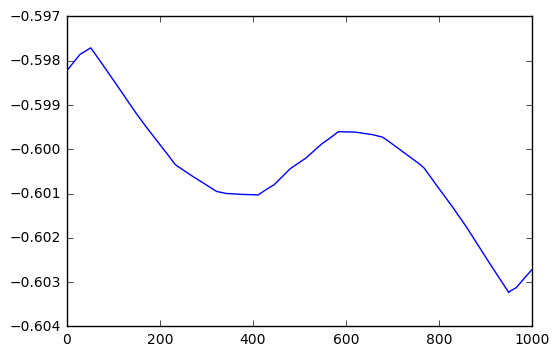

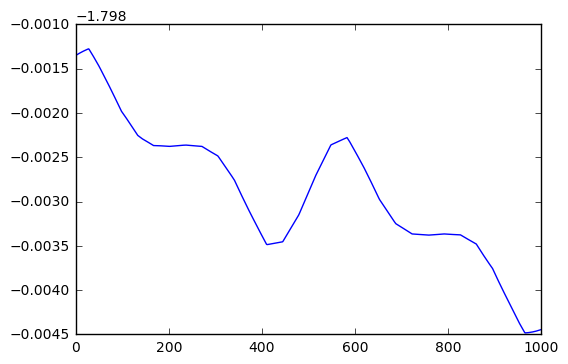

21


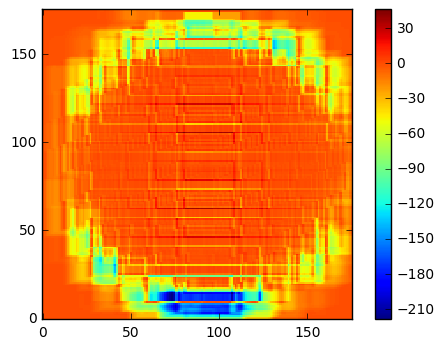

17537.2208532
17535.9587651 6.25e-12 0
17535.9587651
17533.9498982 1.0000000000000001e-11 1
17533.9498982
17530.7433972 1.6000000000000003e-11 2
17530.7433972
17525.6275112 2.5600000000000007e-11 3
17525.6275112
17517.4688408 4.096000000000001e-11 4
17517.4688408
17504.5286326 6.553600000000002e-11 5
17504.5286326
17496.8441537 1.0485760000000004e-10 6
17496.8441537
24570.306835 1.6777216000000006e-10 7
17496.8441537
19184.4938124 -3.3554432000000015e-11 8
17496.8441537
17482.5215948 6.710886400000003e-12 9
17482.5215948
17480.3339947 1.0737418240000006e-11 10
17480.3339947
17476.9753019 1.717986918400001e-11 11
17476.9753019
17471.8771553 2.748779069440002e-11 12
17471.8771553
17473.160524 4.398046511104004e-11 13
17471.8771553
17648.50309 -8.796093022208007e-12 14
17471.8771553
17471.3802841 1.7592186044416015e-12 15
17471.3802841
17470.7077395 2.8147497671065625e-12 16
17470.7077395
17469.7689335 4.5035996273705e-12 17
17469.7689335
17468.3484579 7.205759403792801e-12 18
17468.34845

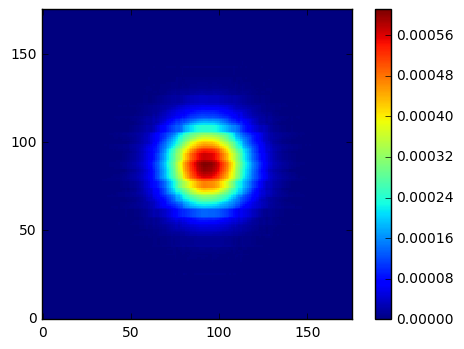

100%|██████████| 1000/1000 [01:21<00:00, 12.28it/s]


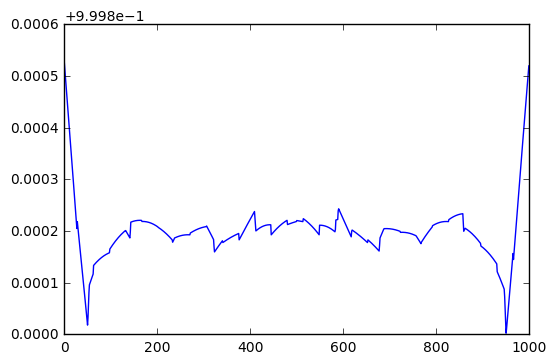

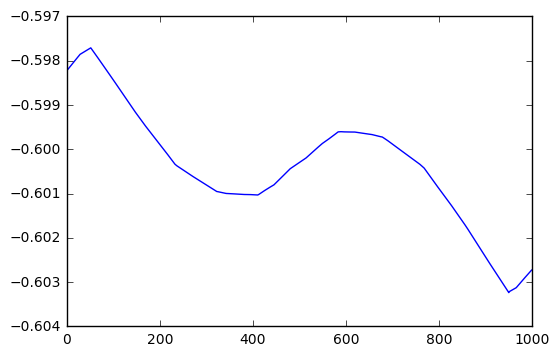

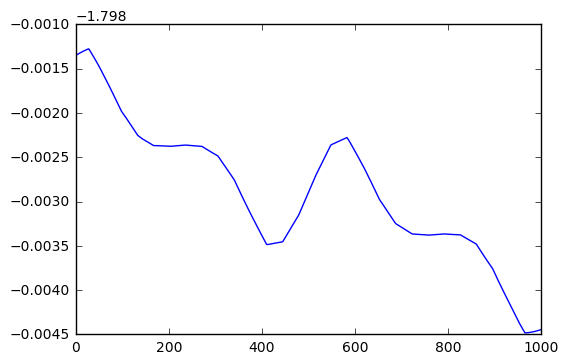

22


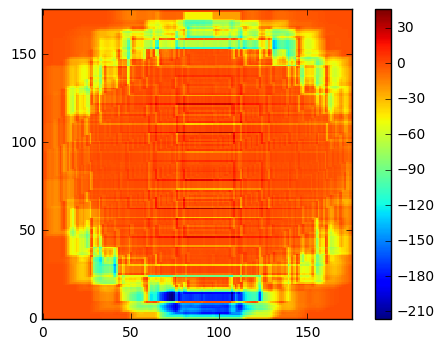

17239.113141
17237.8810492 6.25e-12 0
17237.8810492
17235.9198071 1.0000000000000001e-11 1
17235.9198071
17232.7892437 1.6000000000000003e-11 2
17232.7892437
17227.7943853 2.5600000000000007e-11 3
17227.7943853
17219.8285591 4.096000000000001e-11 4
17219.8285591
17207.1929688 6.553600000000002e-11 5
17207.1929688
17199.4762308 1.0485760000000004e-10 6
17199.4762308
23989.550362 1.6777216000000006e-10 7
17199.4762308
18847.7296562 -3.3554432000000015e-11 8
17199.4762308
17185.7045198 6.710886400000003e-12 9
17185.7045198
17183.5694782 1.0737418240000006e-11 10
17183.5694782
17180.2903917 1.717986918400001e-11 11
17180.2903917
17175.3119734 2.748779069440002e-11 12
17175.3119734
17176.5557678 4.398046511104004e-11 13
17175.3119734
17348.8231781 -8.796093022208007e-12 14
17175.3119734
17174.8273309 1.7592186044416015e-12 15
17174.8273309
17174.1711646 2.8147497671065625e-12 16
17174.1711646
17173.2549064 4.5035996273705e-12 17
17173.2549064
17171.8681587 7.205759403792801e-12 18
17171.868

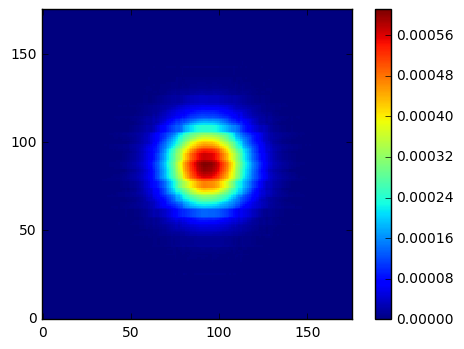

100%|██████████| 1000/1000 [01:22<00:00,  8.48it/s]


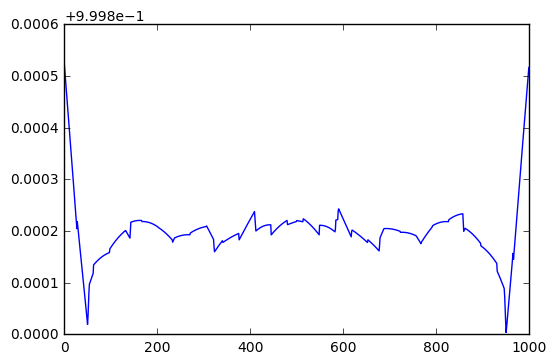

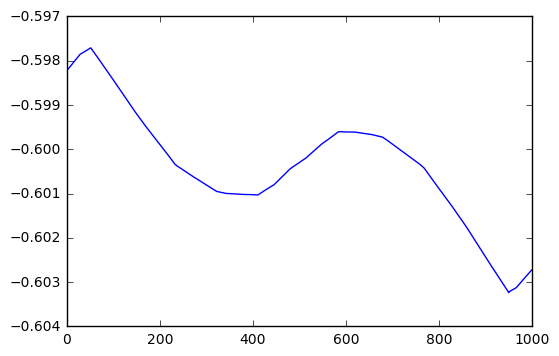

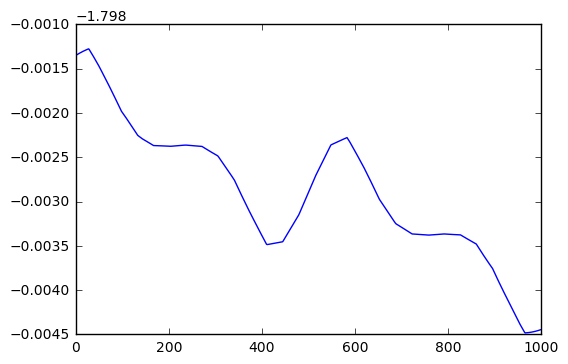

23


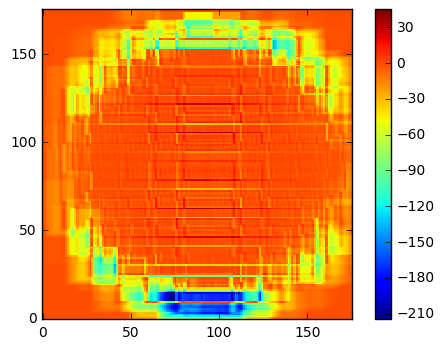

16948.0556803
16946.8528791 6.25e-12 0
16946.8528791
16944.9381621 1.0000000000000001e-11 1
16944.9381621
16941.8817851 1.6000000000000003e-11 2
16941.8817851
16937.0051721 2.5600000000000007e-11 3
16937.0051721
16929.227748 4.096000000000001e-11 4
16929.227748
16916.8941377 6.553600000000002e-11 5
16916.8941377
16909.3646433 1.0485760000000004e-10 6
16909.3646433
23536.6341993 1.6777216000000006e-10 7
16909.3646433
18525.0685913 -3.3554432000000015e-11 8
16909.3646433
16895.9230331 6.710886400000003e-12 9
16895.9230331
16893.8389573 1.0737418240000006e-11 10
16893.8389573
16890.6379105 1.717986918400001e-11 11
16890.6379105
16885.7745795 2.748779069440002e-11 12
16885.7745795
16886.845657 4.398046511104004e-11 13
16885.7745795
17056.1709176 -8.796093022208007e-12 14
16885.7745795
16885.303652 1.7592186044416015e-12 15
16885.303652
16884.6648531 2.8147497671065625e-12 16
16884.6648531
16883.7712624 4.5035996273705e-12 17
16883.7712624
16882.4178087 7.205759403792801e-12 18
16882.417808

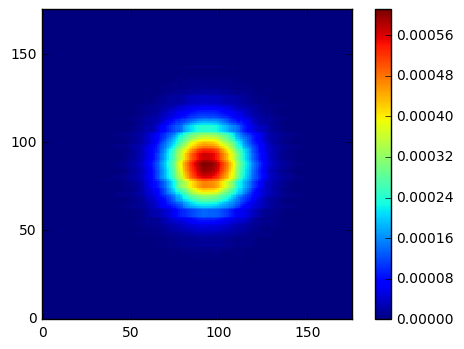

100%|██████████| 1000/1000 [01:22<00:00,  8.19it/s]


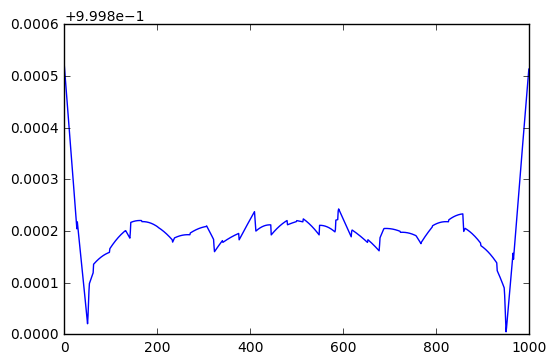

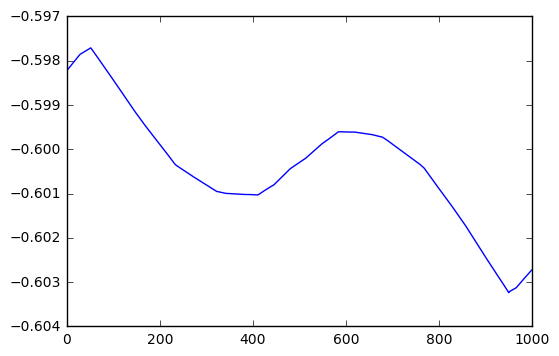

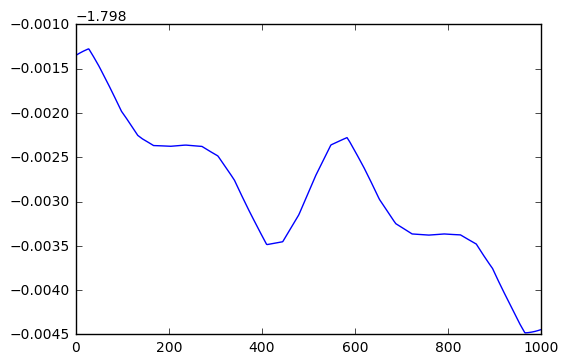

24


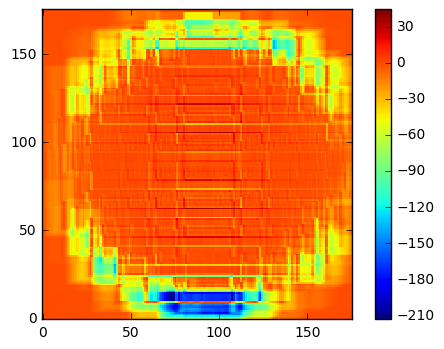

16663.9741583
16662.8006476 6.25e-12 0
16662.8006476
16660.9324497 1.0000000000000001e-11 1
16660.9324497
16657.9502551 1.6000000000000003e-11 2
16657.9502551
16653.1918899 2.5600000000000007e-11 3
16653.1918899
16645.6029019 4.096000000000001e-11 4
16645.6029019
16633.5650983 6.553600000000002e-11 5
16633.5650983
16626.0770752 1.0485760000000004e-10 6
16626.0770752
23025.8587861 1.6777216000000006e-10 7
16626.0770752
18206.164521 -3.3554432000000015e-11 8
16626.0770752
16613.0937579 6.710886400000003e-12 9
16613.0937579
16611.0606671 1.0737418240000006e-11 10
16611.0606671
16607.9360847 1.717986918400001e-11 11
16607.9360847
16603.1883255 2.748779069440002e-11 12
16603.1883255
16604.2502733 4.398046511104004e-11 13
16603.1883255
16770.5401222 -8.796093022208007e-12 14
16603.1883255
16602.7286002 1.7592186044416015e-12 15
16602.7286002
16602.1051426 2.8147497671065625e-12 16
16602.1051426
16601.23298 4.5035996273705e-12 17
16601.23298
16599.9117694 7.205759403792801e-12 18
16599.911769

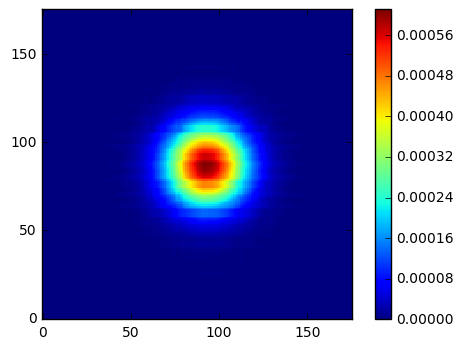

100%|██████████| 1000/1000 [01:21<00:00,  8.19it/s]


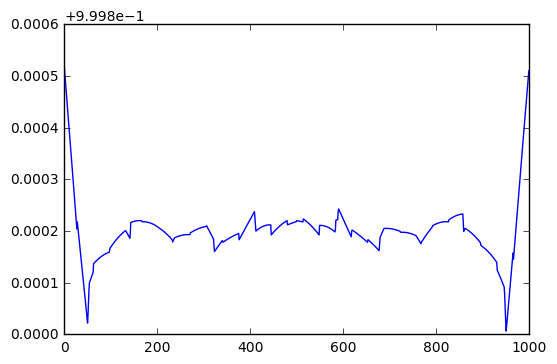

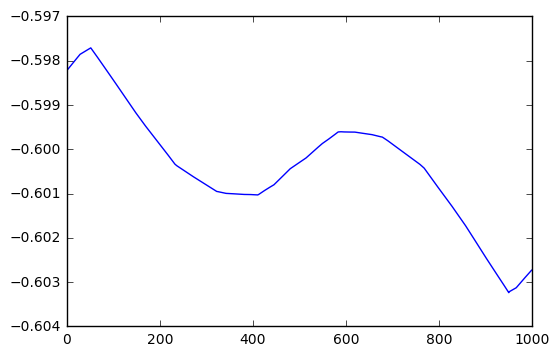

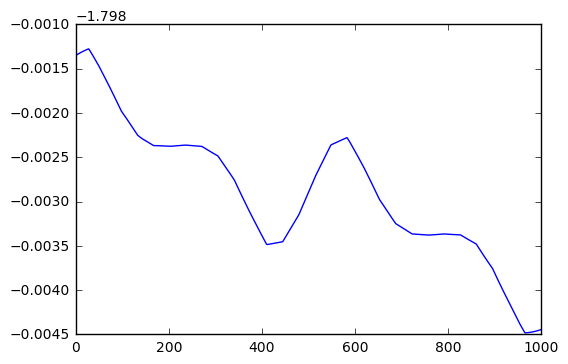

25


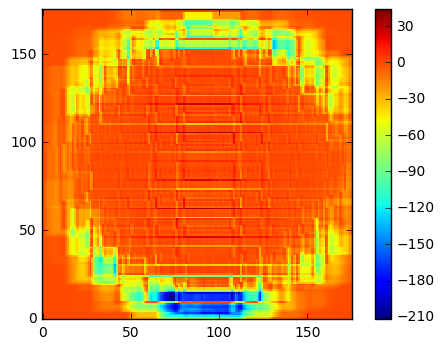

16386.6243529
16385.4782794 6.25e-12 0
16385.4782794
16383.6536582 1.0000000000000001e-11 1
16383.6536582
16380.7410104 1.6000000000000003e-11 2
16380.7410104
16376.0935088 2.5600000000000007e-11 3
16376.0935088
16368.6811639 4.096000000000001e-11 4
16368.6811639
16356.921453 6.553600000000002e-11 5
16356.921453
16349.4587298 1.0485760000000004e-10 6
16349.4587298
22515.276271 1.6777216000000006e-10 7
16349.4587298
17893.9612546 -3.3554432000000015e-11 8
16349.4587298
16336.9251839 6.710886400000003e-12 9
16336.9251839
16334.9406118 1.0737418240000006e-11 10
16334.9406118
16331.8883752 1.717986918400001e-11 11
16331.8883752
16327.2443711 2.748779069440002e-11 12
16327.2443711
16328.0278639 4.398046511104004e-11 13
16327.2443711
16491.5489209 -8.796093022208007e-12 14
16327.2443711
16326.7988658 1.7592186044416015e-12 15
16326.7988658
16326.1925573 2.8147497671065625e-12 16
16326.1925573
16325.3417825 4.5035996273705e-12 17
16325.3417825
16324.0514047 7.205759403792801e-12 18
16324.0514

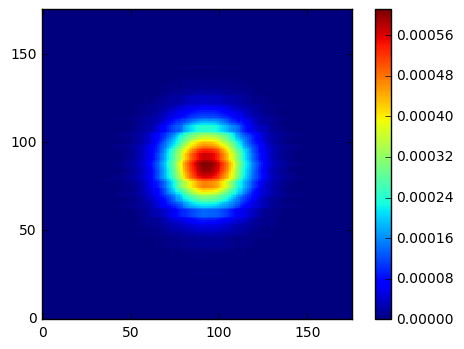

100%|██████████| 1000/1000 [01:21<00:00,  8.96it/s]


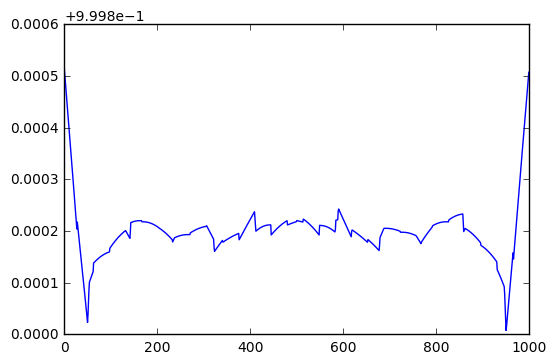

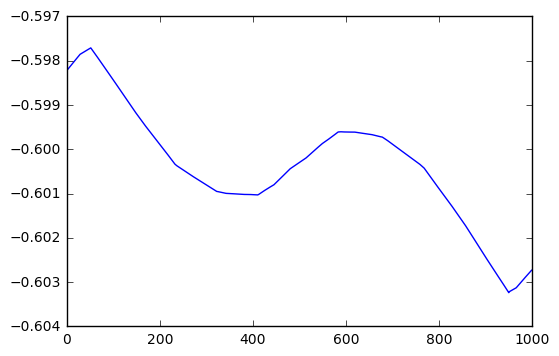

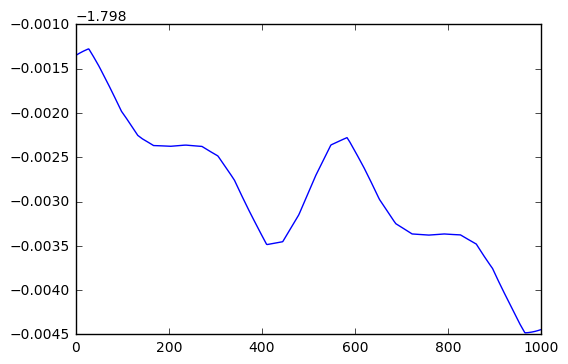

26


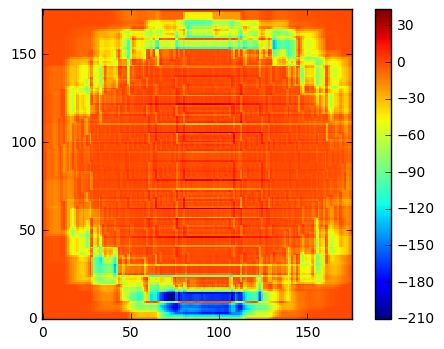

16115.7103303
16114.5909674 6.25e-12 0
16114.5909674
16112.8087694 1.0000000000000001e-11 1
16112.8087694
16109.9637294 1.6000000000000003e-11 2
16109.9637294
16105.4240006 2.5600000000000007e-11 3
16105.4240006
16098.1834105 4.096000000000001e-11 4
16098.1834105
16086.6950861 6.553600000000002e-11 5
16086.6950861
16079.2225508 1.0485760000000004e-10 6
16079.2225508
22006.6676119 1.6777216000000006e-10 7
16079.2225508
17588.4594446 -3.3554432000000015e-11 8
16079.2225508
16067.1610799 6.710886400000003e-12 9
16067.1610799
16065.2232925 1.0737418240000006e-11 10
16065.2232925
16062.2417588 1.717986918400001e-11 11
16062.2417588
16057.7059358 2.748779069440002e-11 12
16057.7059358
16058.5334919 4.398046511104004e-11 13
16057.7059358
16219.0800301 -8.796093022208007e-12 14
16057.7059358
16057.2702163 1.7592186044416015e-12 15
16057.2702163
16056.6776355 2.8147497671065625e-12 16
16056.6776355
16055.8465621 4.5035996273705e-12 17
16055.8465621
16054.5860679 7.205759403792801e-12 18
16054.5

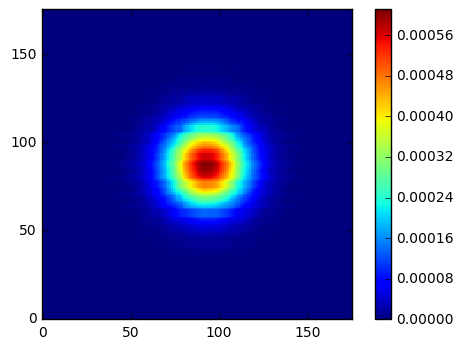

100%|██████████| 1000/1000 [01:21<00:00,  7.92it/s]


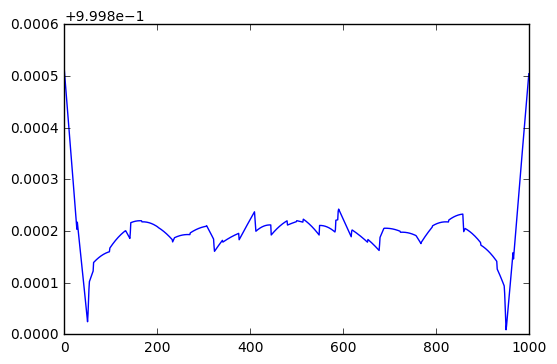

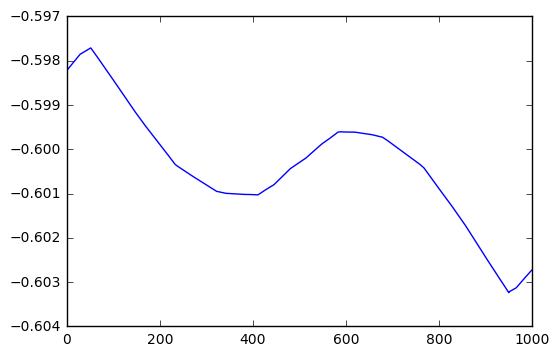

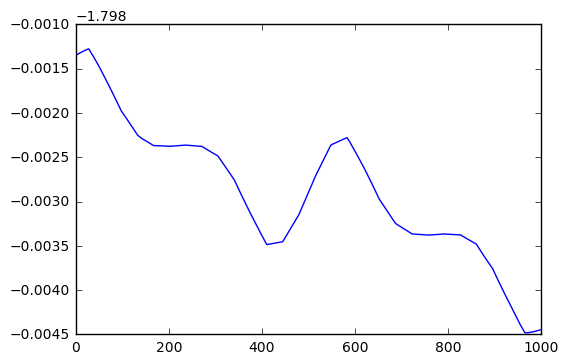

27


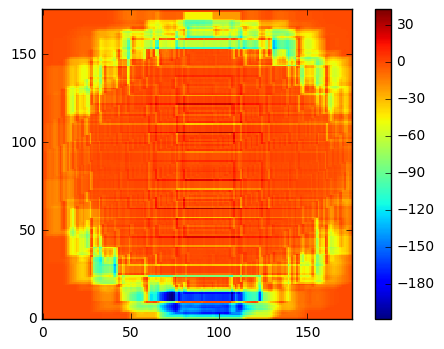

15851.0657413
15849.9723462 6.25e-12 0
15849.9723462
15848.2314081 1.0000000000000001e-11 1
15848.2314081
15845.4521794 1.6000000000000003e-11 2
15845.4521794
15841.0173784 2.5600000000000007e-11 3
15841.0173784
15833.9440246 4.096000000000001e-11 4
15833.9440246
15822.72061 6.553600000000002e-11 5
15822.72061
15815.3518752 1.0485760000000004e-10 6
15815.3518752
21563.2961356 1.6777216000000006e-10 7
15815.3518752
17292.7020684 -3.3554432000000015e-11 8
15815.3518752
15803.6351959 6.710886400000003e-12 9
15803.6351959
15801.7420473 1.0737418240000006e-11 10
15801.7420473
15798.8283775 1.717986918400001e-11 11
15798.8283775
15794.3907989 2.748779069440002e-11 12
15794.3907989
15794.9963268 4.398046511104004e-11 13
15794.3907989
15952.8214651 -8.796093022208007e-12 14
15794.3907989
15793.9680079 1.7592186044416015e-12 15
15793.9680079
15793.3912393 2.8147497671065625e-12 16
15793.3912393
15792.5800885 4.5035996273705e-12 17
15792.5800885
15791.348552 7.205759403792801e-12 18
15791.348552

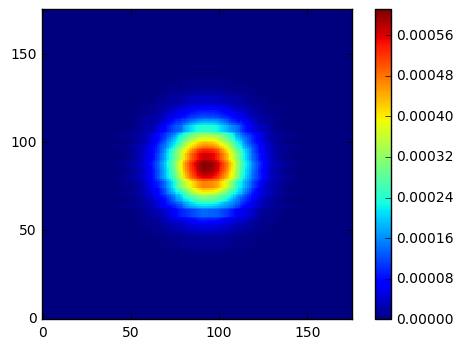

100%|██████████| 1000/1000 [01:21<00:00,  8.49it/s]


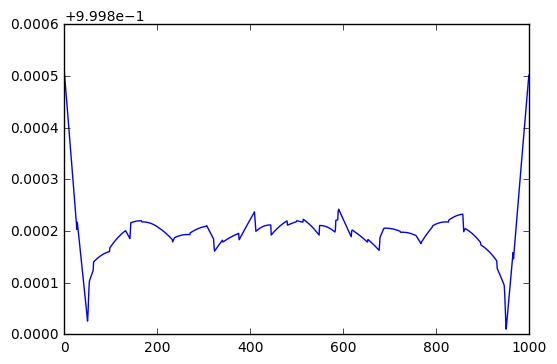

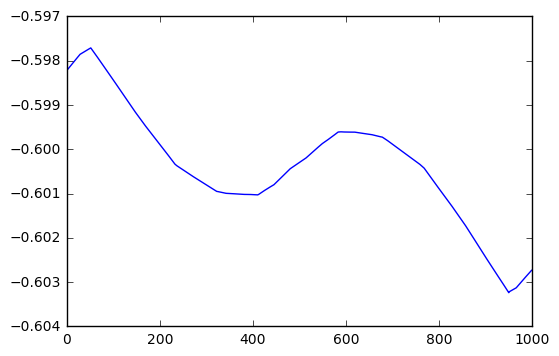

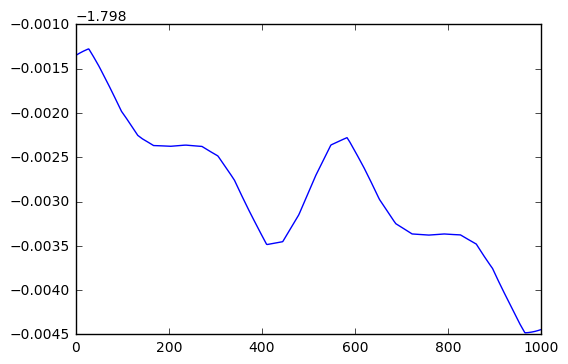

28


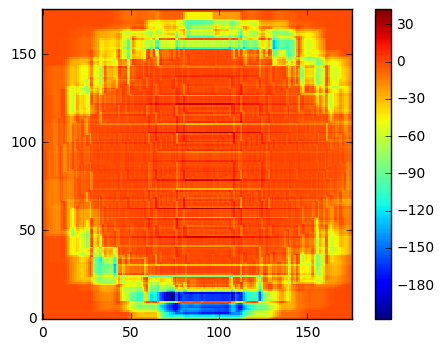

15592.4654769
15591.3971148 6.25e-12 0
15591.3971148
15589.6959458 1.0000000000000001e-11 1
15589.6959458
15586.980147 1.6000000000000003e-11 2
15586.980147
15582.6464702 2.5600000000000007e-11 3
15582.6464702
15575.7342795 4.096000000000001e-11 4
15575.7342795
15564.7658178 6.553600000000002e-11 5
15564.7658178
15557.4526598 1.0485760000000004e-10 6
15557.4526598
21118.9991382 1.6777216000000006e-10 7
15557.4526598
17003.6849837 -3.3554432000000015e-11 8
15557.4526598
15546.1144464 6.710886400000003e-12 9
15546.1144464
15544.2652053 1.0737418240000006e-11 10
15544.2652053
15541.4178783 1.717986918400001e-11 11
15541.4178783
15537.081731 2.748779069440002e-11 12
15537.081731
15537.7175536 4.398046511104004e-11 13
15537.081731
15692.7443526 -8.796093022208007e-12 14
15537.081731
15536.6682404 1.7592186044416015e-12 15
15536.6682404
15536.1044851 2.8147497671065625e-12 16
15536.1044851
15535.3117871 4.5035996273705e-12 17
15535.3117871
15534.1082899 7.205759403792801e-12 18
15534.1082899

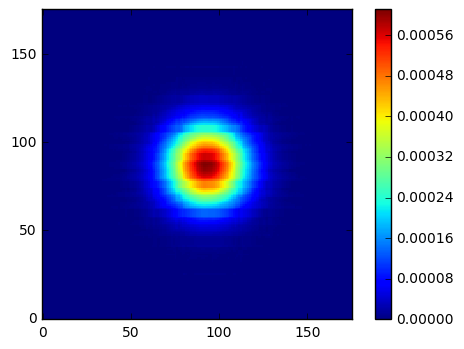

100%|██████████| 1000/1000 [01:21<00:00,  8.15it/s]


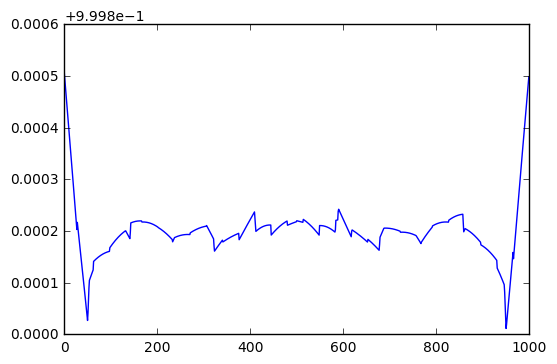

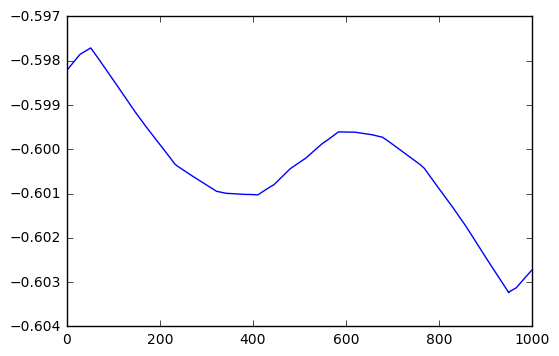

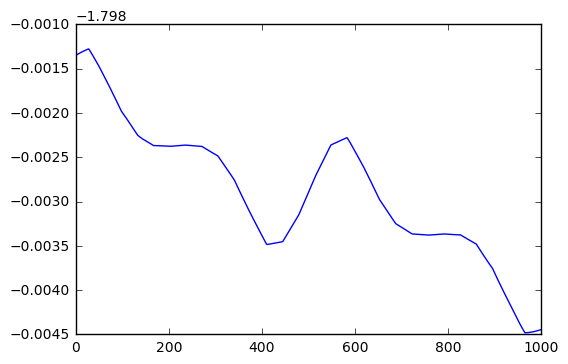

29


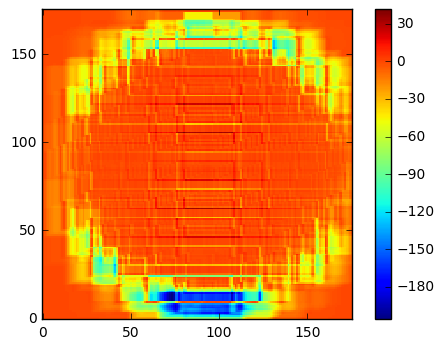

15339.7549868
15338.7113146 6.25e-12 0
15338.7113146
15337.0493859 1.0000000000000001e-11 1
15337.0493859
15334.3961731 1.6000000000000003e-11 2
15334.3961731
15330.162276 2.5600000000000007e-11 3
15330.162276
15323.4091134 4.096000000000001e-11 4
15323.4091134
15312.6926089 6.553600000000002e-11 5
15312.6926089
15305.4935733 1.0485760000000004e-10 6
15305.4935733
20708.8148294 1.6777216000000006e-10 7
15305.4935733
16722.2562048 -3.3554432000000015e-11 8
15305.4935733
15294.4698712 6.710886400000003e-12 9
15294.4698712
15292.6634015 1.0737418240000006e-11 10
15292.6634015
15289.8814508 1.717986918400001e-11 11
15289.8814508
15285.6430567 2.748779069440002e-11 12
15285.6430567
15286.2056179 4.398046511104004e-11 13
15285.6430567
15438.5137164 -8.796093022208007e-12 14
15285.6430567
15285.2400752 1.7592186044416015e-12 15
15285.2400752
15284.6901456 2.8147497671065625e-12 16
15284.6901456
15283.916087 4.5035996273705e-12 17
15283.916087
15282.7402895 7.205759403792801e-12 18
15282.74028

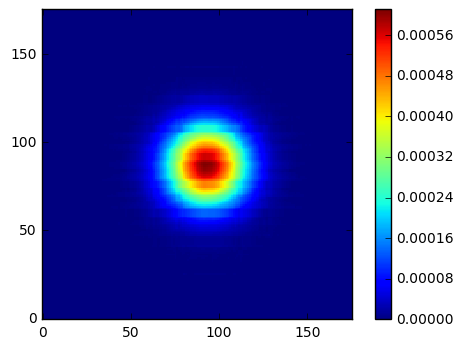

100%|██████████| 1000/1000 [01:21<00:00,  8.74it/s]


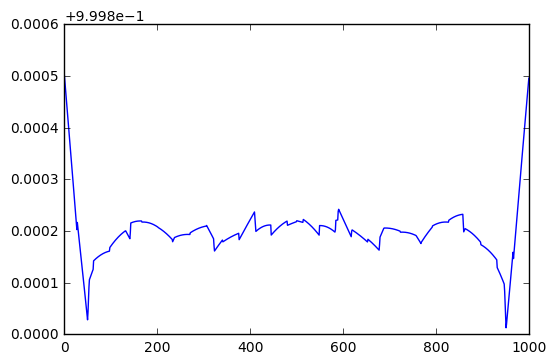

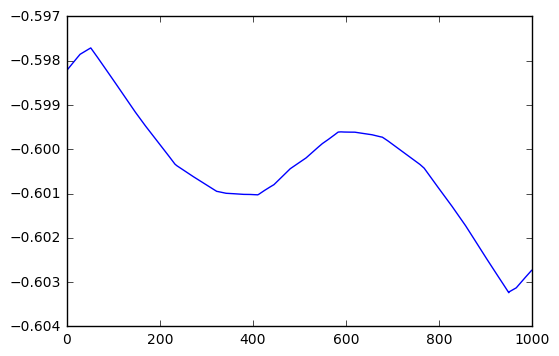

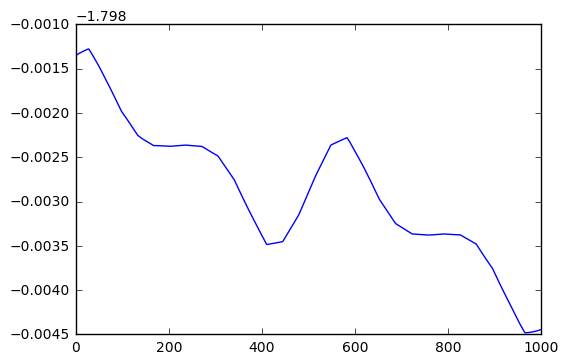

30


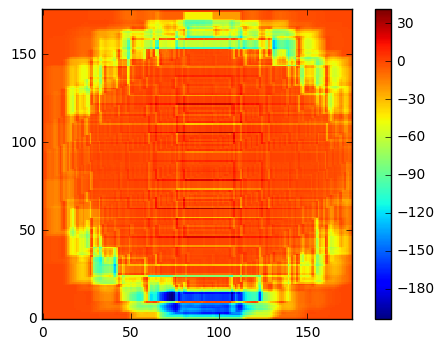

15092.8894265
15091.8698408 6.25e-12 0
15091.8698408
15090.2461868 1.0000000000000001e-11 1
15090.2461868
15087.6540304 1.6000000000000003e-11 2
15087.6540304
15083.5174912 2.5600000000000007e-11 3
15083.5174912
15076.9195328 4.096000000000001e-11 4
15076.9195328
15066.4485827 6.553600000000002e-11 5
15066.4485827
15059.2785033 1.0485760000000004e-10 6
15059.2785033
20260.6037164 1.6777216000000006e-10 7
15059.2785033
16444.2971402 -3.3554432000000015e-11 8
15059.2785033
15048.644045 6.710886400000003e-12 9
15048.644045
15046.8797964 1.0737418240000006e-11 10
15046.8797964
15044.1614677 1.717986918400001e-11 11
15044.1614677
15040.0172805 2.748779069440002e-11 12
15040.0172805
15040.4645023 4.398046511104004e-11 13
15040.0172805
15190.0814297 -8.796093022208007e-12 14
15040.0172805
15039.6250485 1.7592186044416015e-12 15
15039.6250485
15039.0888931 2.8147497671065625e-12 16
15039.0888931
15038.3330679 4.5035996273705e-12 17
15038.3330679
15037.1841968 7.205759403792801e-12 18
15037.184

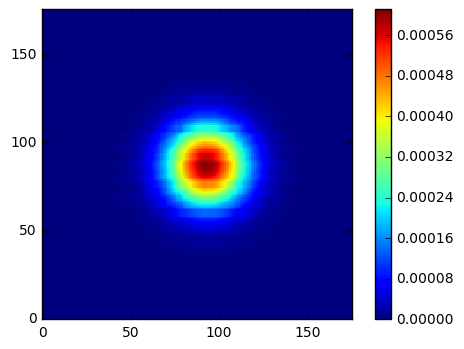

100%|██████████| 1000/1000 [01:21<00:00,  7.98it/s]


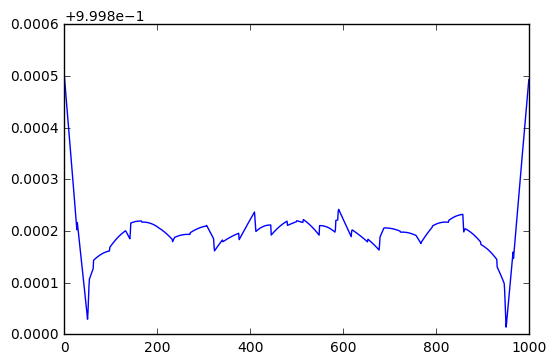

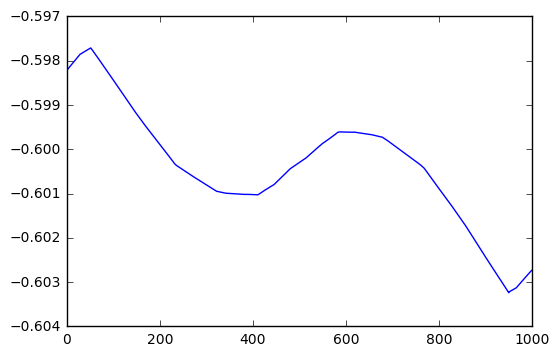

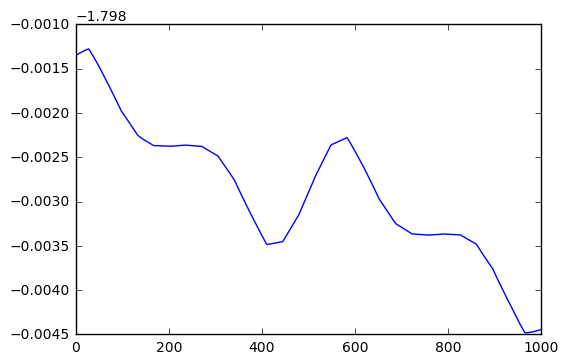

31


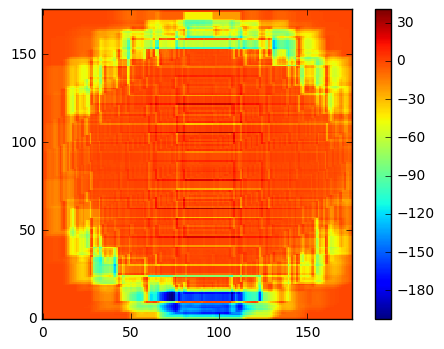

14851.7141058
14850.7181126 6.25e-12 0
14850.7181126
14849.1319578 1.0000000000000001e-11 1
14849.1319578
14846.599637 1.6000000000000003e-11 2
14846.599637
14842.5585397 2.5600000000000007e-11 3
14842.5585397
14836.1127642 4.096000000000001e-11 4
14836.1127642
14825.8831628 6.553600000000002e-11 5
14825.8831628
14818.7557843 1.0485760000000004e-10 6
14818.7557843
19833.8656193 1.6777216000000006e-10 7
14818.7557843
16173.0950251 -3.3554432000000015e-11 8
14818.7557843
14808.4914856 6.710886400000003e-12 9
14808.4914856
14806.7685866 1.0737418240000006e-11 10
14806.7685866
14804.1132384 1.717986918400001e-11 11
14804.1132384
14800.0654362 2.748779069440002e-11 12
14800.0654362
14800.5415683 4.398046511104004e-11 13
14800.0654362
14947.4203543 -8.796093022208007e-12 14
14800.0654362
14799.6820197 1.7592186044416015e-12 15
14799.6820197
14799.1582038 2.8147497671065625e-12 16
14799.1582038
14798.4199863 4.5035996273705e-12 17
14798.4199863
14797.2977415 7.205759403792801e-12 18
14797.297

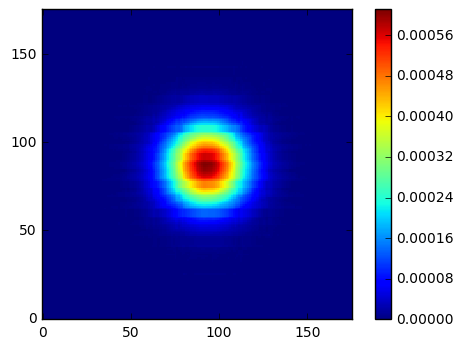

100%|██████████| 1000/1000 [01:22<00:00,  7.99it/s]


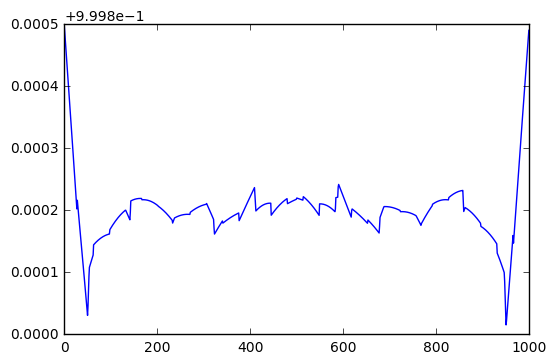

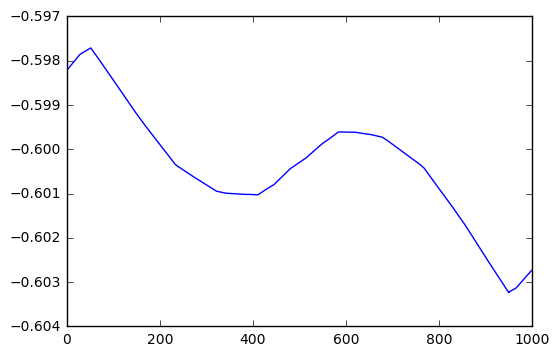

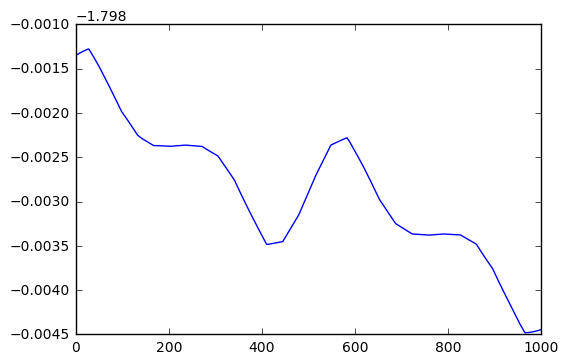

32


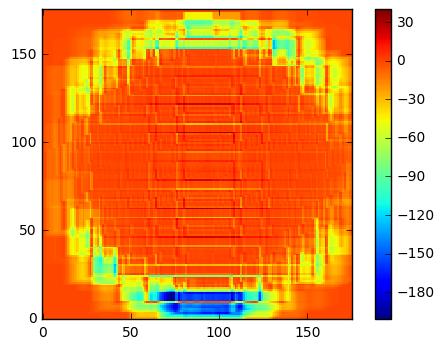

14616.042824
14615.0695101 6.25e-12 0
14615.0695101
14613.5194227 1.0000000000000001e-11 1
14613.5194227
14611.0446509 1.6000000000000003e-11 2
14611.0446509
14607.0953415 2.5600000000000007e-11 3
14607.0953415
14600.7959102 4.096000000000001e-11 4
14600.7959102
14590.7987602 6.553600000000002e-11 5
14590.7987602
14583.7899159 1.0485760000000004e-10 6
14583.7899159
19463.0353944 1.6777216000000006e-10 7
14583.7899159
15910.3159868 -3.3554432000000015e-11 8
14583.7899159
14573.8023439 6.710886400000003e-12 9
14573.8023439
14572.1198544 1.0737418240000006e-11 10
14572.1198544
14569.5252457 1.717986918400001e-11 11
14569.5252457
14565.5672992 2.748779069440002e-11 12
14565.5672992
14565.928634 4.398046511104004e-11 13
14565.5672992
14710.2173183 -8.796093022208007e-12 14
14565.5672992
14565.194219 1.7592186044416015e-12 15
14565.194219
14564.6836298 2.8147497671065625e-12 16
14564.6836298
14563.9629244 4.5035996273705e-12 17
14563.9629244
14562.8665176 7.205759403792801e-12 18
14562.86651

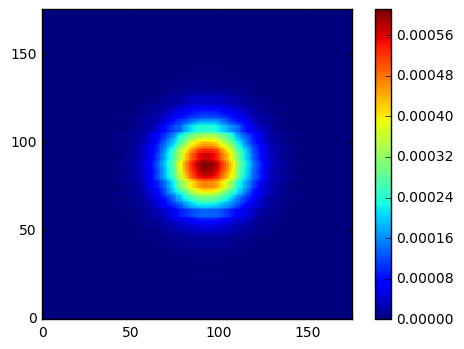

100%|██████████| 1000/1000 [01:22<00:00,  8.65it/s]


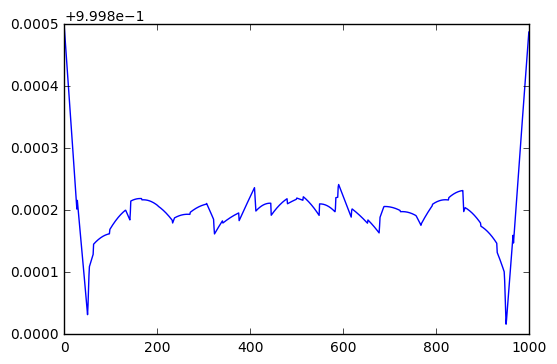

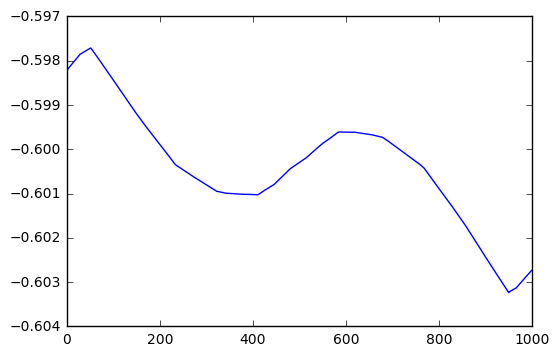

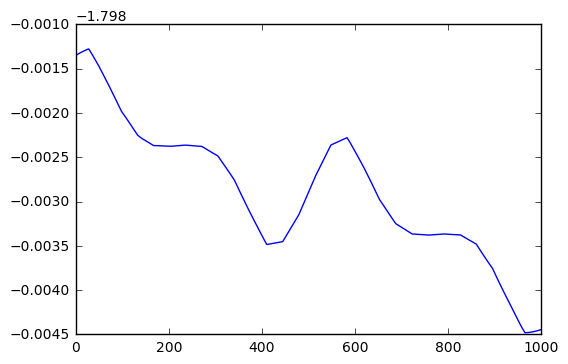

33


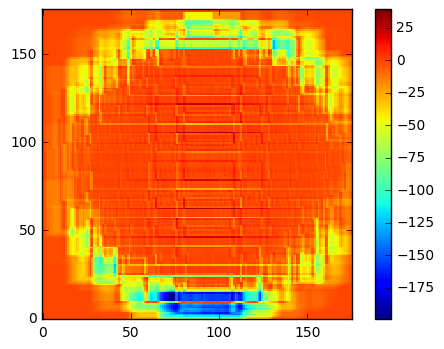

14385.7535487
14384.8023497 6.25e-12 0
14384.8023497
14383.2874253 1.0000000000000001e-11 1
14383.2874253
14380.8687632 1.6000000000000003e-11 2
14380.8687632
14377.0089554 2.5600000000000007e-11 3
14377.0089554
14370.8522482 4.096000000000001e-11 4
14370.8522482
14361.0800673 6.553600000000002e-11 5
14361.0800673
14354.1226284 1.0485760000000004e-10 6
14354.1226284
19063.0336905 1.6777216000000006e-10 7
14354.1226284
15652.281787 -3.3554432000000015e-11 8
14354.1226284
14344.4662999 6.710886400000003e-12 9
14344.4662999
14342.8218835 1.0737418240000006e-11 10
14342.8218835
14340.2852332 1.717986918400001e-11 11
14340.2852332
14336.4147024 2.748779069440002e-11 12
14336.4147024
14336.7482842 4.398046511104004e-11 13
14336.4147024
14478.4897468 -8.796093022208007e-12 14
14336.4147024
14336.050374 1.7592186044416015e-12 15
14336.050374
14335.5515512 2.8147497671065625e-12 16
14335.5515512
14334.8471789 4.5035996273705e-12 17
14334.8471789
14333.7753187 7.205759403792801e-12 18
14333.7753

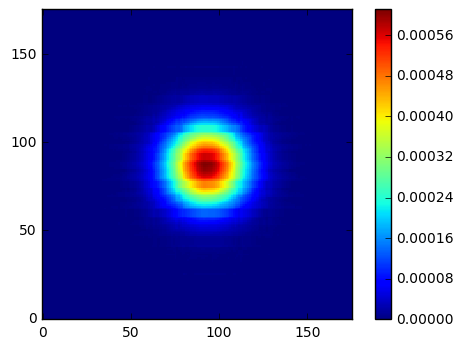

100%|██████████| 1000/1000 [01:21<00:00,  8.07it/s]


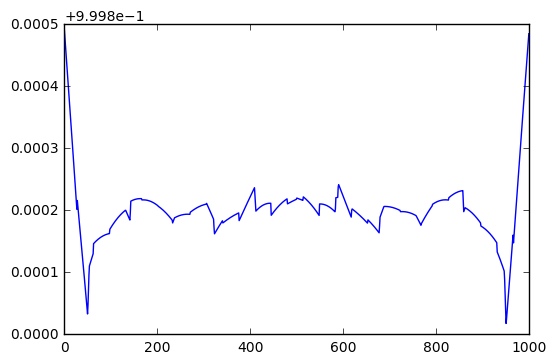

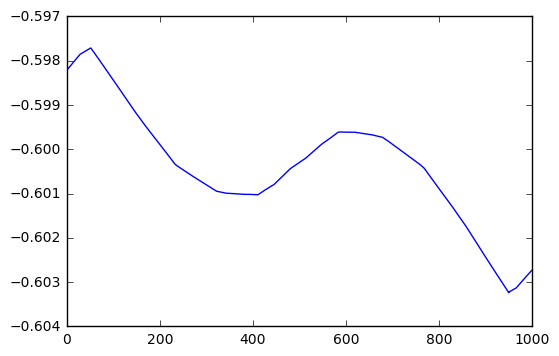

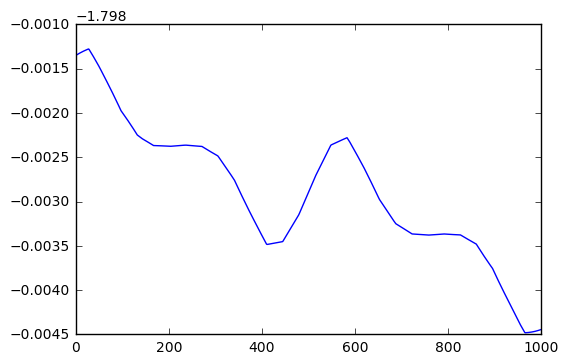

34


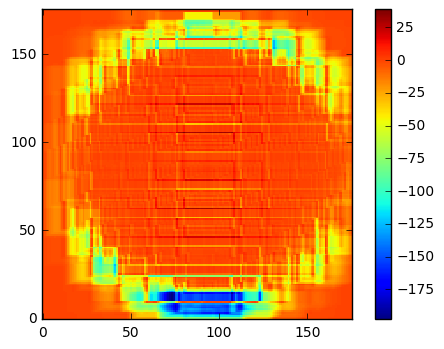

14160.6077947
14159.6783302 6.25e-12 0
14159.6783302
14158.1979753 1.0000000000000001e-11 1
14158.1979753
14155.8344724 1.6000000000000003e-11 2
14155.8344724
14152.0626485 2.5600000000000007e-11 3
14152.0626485
14146.0462897 4.096000000000001e-11 4
14146.0462897
14136.496776 6.553600000000002e-11 5
14136.496776
14129.6707467 1.0485760000000004e-10 6
14129.6707467
18710.7114524 1.6777216000000006e-10 7
14129.6707467
15402.5844719 -3.3554432000000015e-11 8
14129.6707467
14120.2605065 6.710886400000003e-12 9
14120.2605065
14118.6532674 1.0737418240000006e-11 10
14118.6532674
14116.1741212 1.717986918400001e-11 11
14116.1741212
14112.3911125 2.748779069440002e-11 12
14112.3911125
14112.7126193 4.398046511104004e-11 13
14112.3911125
14252.0081865 -8.796093022208007e-12 14
14112.3911125
14112.0351958 1.7592186044416015e-12 15
14112.0351958
14111.5478038 2.8147497671065625e-12 16
14111.5478038
14110.8595075 4.5035996273705e-12 17
14110.8595075
14109.8120591 7.205759403792801e-12 18
14109.812

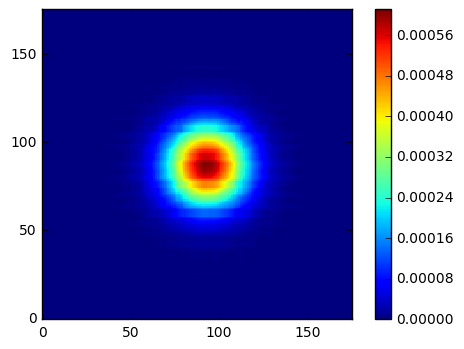

100%|██████████| 1000/1000 [01:21<00:00,  8.07it/s]


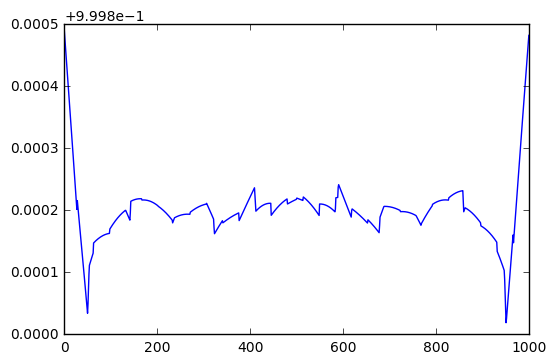

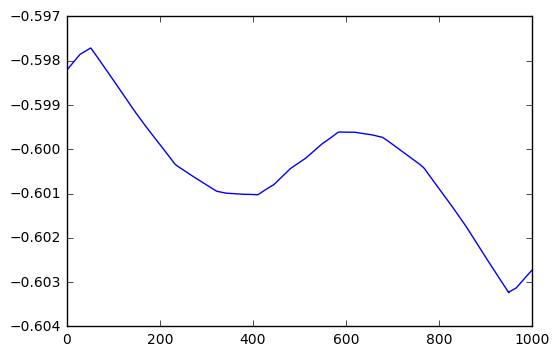

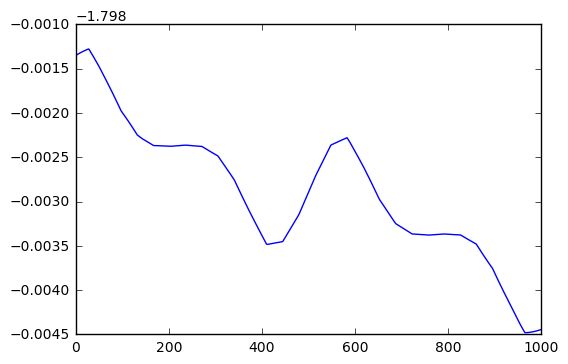

35


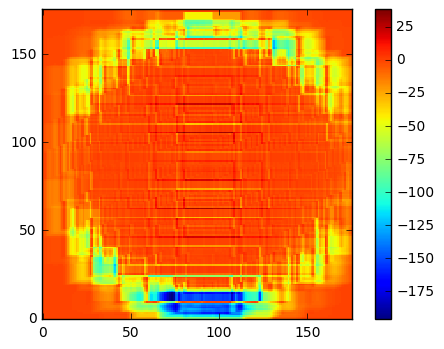

13940.5736261
13939.6649935 6.25e-12 0
13939.6649935
13938.2177594 1.0000000000000001e-11 1
13938.2177594
13935.9070983 1.6000000000000003e-11 2
13935.9070983
13932.2195497 2.5600000000000007e-11 3
13932.2195497
13926.3375245 4.096000000000001e-11 4
13926.3375245
13917.0005445 6.553600000000002e-11 5
13917.0005445
13910.1763912 1.0485760000000004e-10 6
13910.1763912
18295.3176621 1.6777216000000006e-10 7
13910.1763912
15153.8028896 -3.3554432000000015e-11 8
13910.1763912
13901.1264136 6.710886400000003e-12 9
13901.1264136
13899.55572 1.0737418240000006e-11 10
13899.55572
13897.1317572 1.717986918400001e-11 11
13897.1317572
13893.4292334 2.748779069440002e-11 12
13893.4292334
13893.5822764 4.398046511104004e-11 13
13893.4292334
14030.4807166 -8.796093022208007e-12 14
13893.4292334
13893.0833047 1.7592186044416015e-12 15
13893.0833047
13892.6082518 2.8147497671065625e-12 16
13892.6082518
13891.9358517 4.5035996273705e-12 17
13891.9358517
13890.9118251 7.205759403792801e-12 18
13890.91182

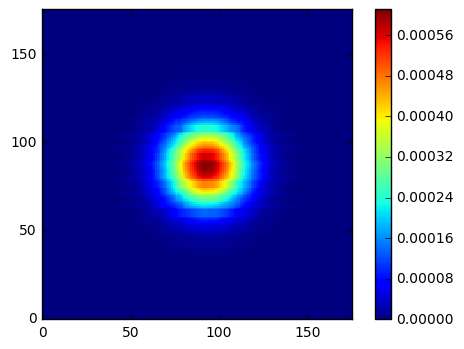

100%|██████████| 1000/1000 [01:21<00:00,  7.95it/s]


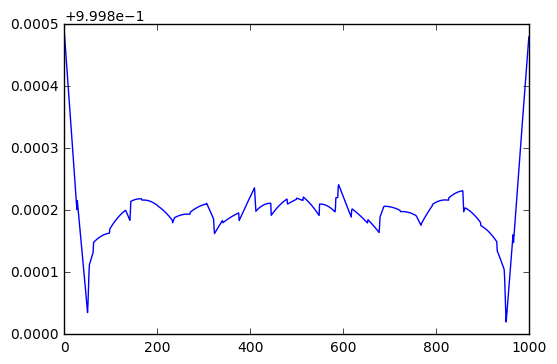

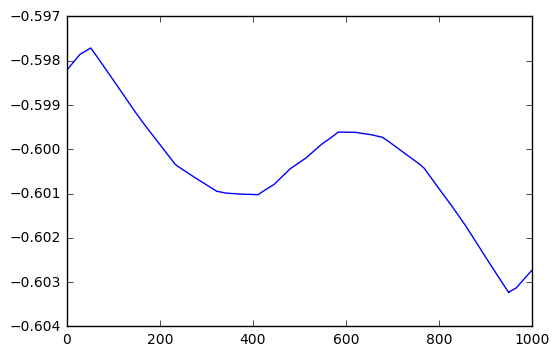

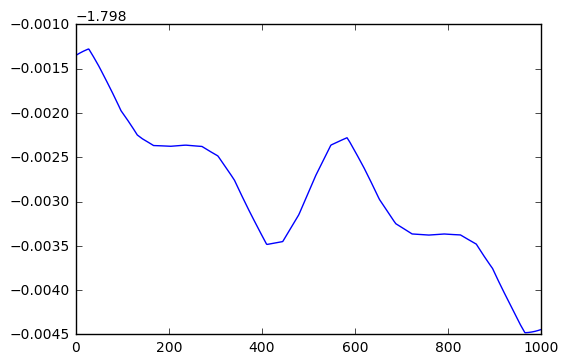

36


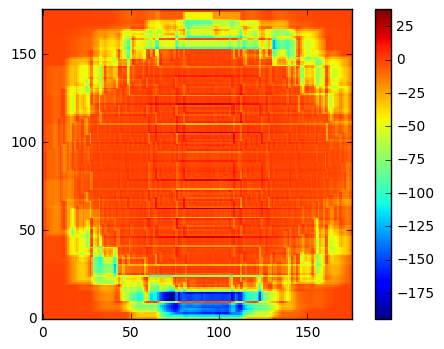

13725.4311215
13724.5424236 6.25e-12 0
13724.5424236
13723.1268795 1.0000000000000001e-11 1
13723.1268795
13720.8667847 1.6000000000000003e-11 2
13720.8667847
13717.2598875 2.5600000000000007e-11 3
13717.2598875
13711.506939 4.096000000000001e-11 4
13711.506939
13702.3742438 6.553600000000002e-11 5
13702.3742438
13695.4971443 1.0485760000000004e-10 6
13695.4971443
17854.1437293 1.6777216000000006e-10 7
13695.4971443
14908.6959471 -3.3554432000000015e-11 8
13695.4971443
13686.8489293 6.710886400000003e-12 9
13686.8489293
13685.3127889 1.0737418240000006e-11 10
13685.3127889
13682.9419361 1.717986918400001e-11 11
13682.9419361
13679.3202452 2.748779069440002e-11 12
13679.3202452
13679.4524571 4.398046511104004e-11 13
13679.3202452
13813.843111 -8.796093022208007e-12 14
13679.3202452
13678.981988 1.7592186044416015e-12 15
13678.981988
13678.5173527 2.8147497671065625e-12 16
13678.5173527
13677.8596086 4.5035996273705e-12 17
13677.8596086
13676.8579494 7.205759403792801e-12 18
13676.857949

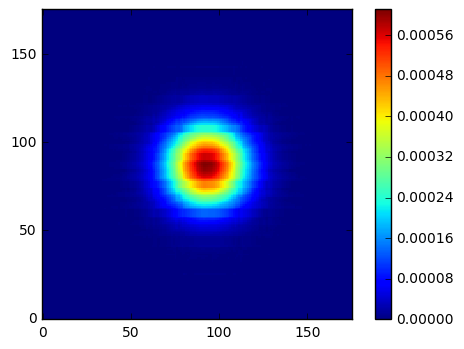

100%|██████████| 1000/1000 [01:21<00:00, 12.31it/s]


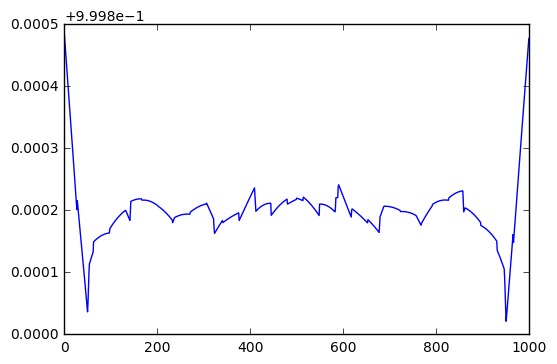

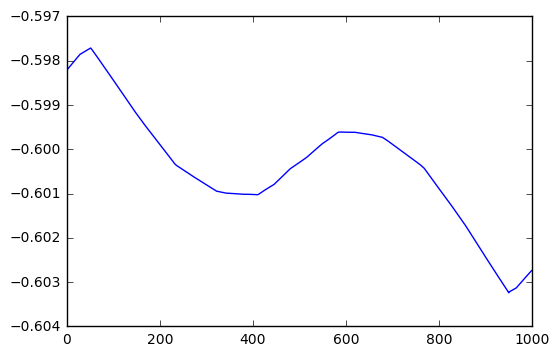

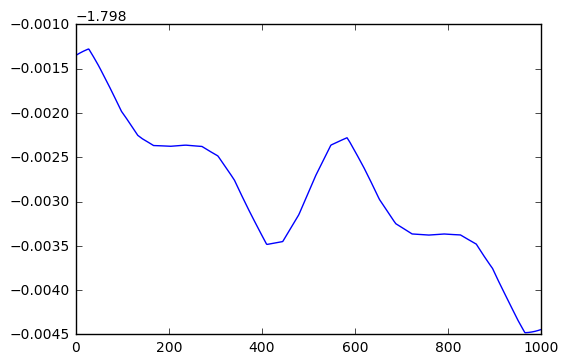

37


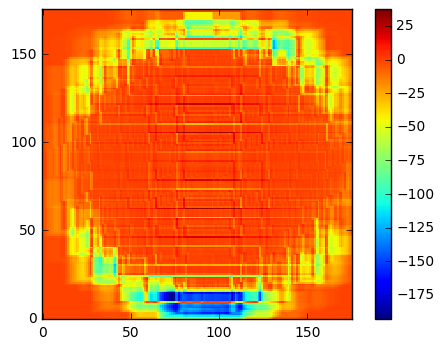

13514.9857321
13514.1164806 6.25e-12 0
13514.1164806
13512.7318671 1.0000000000000001e-11 1
13512.7318671
13510.5211297 1.6000000000000003e-11 2
13510.5211297
13506.9929728 2.5600000000000007e-11 3
13506.9929728
13501.3651236 4.096000000000001e-11 4
13501.3651236
13492.4305279 6.553600000000002e-11 5
13492.4305279
13485.6692585 1.0485760000000004e-10 6
13485.6692585
17541.5644643 1.6777216000000006e-10 7
13485.6692585
14674.266323 -3.3554432000000015e-11 8
13485.6692585
13477.242517 6.710886400000003e-12 9
13477.242517
13475.7405963 1.0737418240000006e-11 10
13475.7405963
13473.4214161 1.717986918400001e-11 11
13473.4214161
13469.8790848 2.748779069440002e-11 12
13469.8790848
13470.0382681 4.398046511104004e-11 13
13469.8790848
13601.9452681 -8.796093022208007e-12 14
13469.8790848
13469.5479552 1.7592186044416015e-12 15
13469.5479552
13469.0933116 2.8147497671065625e-12 16
13469.0933116
13468.4499127 4.5035996273705e-12 17
13468.4499127
13467.4701121 7.205759403792801e-12 18
13467.4701

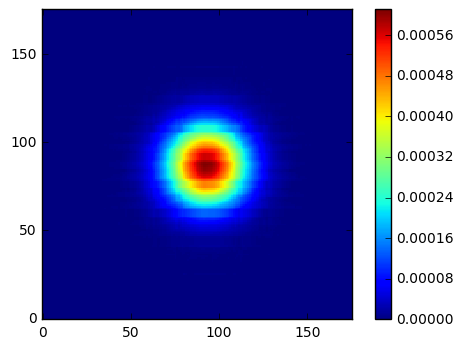

100%|██████████| 1000/1000 [01:21<00:00,  7.69it/s]


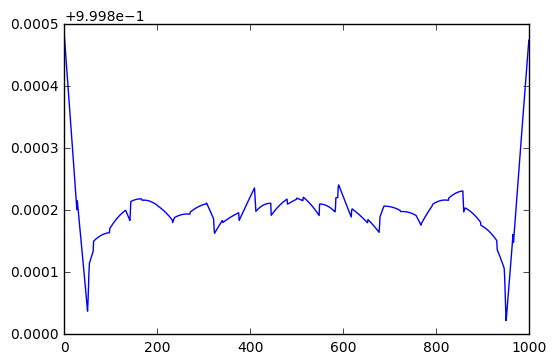

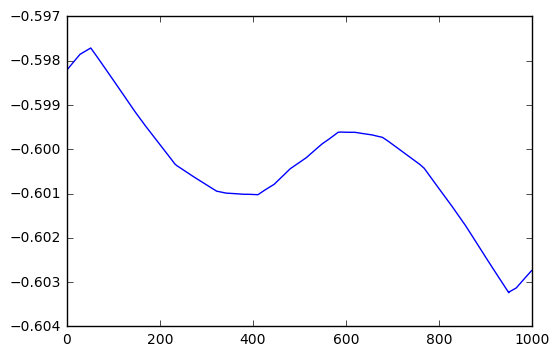

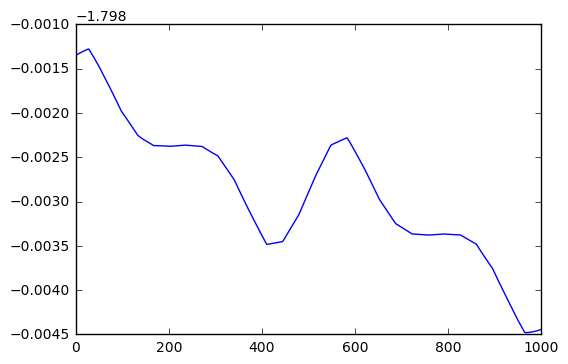

38


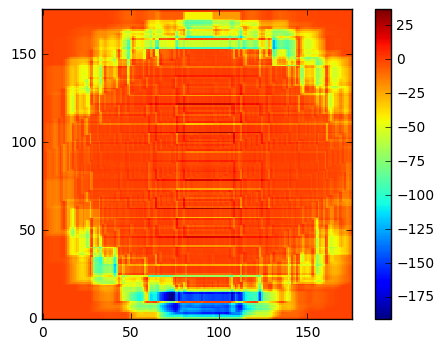

13309.1043957
13308.2539365 6.25e-12 0
13308.2539365
13306.8992151 1.0000000000000001e-11 1
13306.8992151
13304.7361788 1.6000000000000003e-11 2
13304.7361788
13301.2841181 2.5600000000000007e-11 3
13301.2841181
13295.777631 4.096000000000001e-11 4
13295.777631
13287.035543 6.553600000000002e-11 5
13287.035543
13280.3668409 1.0485760000000004e-10 6
13280.3668409
17207.421227 1.6777216000000006e-10 7
13280.3668409
14443.8303874 -3.3554432000000015e-11 8
13280.3668409
13272.1752669 6.710886400000003e-12 9
13272.1752669
13270.705549 1.0737418240000006e-11 10
13270.705549
13268.4361314 1.717986918400001e-11 11
13268.4361314
13264.9673221 2.748779069440002e-11 12
13264.9673221
13265.0041736 4.398046511104004e-11 13
13264.9673221
13394.573273 -8.796093022208007e-12 14
13264.9673221
13264.6448738 1.7592186044416015e-12 15
13264.6448738
13264.2011299 2.8147497671065625e-12 16
13264.2011299
13263.5719793 4.5035996273705e-12 17
13263.5719793
13262.6133135 7.205759403792801e-12 18
13262.6133135
1

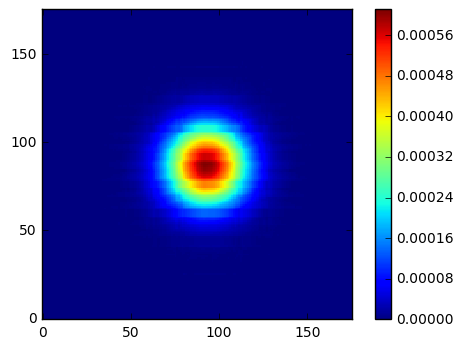

100%|██████████| 1000/1000 [01:20<00:00,  8.03it/s]


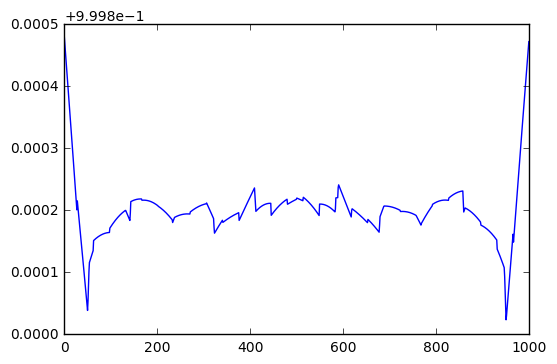

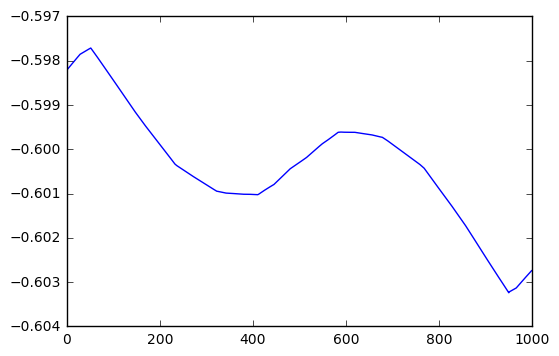

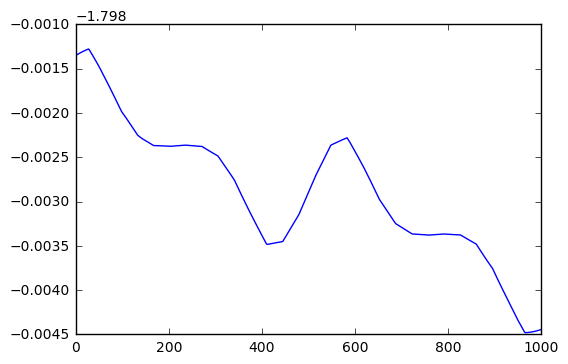

39


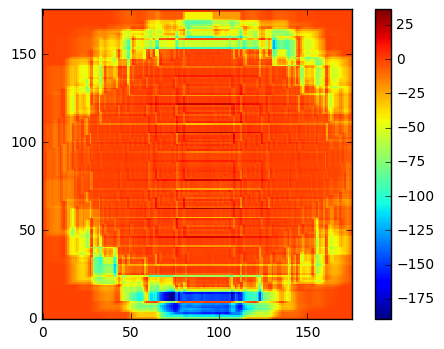

13107.7283995
13106.8968011 6.25e-12 0
13106.8968011
13105.5720848 1.0000000000000001e-11 1
13105.5720848
13103.4569272 1.6000000000000003e-11 2
13103.4569272
13100.081231 2.5600000000000007e-11 3
13100.081231
13094.6965072 4.096000000000001e-11 4
13094.6965072
13086.1478856 6.553600000000002e-11 5
13086.1478856
13079.5532886 1.0485760000000004e-10 6
13079.5532886
16880.3057321 1.6777216000000006e-10 7
13079.5532886
14218.5087364 -3.3554432000000015e-11 8
13079.5532886
13071.6183735 6.710886400000003e-12 9
13071.6183735
13070.1817241 1.0737418240000006e-11 10
13070.1817241
13067.962763 1.717986918400001e-11 11
13067.962763
13064.5712224 2.748779069440002e-11 12
13064.5712224
13064.6162529 4.398046511104004e-11 13
13064.5712224
13191.7627792 -8.796093022208007e-12 14
13064.5712224
13064.2558504 1.7592186044416015e-12 15
13064.2558504
13063.8219343 2.8147497671065625e-12 16
13063.8219343
13063.2067769 4.5035996273705e-12 17
13063.2067769
13062.2694335 7.205759403792801e-12 18
13062.26943

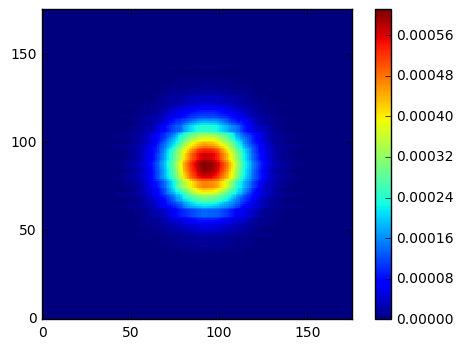

100%|██████████| 1000/1000 [01:21<00:00,  7.82it/s]


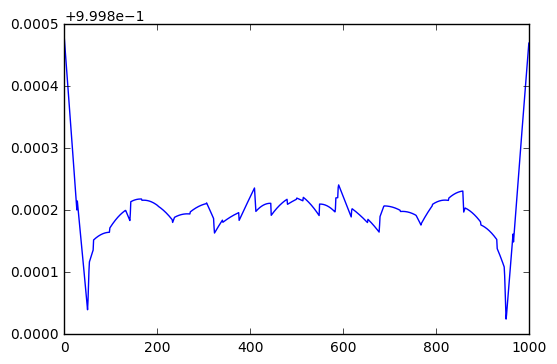

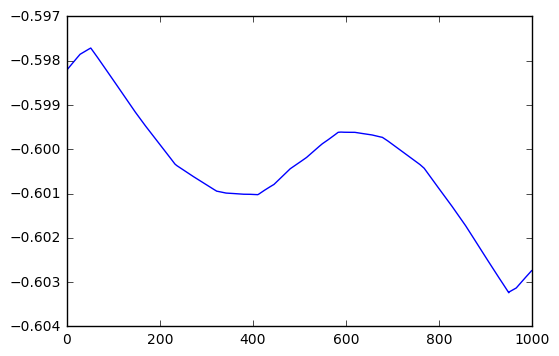

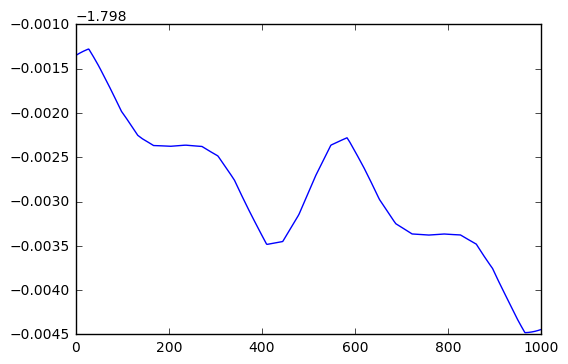

40


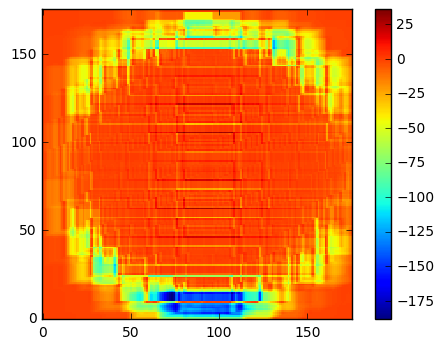

12910.7501091
12909.9364262 6.25e-12 0
12909.9364262
12908.6402132 1.0000000000000001e-11 1
12908.6402132
12906.5705458 1.6000000000000003e-11 2
12906.5705458
12903.2674275 2.5600000000000007e-11 3
12903.2674275
12897.9984585 4.096000000000001e-11 4
12897.9984585
12889.6338257 6.553600000000002e-11 5
12889.6338257
12883.1598477 1.0485760000000004e-10 6
12883.1598477
16595.7709315 1.6777216000000006e-10 7
12883.1598477
13999.4644958 -3.3554432000000015e-11 8
12883.1598477
12875.4159828 6.710886400000003e-12 9
12875.4159828
12874.0106106 1.0737418240000006e-11 10
12874.0106106
12871.8393168 1.717986918400001e-11 11
12871.8393168
12868.5204782 2.748779069440002e-11 12
12868.5204782
12868.5703324 4.398046511104004e-11 13
12868.5204782
12993.3822112 -8.796093022208007e-12 14
12868.5204782
12868.2119073 1.7592186044416015e-12 15
12868.2119073
12867.7873825 2.8147497671065625e-12 16
12867.7873825
12867.1855169 4.5035996273705e-12 17
12867.1855169
12866.2683254 7.205759403792801e-12 18
12866.2

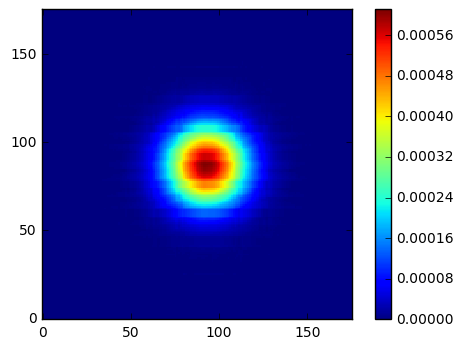

100%|██████████| 1000/1000 [01:20<00:00,  8.95it/s]


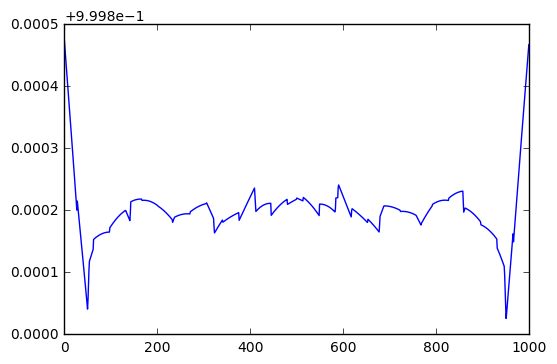

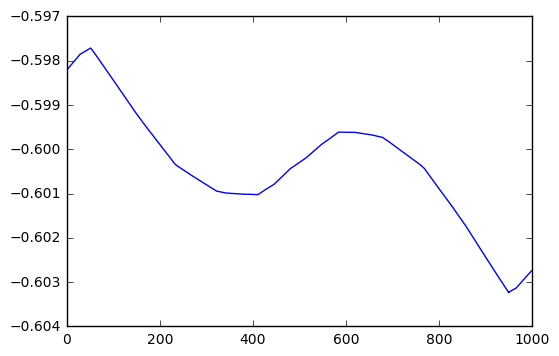

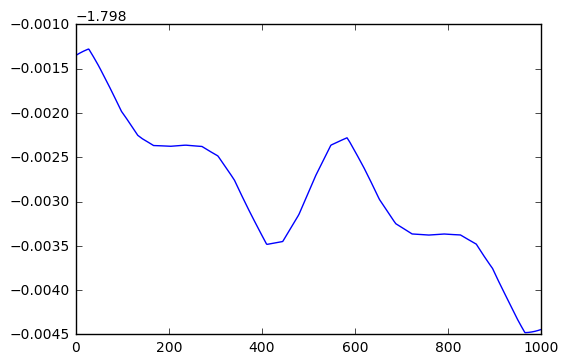

41


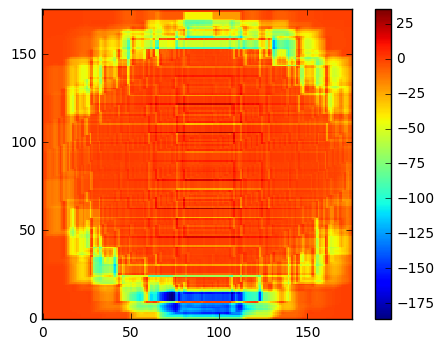

12717.9983223
12717.2020521 6.25e-12 0
12717.2020521
12715.9335524 1.0000000000000001e-11 1
12715.9335524
12713.9081216 1.6000000000000003e-11 2
12713.9081216
12710.6755908 2.5600000000000007e-11 3
12710.6755908
12705.5192263 4.096000000000001e-11 4
12705.5192263
12697.3323958 6.553600000000002e-11 5
12697.3323958
12690.9732393 1.0485760000000004e-10 6
12690.9732393
16309.3503137 1.6777216000000006e-10 7
12690.9732393
13785.7761764 -3.3554432000000015e-11 8
12690.9732393
12683.4169896 6.710886400000003e-12 9
12683.4169896
12682.0412958 1.0737418240000006e-11 10
12682.0412958
12679.9161033 1.717986918400001e-11 11
12679.9161033
12676.6679597 2.748779069440002e-11 12
12676.6679597
12676.731796 4.398046511104004e-11 13
12676.6679597
12799.303944 -8.796093022208007e-12 14
12676.6679597
12676.3658014 1.7592186044416015e-12 15
12676.3658014
12675.9502089 2.8147497671065625e-12 16
12675.9502089
12675.3611171 4.5035996273705e-12 17
12675.3611171
12674.4633992 7.205759403792801e-12 18
12674.463

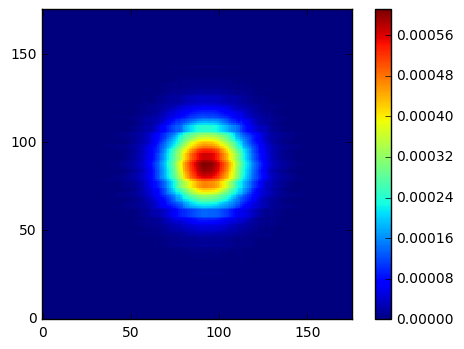

100%|██████████| 1000/1000 [01:20<00:00,  8.09it/s]


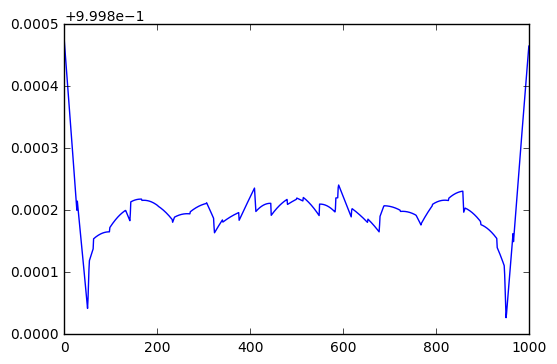

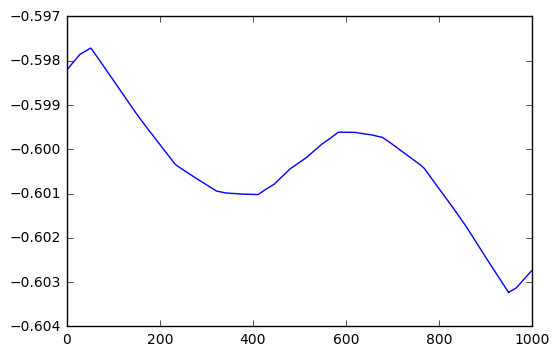

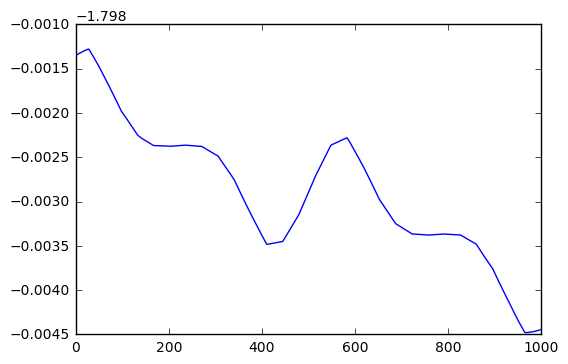

42


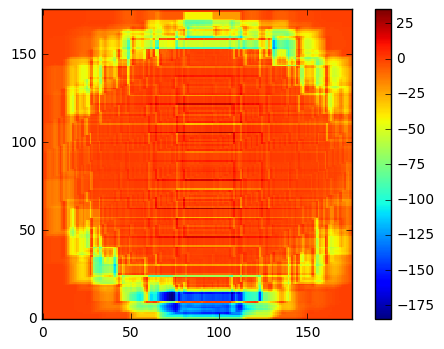

12529.3477449
12528.568418 6.25e-12 0
12528.568418
12527.3268835 1.0000000000000001e-11 1
12527.3268835
12525.3444984 1.6000000000000003e-11 2
12525.3444984
12522.1806529 2.5600000000000007e-11 3
12522.1806529
12517.1338477 4.096000000000001e-11 4
12517.1338477
12509.120687 6.553600000000002e-11 5
12509.120687
12502.7914335 1.0485760000000004e-10 6
12502.7914335
15979.4611451 1.6777216000000006e-10 7
12502.7914335
13573.4423808 -3.3554432000000015e-11 8
12502.7914335
12495.501315 6.710886400000003e-12 9
12495.501315
12494.1556481 1.0737418240000006e-11 10
12494.1556481
12492.0754279 1.717986918400001e-11 11
12492.0754279
12488.890271 2.748779069440002e-11 12
12488.890271
12488.6968782 4.398046511104004e-11 13
12488.6968782
12964.2529248 7.036874417766406e-11 14
12488.6968782
12764.7215434 -1.4073748835532812e-11 15
12488.6968782
12484.8086644 2.8147497671065625e-12 16
12484.8086644
12482.6933835 4.5035996273705e-12 17
12482.6933835
12481.6238127 7.205759403792801e-12 18
12481.6238127
1

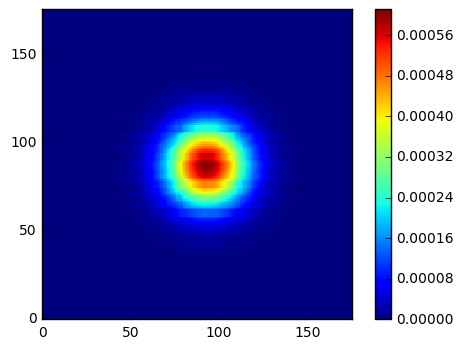

100%|██████████| 1000/1000 [01:20<00:00,  9.06it/s]


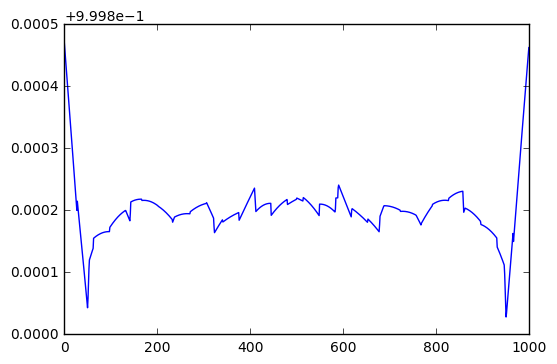

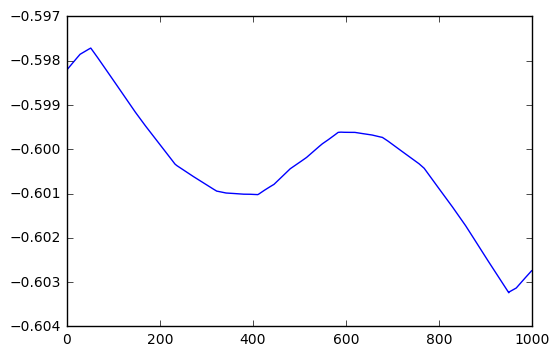

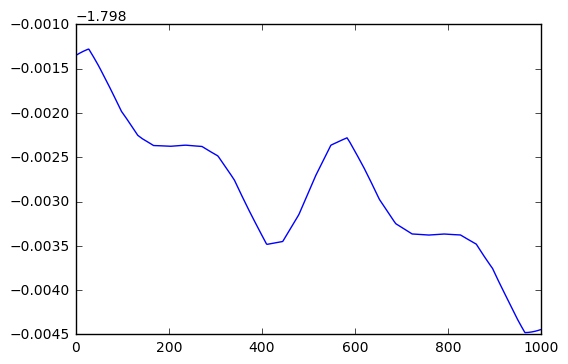

43


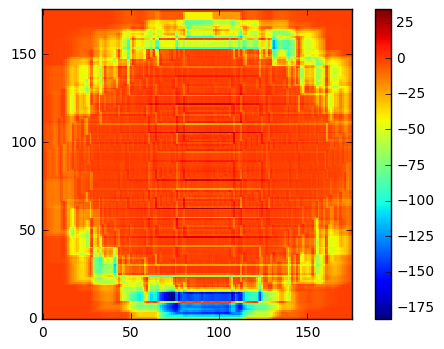

12342.864559
12342.1015754 6.25e-12 0
12342.1015754
12340.8868081 1.0000000000000001e-11 1
12340.8868081
12338.947184 1.6000000000000003e-11 2
12338.947184
12335.8515614 2.5600000000000007e-11 3
12335.8515614
12330.9137429 4.096000000000001e-11 4
12330.9137429
12323.0788321 6.553600000000002e-11 5
12323.0788321
12318.3787918 1.0485760000000004e-10 6
12318.3787918
16695.3310877 1.6777216000000006e-10 7
12318.3787918
13441.2621532 -3.3554432000000015e-11 8
12318.3787918
12309.7578247 6.710886400000003e-12 9
12309.7578247
12308.4374709 1.0737418240000006e-11 10
12308.4374709
12306.4198411 1.717986918400001e-11 11
12306.4198411
12303.5592857 2.748779069440002e-11 12
12303.5592857
12313.7987979 4.398046511104004e-11 13
12303.5592857
12422.814522 -8.796093022208007e-12 14
12303.5592857
12303.1357966 1.7592186044416015e-12 15
12303.1357966
12302.639726 2.8147497671065625e-12 16
12302.639726
12302.0378804 4.5035996273705e-12 17
12302.0378804
12301.1753888 7.205759403792801e-12 18
12301.1753888

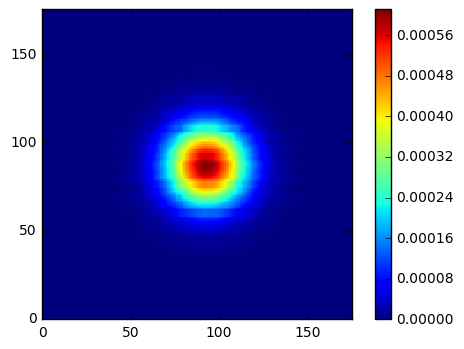

100%|██████████| 1000/1000 [01:20<00:00,  8.34it/s]


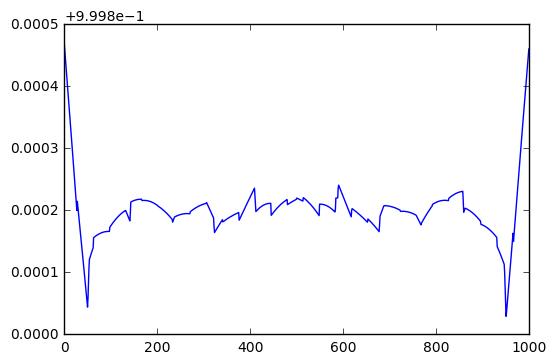

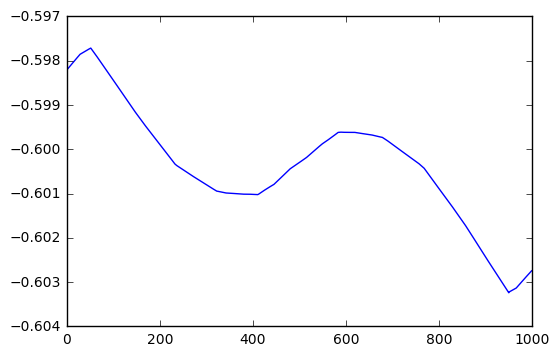

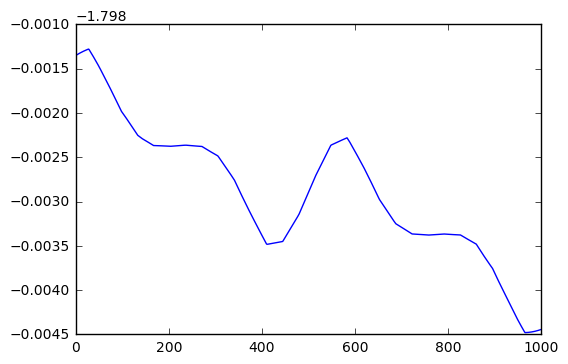

44


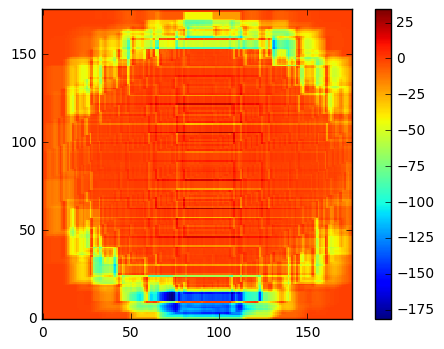

12164.2143161
12163.4677727 6.25e-12 0
12163.4677727
12162.2786268 1.0000000000000001e-11 1
12162.2786268
12160.3798484 1.6000000000000003e-11 2
12160.3798484
12157.3493905 2.5600000000000007e-11 3
12157.3493905
12152.5153542 4.096000000000001e-11 4
12152.5153542
12144.8461646 6.553600000000002e-11 5
12144.8461646
12140.0312347 1.0485760000000004e-10 6
12140.0312347
16135.9627934 1.6777216000000006e-10 7
12140.0312347
13208.0200946 -3.3554432000000015e-11 8
12140.0312347
12131.7991381 6.710886400000003e-12 9
12131.7991381
12130.5049871 1.0737418240000006e-11 10
12130.5049871
12128.5105271 1.717986918400001e-11 11
12128.5105271
12125.448914 2.748779069440002e-11 12
12125.448914
12124.7775015 4.398046511104004e-11 13
12124.7775015
12524.1649738 7.036874417766406e-11 14
12124.7775015
12384.5624592 -1.4073748835532812e-11 15
12124.7775015
12121.4137052 2.8147497671065625e-12 16
12121.4137052
12119.5180287 4.5035996273705e-12 17
12119.5180287
12118.4993237 7.205759403792801e-12 18
12118.499

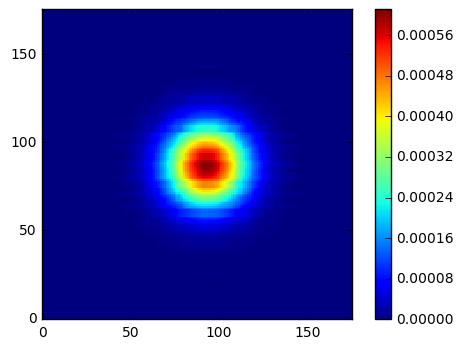

100%|██████████| 1000/1000 [01:21<00:00,  9.08it/s]


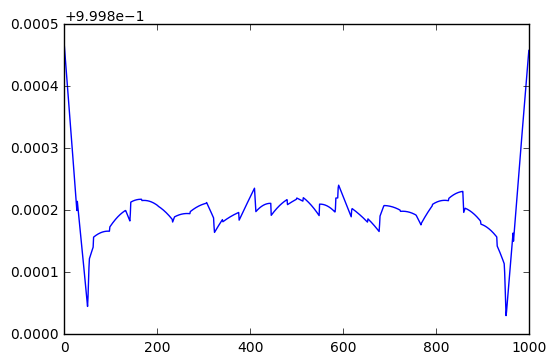

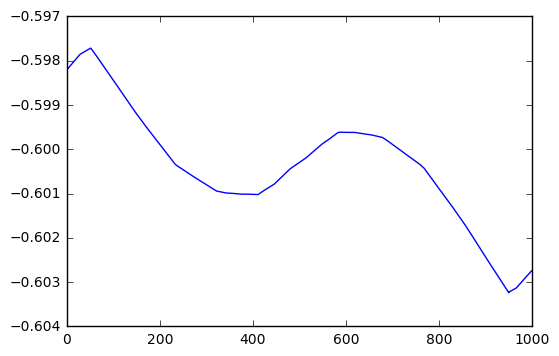

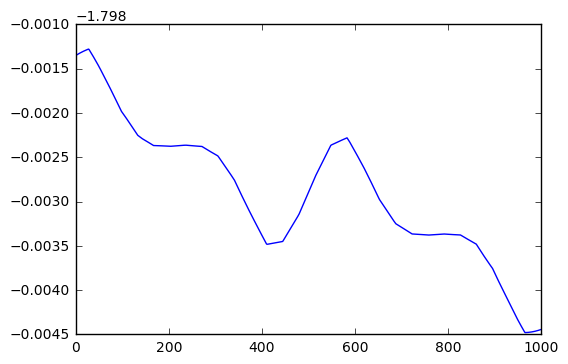

45


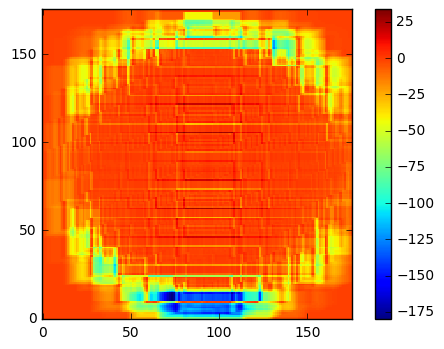

11984.3954553
11983.6645891 6.25e-12 0
11983.6645891
11982.5003208 1.0000000000000001e-11 1
11982.5003208
11980.6413034 1.6000000000000003e-11 2
11980.6413034
11977.6743292 2.5600000000000007e-11 3
11977.6743292
11972.9416401 4.096000000000001e-11 4
11972.9416401
11965.4295861 6.553600000000002e-11 5
11965.4295861
11959.3457243 1.0485760000000004e-10 6
11959.3457243
15165.3147725 1.6777216000000006e-10 7
11959.3457243
12974.7737691 -3.3554432000000015e-11 8
11959.3457243
11952.6687487 6.710886400000003e-12 9
11952.6687487
11951.405473 1.0737418240000006e-11 10
11951.405473
11949.4624517 1.717986918400001e-11 11
11949.4624517
11946.5759825 2.748779069440002e-11 12
11946.5759825
11950.4496902 4.398046511104004e-11 13
11946.5759825
12060.9045335 -8.796093022208007e-12 14
11946.5759825
11946.2483752 1.7592186044416015e-12 15
11946.2483752
11945.8301426 2.8147497671065625e-12 16
11945.8301426
11945.2753235 4.5035996273705e-12 17
11945.2753235
11944.4504788 7.205759403792801e-12 18
11944.450

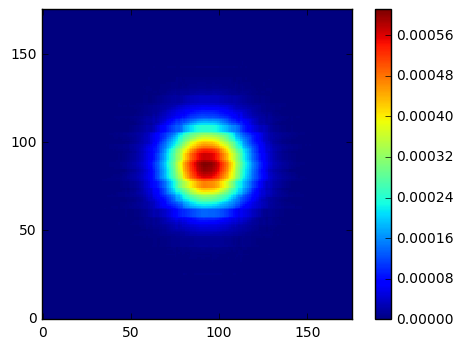

100%|██████████| 1000/1000 [01:21<00:00,  8.44it/s]


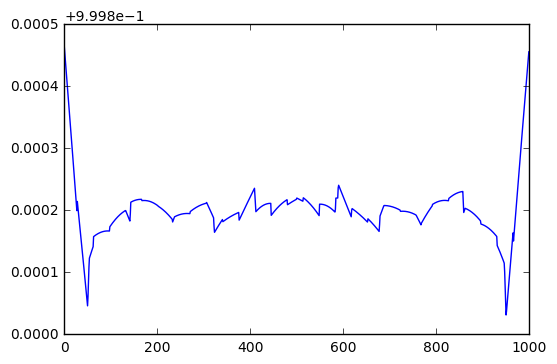

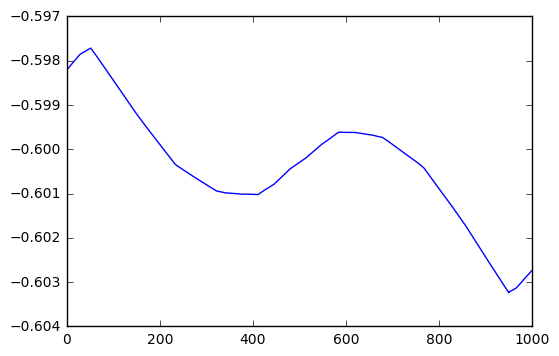

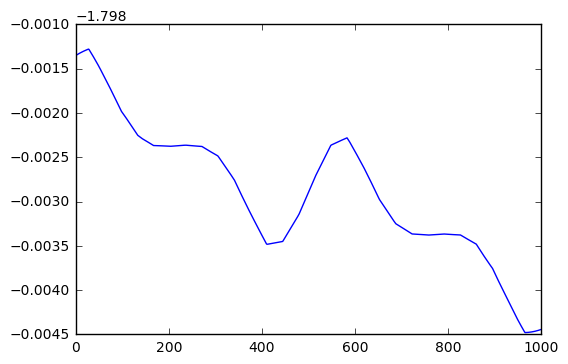

46


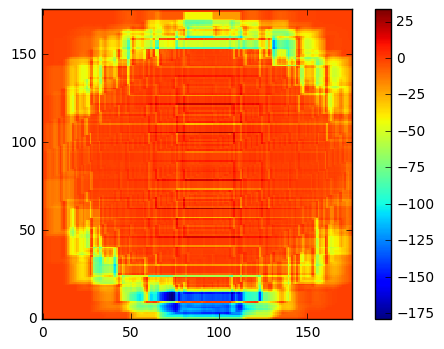

11813.5019992
11812.7861931 6.25e-12 0
11812.7861931
11811.6458035 1.0000000000000001e-11 1
11811.6458035
11809.8248712 1.6000000000000003e-11 2
11809.8248712
11806.9186508 2.5600000000000007e-11 3
11806.9186508
11802.2827798 4.096000000000001e-11 4
11802.2827798
11794.9228025 6.553600000000002e-11 5
11794.9228025
11789.2722633 1.0485760000000004e-10 6
11789.2722633
15065.821611 1.6777216000000006e-10 7
11789.2722633
12786.8011033 -3.3554432000000015e-11 8
11789.2722633
11782.411239 6.710886400000003e-12 9
11782.411239
11781.1742444 1.0737418240000006e-11 10
11781.1742444
11779.2625504 1.717986918400001e-11 11
11779.2625504
11776.3308685 2.748779069440002e-11 12
11776.3308685
11775.9293594 4.398046511104004e-11 13
11775.9293594
12188.2377607 7.036874417766406e-11 14
11775.9293594
12029.6998625 -1.4073748835532812e-11 15
11775.9293594
11772.5197521 2.8147497671065625e-12 16
11772.5197521
11770.6390742 4.5035996273705e-12 17
11770.6390742
11769.6608377 7.205759403792801e-12 18
11769.6608

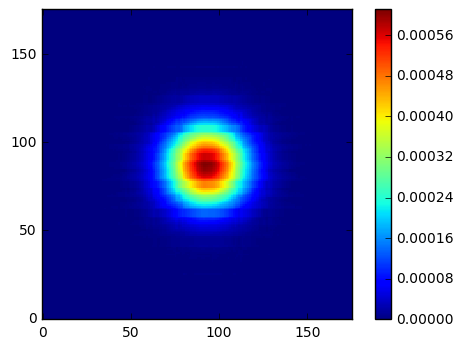

100%|██████████| 1000/1000 [01:21<00:00,  8.05it/s]


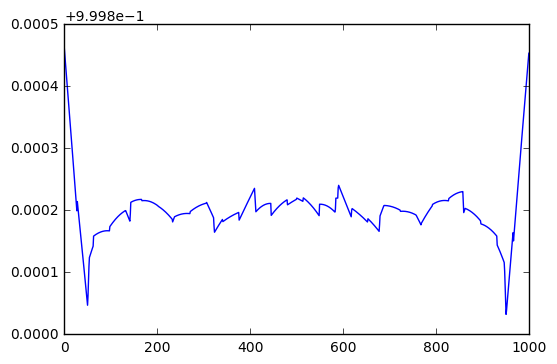

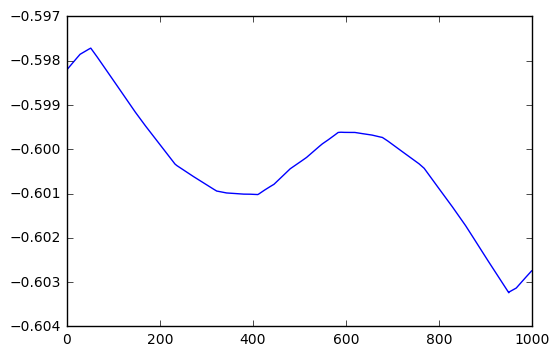

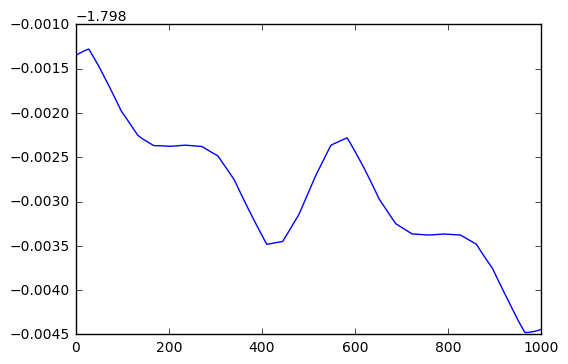

47


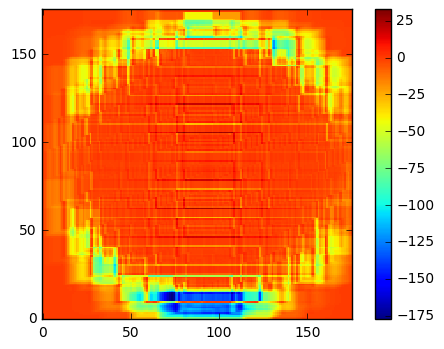

11640.5182246
11639.8164762 6.25e-12 0
11639.8164762
11638.6996735 1.0000000000000001e-11 1
11638.6996735
11636.9164692 1.6000000000000003e-11 2
11636.9164692
11634.0705008 2.5600000000000007e-11 3
11634.0705008
11629.5311192 4.096000000000001e-11 4
11629.5311192
11622.3367544 6.553600000000002e-11 5
11622.3367544
11619.791258 1.0485760000000004e-10 6
11619.791258
16658.6429145 1.6777216000000006e-10 7
11619.791258
12727.135795 -3.3554432000000015e-11 8
11619.791258
11610.089645 6.710886400000003e-12 9
11610.089645
11608.8707451 1.0737418240000006e-11 10
11608.8707451
11607.0227596 1.717986918400001e-11 11
11607.0227596
11604.5034199 2.748779069440002e-11 12
11604.5034199
11618.3533347 4.398046511104004e-11 13
11604.5034199
11715.9632136 -8.796093022208007e-12 14
11604.5034199
11604.0548576 1.7592186044416015e-12 15
11604.0548576
11603.5551736 2.8147497671065625e-12 16
11603.5551736
11602.9847204 4.5035996273705e-12 17
11602.9847204
11602.1902809 7.205759403792801e-12 18
11602.1902809


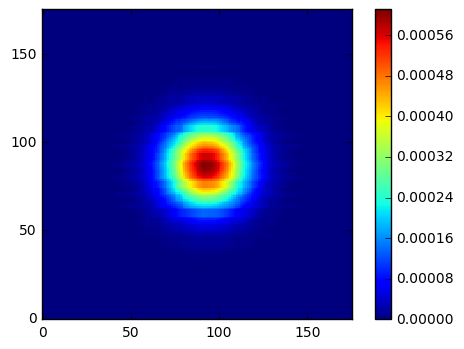

100%|██████████| 1000/1000 [01:20<00:00,  8.42it/s]


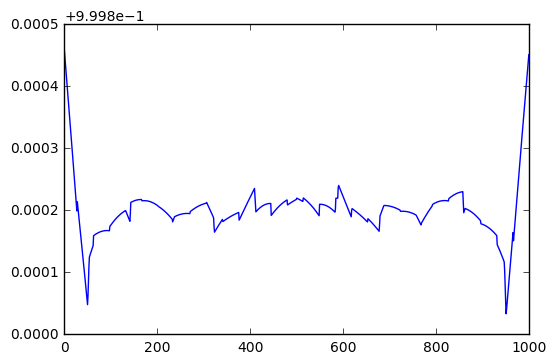

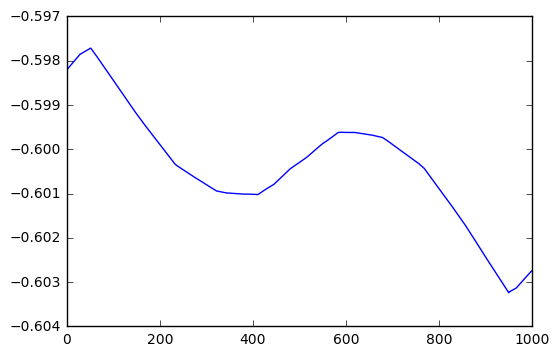

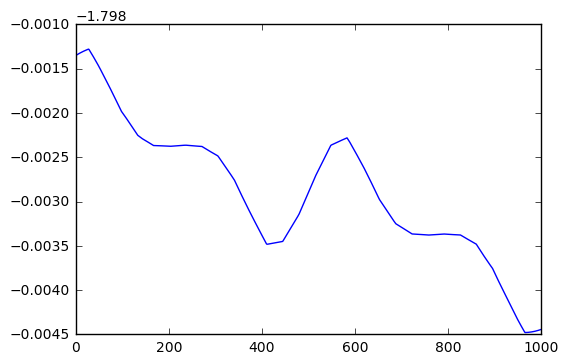

48


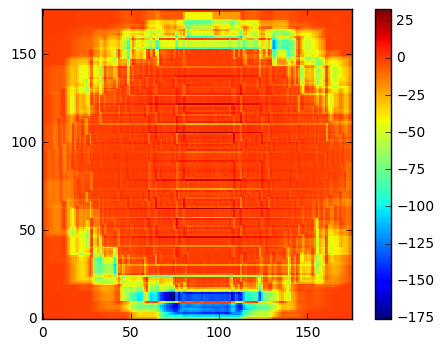

11475.7889673
11475.1018384 6.25e-12 0
11475.1018384
11474.0074856 1.0000000000000001e-11 1
11474.0074856
11472.2600565 1.6000000000000003e-11 2
11472.2600565
11469.4711671 2.5600000000000007e-11 3
11469.4711671
11465.0226026 4.096000000000001e-11 4
11465.0226026
11457.9698888 6.553600000000002e-11 5
11457.9698888
11454.4856869 1.0485760000000004e-10 6
11454.4856869
15645.1432936 1.6777216000000006e-10 7
11454.4856869
12475.107519 -3.3554432000000015e-11 8
11454.4856869
11445.9627912 6.710886400000003e-12 9
11445.9627912
11444.7682057 1.0737418240000006e-11 10
11444.7682057
11442.9321487 1.717986918400001e-11 11
11442.9321487
11440.1147735 2.748779069440002e-11 12
11440.1147735
11439.4636435 4.398046511104004e-11 13
11439.4636435
11803.2444741 7.036874417766406e-11 14
11439.4636435
11679.8044694 -1.4073748835532812e-11 15
11439.4636435
11436.3954226 2.8147497671065625e-12 16
11436.3954226
11434.6585449 4.5035996273705e-12 17
11434.6585449
11433.7194249 7.205759403792801e-12 18
11433.71

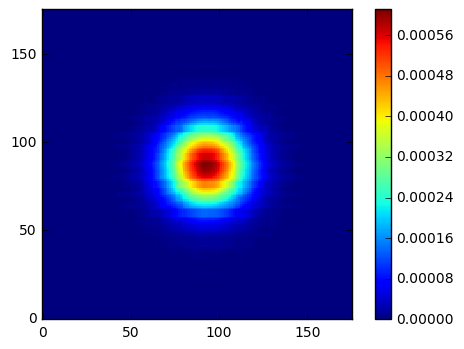

100%|██████████| 1000/1000 [01:21<00:00,  8.18it/s]


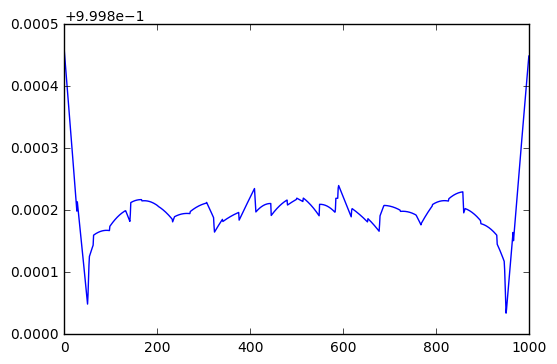

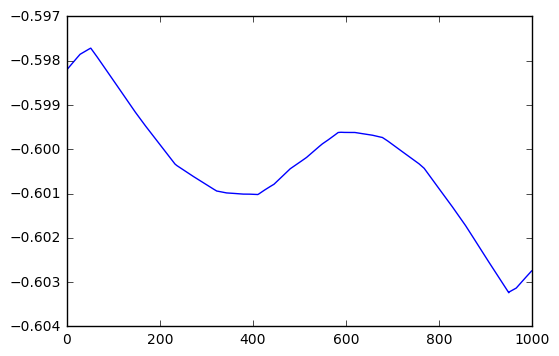

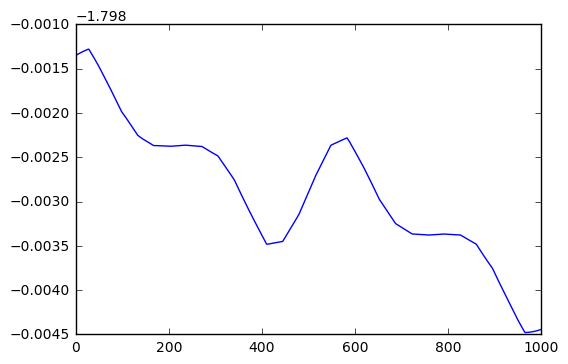

49


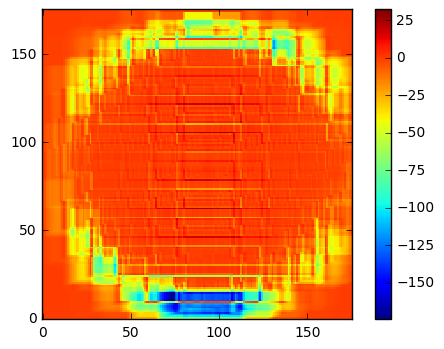

11310.7204649
11310.0482449 6.25e-12 0
11310.0482449
11308.9772295 1.0000000000000001e-11 1
11308.9772295
11307.2670919 1.6000000000000003e-11 2
11307.2670919
11304.5377565 2.5600000000000007e-11 3
11304.5377565
11300.1842178 4.096000000000001e-11 4
11300.1842178
11293.2729643 6.553600000000002e-11 5
11293.2729643
11287.9226145 1.0485760000000004e-10 6
11287.9226145
14295.3271013 1.6777216000000006e-10 7
11287.9226145
12227.7833926 -3.3554432000000015e-11 8
11287.9226145
11281.5277527 6.710886400000003e-12 9
11281.5277527
11280.3629931 1.0737418240000006e-11 10
11280.3629931
11278.5679943 1.717986918400001e-11 11
11278.5679943
11275.8189925 2.748779069440002e-11 12
11275.8189925
11275.5549552 4.398046511104004e-11 13
11275.5549552
11671.7977672 7.036874417766406e-11 14
11275.5549552
11516.7042211 -1.4073748835532812e-11 15
11275.5549552
11272.279171 2.8147497671065625e-12 16
11272.279171
11270.4762663 4.5035996273705e-12 17
11270.4762663
11269.550803 7.205759403792801e-12 18
11269.5508

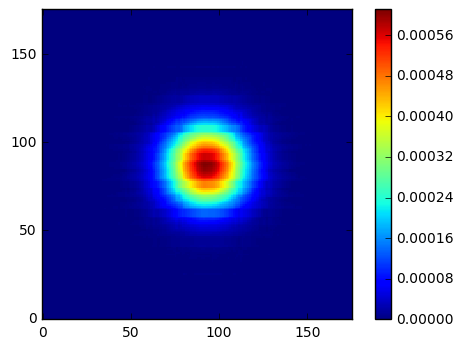

100%|██████████| 1000/1000 [01:21<00:00,  8.67it/s]


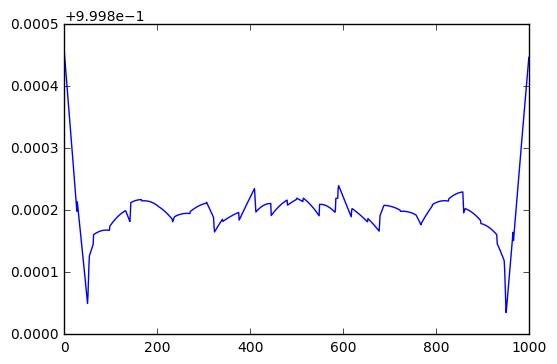

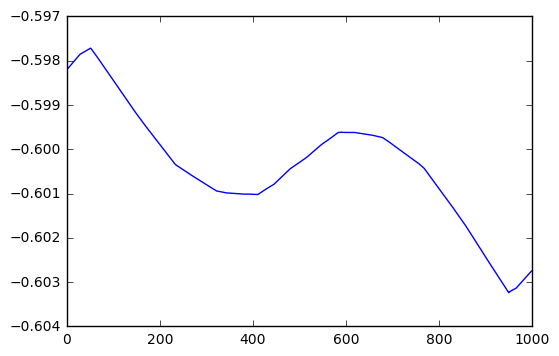

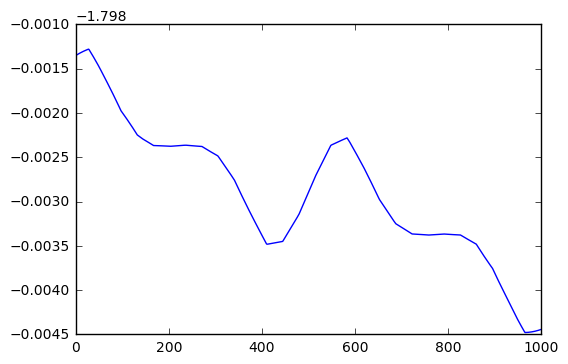

50


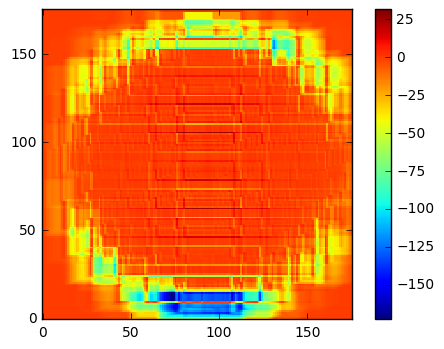

11149.7914548
11149.132489 6.25e-12 0
11149.132489
11148.0833887 1.0000000000000001e-11 1
11148.0833887
11146.4082763 1.6000000000000003e-11 2
11146.4082763
11143.7348488 2.5600000000000007e-11 3
11143.7348488
11139.4707259 4.096000000000001e-11 4
11139.4707259
11132.7074125 6.553600000000002e-11 5
11132.7074125
11128.999531 1.0485760000000004e-10 6
11128.999531
15117.3214973 1.6777216000000006e-10 7
11128.999531
12126.5510691 -3.3554432000000015e-11 8
11128.999531
11121.2070565 6.710886400000003e-12 9
11121.2070565
11120.0671042 1.0737418240000006e-11 10
11120.0671042
11118.3265109 1.717986918400001e-11 11
11118.3265109
11115.8781682 2.748779069440002e-11 12
11115.8781682
11125.5894564 4.398046511104004e-11 13
11115.8781682
11221.0098166 -8.796093022208007e-12 14
11115.8781682
11115.5010971 1.7592186044416015e-12 15
11115.5010971
11115.064466 2.8147497671065625e-12 16
11115.064466
11114.5416708 4.5035996273705e-12 17
11114.5416708
11113.7967924 7.205759403792801e-12 18
11113.7967924
1

KeyboardInterrupt: 

In [53]:
for j in range(100):
    print(j)
    
    results = np.array(results)
    gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:,1], results[:, 2]))
    
    plt.imshow(gds, origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.show()

    f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]
    
    results = []
    lnlike = []
    for i in tqdm(range(1000)):
        logL = lnlikelihood(data=tpf[i])
        sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
        results.append(sol.x)
        lnlike.append(sol.fun)
        
    results = np.array(results)
    plt.plot(np.arange(1000), results[:,0]/np.median(results[:,0]))
    plt.show()
    plt.plot(np.arange(1000), results[:,1]/ss-0.7*np.linspace(0, 1, 1000))
    plt.show()
    plt.plot(np.arange(1000), results[:,2]/ss-1.8*np.linspace(0, 1, 1000))
    plt.show()



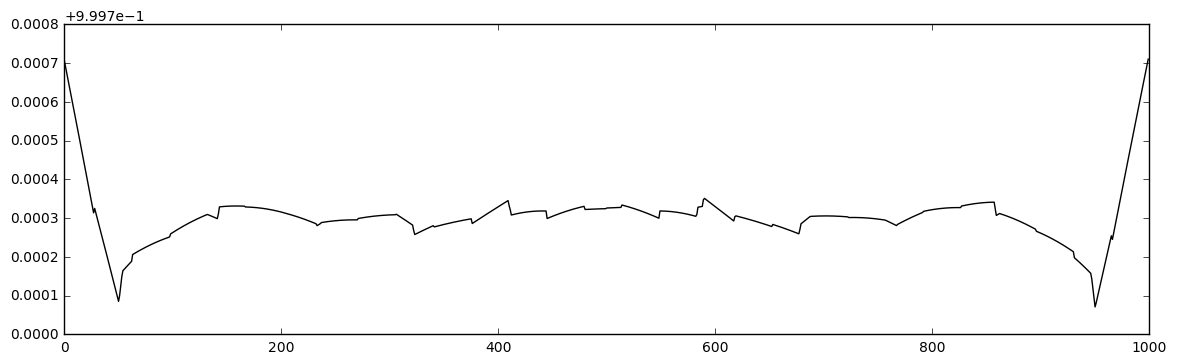

In [52]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux/np.sum(tpf, axis=(1,2)), 'k')
#plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1690, 1900)

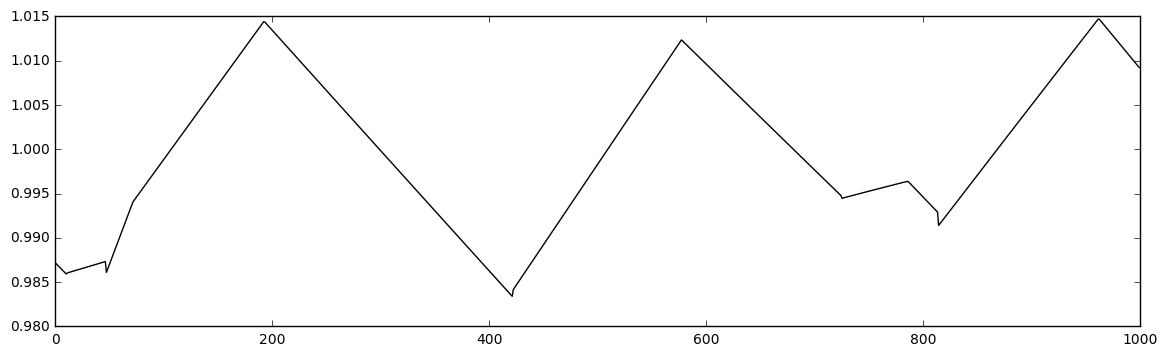

In [2585]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux/np.sum(tpf, axis=(1,2)), 'k')
#plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1690, 1900)

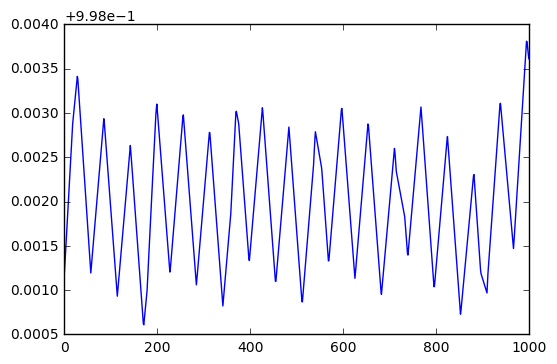

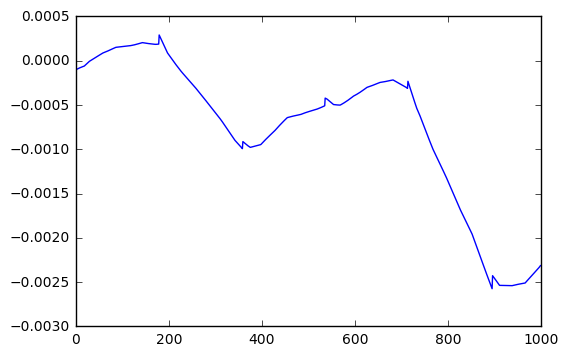

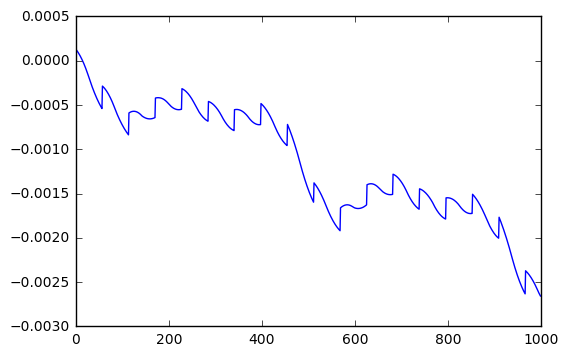

In [2541]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,0]/np.median(results[:,0]))
plt.show()
plt.plot(np.arange(1000), results[:,1]/ss-0.7*np.linspace(0, 1, 1000))
plt.show()
plt.plot(np.arange(1000), results[:,2]/ss-2.2*np.linspace(0, 1, 1000))
plt.show()